In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Simulate Buying and Selling Stock Using ARMA(p,q)

In [2]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

# Read Data

In [3]:
tickerSymbol = 'AAPL'
data = yf.Ticker(tickerSymbol)

In [4]:
prices = data.history(start='2021-09-01', end='2022-01-01').Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

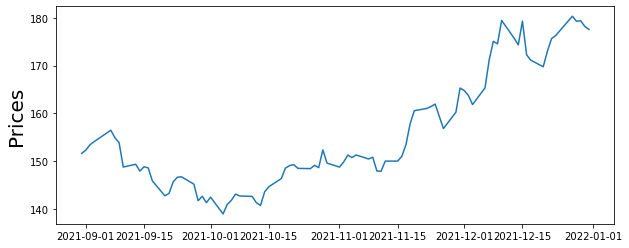

In [5]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

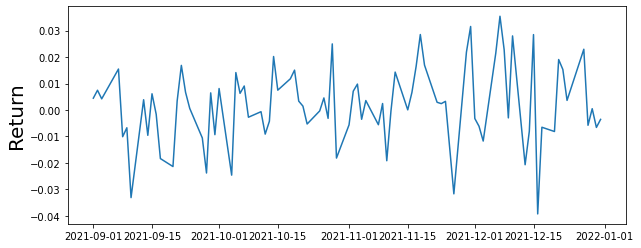

In [6]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

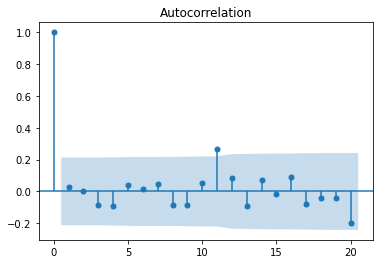

In [7]:
plot_acf(returns)
plt.show()

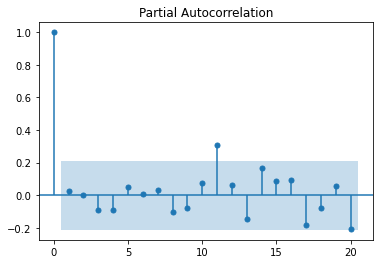

In [8]:
plot_pacf(returns)
plt.show()

# Baseline Model : Random Buying 

100%|████████████████████████████████████████| 71/71 [00:00<00:00, 19189.10it/s]


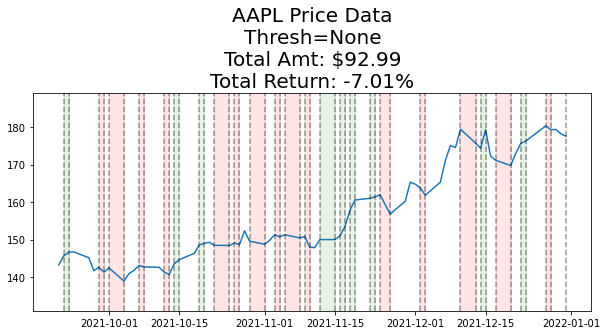

92.99420464400644

In [9]:
run_simulation(returns, prices, 100, 0.5, None, verbose=False)

In [10]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

100%|████████████████████████████████████████| 71/71 [00:00<00:00, 28814.28it/s]


100%|████████████████████████████████████████| 71/71 [00:00<00:00, 27975.16it/s]


100%|████████████████████████████████████████| 71/71 [00:00<00:00, 30843.66it/s]


100%|████████████████████████████████████████| 71/71 [00:00<00:00, 28176.33it/s]


100%|████████████████████████████████████████| 71/71 [00:00<00:00, 28240.45it/s]


100%|████████████████████████████████████████| 71/71 [00:00<00:00, 30328.50it/s]


100%|████████████████████████████████████████| 71/71 [00:00<00:00, 28861.75it/s]


100%|████████████████████████████████████████| 71/71 [00:00<00:00, 30022.74it/s]


100%|████████████████████████████████████████| 71/71 [00:00<00:00, 30405.92it/s]


100%|████████████████████████████████████████| 71/71 [00:00<00:00, 29107.18it/s]


/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Avg: $106.68\nSD: $6.47')

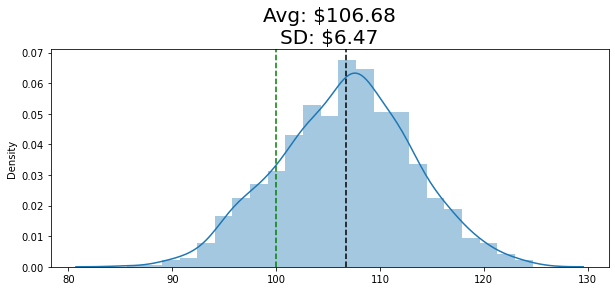

In [11]:
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

# If Last Return was Positive, Buy

100%|████████████████████████████████████████| 71/71 [00:00<00:00, 27431.43it/s]


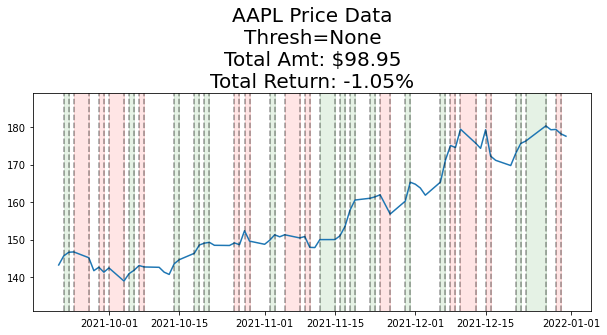

98.9524942379331

In [12]:
run_simulation(returns, prices, 100, 'last', None, verbose=False)

# Try AR(1) Model

  0%|                                                    | 0/71 [00:00<?, ?it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 10%|████▎                                       | 7/71 [00:00<00:00, 66.06it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 21%|█████████                                  | 15/71 [00:00<00:00, 72.53it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.89496D+00    |proj g|=  2.74106D+00

At iterate    5    f= -2.89580D+00    |proj g|=  3.10119D-02

At iterate   10    f= -2.89580D+00    |proj g|=  1.74971D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     22      1     0     0   2.665D-07  -2.896D+00
  F =  -2.8958023489309976     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 34%|██████████████▌                            | 24/71 [00:00<00:00, 76.29it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.97311D+00    |proj g|=  1.54955D+00

At iterate    5    f= -2.97329D+00    |proj g|=  5.58176D-04

At iterate   10    f= -2.97329D+00    |proj g|=  6.58158D-03

At iterate   15    f= -2.97329D+00    |proj g|=  7.01661D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     17     23      1     0     0   9.770D-07  -2.973D+00
  F =  -2.9732854308485503     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 52%|██████████████████████▍                    | 37/71 [00:00<00:00, 93.77it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 73%|██████████████████████████████▊           | 52/71 [00:00<00:00, 110.57it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -3.01211D+00    |proj g|=  4.58122D-04

At iterate   10    f= -3.01211D+00    |proj g|=  3.78320D-03

At iterate   15    f= -3.01211D+00    |proj g|=  1.37668D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     20      1     0     0   1.776D-07  -3.012D+00
  F =  -3.0121119728657462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.00723D+00    |proj g|=  6.32454D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
100%|██████████████████████████████████████████| 71/71 [00:00<00:00, 111.82it/s]



At iterate    5    f= -2.79444D+00    |proj g|=  8.22906D-03

At iterate   10    f= -2.79444D+00    |proj g|=  1.06581D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     18      1     0     0   0.000D+00  -2.794D+00
  F =  -2.7944366424657536     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


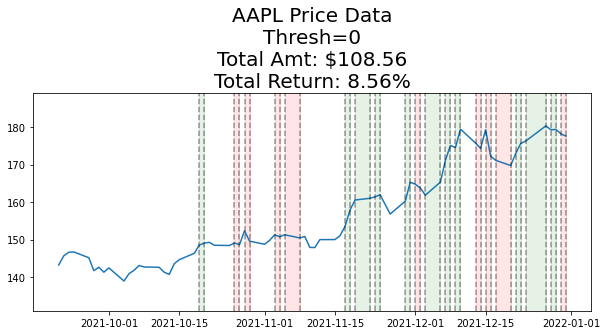

  0%|                                                    | 0/71 [00:00<?, ?it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.89496D+00    |proj g|=  2.74106D+00

At iterate    5    f= -2.89580D+00    |proj g|=  3.10119D-02

At iterate   10    f= -2.89580D+00    |proj g|=  1.74971D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     22      1     0     0   2.665D-07  -2.896D+00
  F =  -2.8958023489309976     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 10%|████▎                                       | 7/71 [00:00<00:00, 68.75it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 21%|█████████                                  | 15/71 [00:00<00:00, 73.39it/s]


At iterate    5    f= -2.94492D+00    |proj g|=  1.23519D-02

At iterate   10    f= -2.94492D+00    |proj g|=  1.37212D-01

At iterate   15    f= -2.94493D+00    |proj g|=  2.04281D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     20      1     0     0   0.000D+00  -2.945D+00
  F =  -2.9449297197194872     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94810D+00    |proj g|=  2.11813D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.97311D+00    |proj g|=  1.54955D+00

At iterate    5    f= -2.97329D+00    |proj g|=  5.58176D-04

At iterate   10    f= -2.97329D+00    |proj g|=  6.58158D-03

At iterate   15    f= -2.97329D+00    |proj g|=  7.01661D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     17     23      1     0     0   9.770D-07  -2.973D+00
  F =  -2.9732854308485503     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 32%|█████████████▉                             | 23/71 [00:00<00:00, 75.45it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 46%|███████████████████▉                       | 33/71 [00:00<00:00, 83.22it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.97993D+00    |proj g|=  9.10866D-01

At iterate    5    f= -2.98000D+00    |proj g|=  6.12951D-02

At iterate   10    f= -2.98000D+00    |proj g|=  4.35652D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     19      1     0     0   4.441D-08  -2.980D+00
  F =  -2.9800049792957579     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.01751D+00    |proj g|=  6.71419D-01

At iterate    5    f= -3.01754D+00    |proj g|=  3.00826D-04

At iterate   10    f= -3.01754D+00    |proj g|=  2.75864D-03

At iterate   15    f= -3.01754D+00    |proj g|=  1.06581D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     23      1     0     0   8.882D-08  -3.018D+00
  F =  -3.0175425264210403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 59%|█████████████████████████▍                 | 42/71 [00:00<00:00, 84.01it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 86%|████████████████████████████████████      | 61/71 [00:00<00:00, 116.94it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.97772D+00    |proj g|=  4.34956D-01

At iterate    5    f= -2.97774D+00    |proj g|=  1.64926D-02

At iterate   10    f= -2.97774D+00    |proj g|=  1.09921D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     19      1     0     0   3.109D-07  -2.978D+00
  F =  -2.9777397078358954     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
100%|██████████████████████████████████████████| 71/71 [00:00<00:00, 104.46it/s]

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.78070D+00    |proj g|=  1.69541D-01

At iterate    5    f= -2.78071D+00    |proj g|=  8.52767D-03

At iterate   10    f= -2.78071D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     17      1     0     0   0.000D+00  -2.781D+00
  F =  -2.7807083611025338     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12



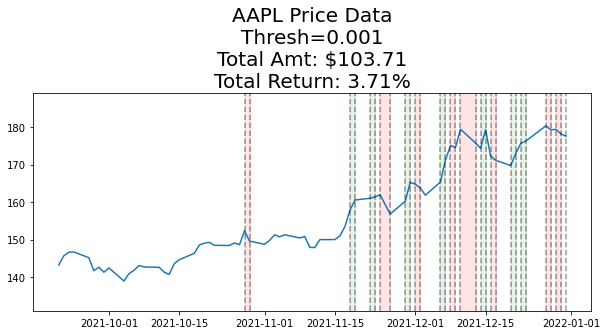

  0%|                                                    | 0/71 [00:00<?, ?it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.89496D+00    |proj g|=  2.74106D+00

At iterate    5    f= -2.89580D+00    |proj g|=  3.10119D-02

At iterate   10    f= -2.89580D+00    |proj g|=  1.74971D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     22      1     0     0   2.665D-07  -2.896D+00
  F =  -2.8958023489309976     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 11%|████▉                                       | 8/71 [00:00<00:00, 71.52it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.92901D+00    |proj g|=  3.25554D-02

At iterate   10    f= -2.92903D+00    |proj g|=  3.53936D-01

At iterate   15    f= -2.92908D+00    |proj g|=  4.76463D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     22      1     0     0   7.994D-07  -2.929D+00
  F =  -2.9290791183228455     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.92793D+00    |proj g|=  2.29630D+00

At iter

 This problem is unconstrained.
 23%|█████████▋                                 | 16/71 [00:00<00:00, 73.56it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.97311D+00    |proj g|=  1.54955D+00

At iterate    5    f= -2.97329D+00    |proj g|=  5.58176D-04

At iterate   10    f= -2.97329D+00    |proj g|=  6.58158D-03

At iterate   15    f= -2.97329D+00    |proj g|=  7.01661D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     17     23      1     0     0   9.770D-07  -2.973D+00
  F =  -2.9732854308485503     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 35%|███████████████▏                           | 25/71 [00:00<00:00, 75.62it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.95462D+00    |proj g|=  8.97737D-01

At iterate    5    f= -2.95469D+00    |proj g|=  5.73796D-02

At iterate   10    f= -2.95469D+00    |proj g|=  3.80140D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     26      1     0     0   2.265D-06  -2.955D+00
  F =  -2.9546940325606559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 49%|█████████████████████▏                     | 35/71 [00:00<00:00, 81.58it/s] This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.99938D+00    |proj g|=  6.66008D-01

At iterate    5    f= -2.99942D+00    |proj g|=  3.62999D-04

At iterate   10    f= -2.99942D+00    |proj g|=  2.95781D-03

At iterate   15    f= -2.99942D+00    |proj g|=  3.10862D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     19      1     0     0   3.109D-07  -2.999D+00
  F =  -2.9994172278621667     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 62%|██████████████████████████▋                | 44/71 [00:00<00:00, 80.74it/s]


At iterate   10    f= -3.01211D+00    |proj g|=  3.78320D-03

At iterate   15    f= -3.01211D+00    |proj g|=  1.37668D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     20      1     0     0   1.776D-07  -3.012D+00
  F =  -3.0121119728657462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.00723D+00    |proj g|=  6.32454D-01

At iterate    5    f= -3.00726D+00    |proj g|=  5.51799D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 75%|████████████████████████████████           | 53/71 [00:00<00:00, 83.18it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.90653D+00    |proj g|=  2.79744D-01

At iterate    5    f= -2.90653D+00    |proj g|=  2.83230D-02

At iterate   10    f= -2.90653D+00    |proj g|=  3.10862D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     18      1     0     0   8.882D-08  -2.907D+00
  F =  -2.9065342565921992     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 92%|███████████████████████████████████████▎   | 65/71 [00:00<00:00, 91.45it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.86861D+00    |proj g|=  2.52795D-02

At iterate   10    f= -2.86861D+00    |proj g|=  4.58211D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     19      1     0     0   3.997D-07  -2.869D+00
  F =  -2.8686081325513890     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.84997D+00    |proj g|=  1.39807D-01

At iterate    5    f= -2.84997D+00    |proj g|=  1.72110D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
100%|███████████████████████████████████████████| 71/71 [00:00<00:00, 84.35it/s]


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.79443D+00    |proj g|=  1.34564D-01

At iterate    5    f= -2.79444D+00    |proj g|=  8.22906D-03

At iterate   10    f= -2.79444D+00    |proj g|=  1.06581D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     18      1     0     0   0.000D+00  -2.794D+00
  F =  -2.7944366424657536     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

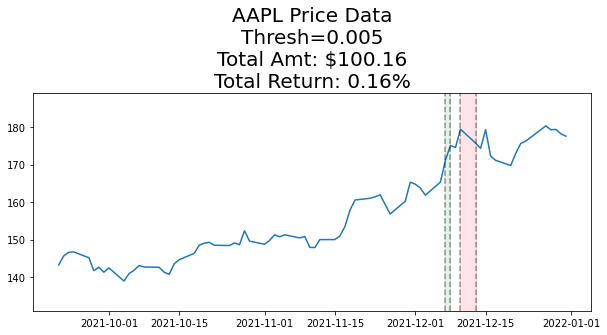

In [13]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1,0,0), thresh, verbose=False)

# Try AR(11) Model

  0%|                                                    | 0/71 [00:00<?, ?it/s]/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.17571D+00    |proj g|=  1.09531D+02


 This problem is unconstrained.



At iterate    5    f= -3.18668D+00    |proj g|=  2.56493D+00

At iterate   10    f= -3.18836D+00    |proj g|=  4.17489D+01

At iterate   15    f= -3.22171D+00    |proj g|=  2.88388D+01

At iterate   20    f= -3.24207D+00    |proj g|=  2.07681D+01

At iterate   25    f= -3.26016D+00    |proj g|=  1.95351D+00

At iterate   30    f= -3.32215D+00    |proj g|=  5.18871D+01

At iterate   35    f= -3.36692D+00    |proj g|=  4.66589D+00

At iterate   40    f= -3.36696D+00    |proj g|=  2.65696D-01

At iterate   45    f= -3.36796D+00    |proj g|=  3.28759D+00

At iterate   50    f= -3.37866D+00    |proj g|=  3.32727D+00

At iterate   55    f= -3.42173D+00    |proj g|=  4.06958D+00

At iterate   60    f= -3.45887D+00    |proj g|=  6.69122D+01

At iterate   65    f= -3.46638D+00    |proj g|=  3.26729D-01

At iterate   70    f= -3.46645D+00    |proj g|=  6.91780D+00

At iterate   75    f= -3.47169D+00    |proj g|=  4.10739D+01

At iterate   80    f= -3.47489D+00    |proj g|=  1.55417D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  175    f= -3.49912D+00    |proj g|=  7.39129D-01

At iterate  180    f= -3.49925D+00    |proj g|=  1.41724D+01

At iterate  185    f= -3.50006D+00    |proj g|=  3.61160D-01

At iterate  190    f= -3.50006D+00    |proj g|=  8.88723D-01

At iterate  195    f= -3.50035D+00    |proj g|=  9.64267D+00

At iterate  200    f= -3.50533D+00    |proj g|=  2.27551D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12    200    267      2     0     0   2.276D+01  -3.505D+00
  F =  -3.5053275525157357     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 13%|█████▌                                      | 9/71 [00:15<01:45,  1.70s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88067D+00    |proj g|=  6.25561D+00


 This problem is unconstrained.



At iterate    5    f= -2.88080D+00    |proj g|=  5.16903D-01

At iterate   10    f= -2.89626D+00    |proj g|=  7.45890D+00

At iterate   15    f= -2.89810D+00    |proj g|=  4.12734D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -2.89817D+00    |proj g|=  2.35377D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     24     76      2     0     0   3.246D-01  -2.898D+00
  F =  -2.8981700316809880     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 15%|██████▋                                    | 11/71 [00:21<02:04,  2.08s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94542D+00    |proj g|=  4.97027D+00


 This problem is unconstrained.



At iterate    5    f= -2.94556D+00    |proj g|=  2.89802D+00

At iterate   10    f= -2.95000D+00    |proj g|=  1.54309D-01

At iterate   15    f= -2.95030D+00    |proj g|=  2.75431D+00

At iterate   20    f= -2.95649D+00    |proj g|=  1.11254D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -2.95650D+00    |proj g|=  3.32901D-01

At iterate   30    f= -2.95650D+00    |proj g|=  2.68163D-01

At iterate   35    f= -2.95651D+00    |proj g|=  1.03963D+00

At iterate   40    f= -2.95707D+00    |proj g|=  1.60626D+01

At iterate   45    f= -2.96316D+00    |proj g|=  1.27309D+01

At iterate   50    f= -2.96321D+00    |proj g|=  5.30476D-01

At iterate   55    f= -2.96325D+00    |proj g|=  2.10629D+00

At iterate   60    f= -2.96342D+00    |proj g|=  3.03864D-01

At iterate   65    f= -2.96343D+00    |proj g|=  1.74594D-01

At iterate   70    f= -2.96351D+00    |proj g|=  9.34342D-01

At iterate   75    f= -2.96545D+00    |proj g|=  3.06036D+00

At iterate   80    f= -2.96567D+00    |proj g|=  4.20299D-01

At iterate   85    f= -2.96568D+00    |proj g|=  1.85298D+00

At iterate   90    f= -2.96581D+00    |proj g|=  8.87944D+00

At iterate   95    f= -2.96881D+00    |proj g|=  9.82530D+00

At iterate  100    f= -2.98241D+00    |proj g|=  7.68078D+00

At iter

 18%|███████▊                                   | 13/71 [00:41<03:54,  4.05s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.19601D+00    |proj g|=  1.52893D+01

At iterate    5    f= -3.19773D+00    |proj g|=  2.36942D+00

At iterate   10    f= -3.20324D+00    |proj g|=  2.04373D+01

At iterate   15    f= -3.20961D+00    |proj g|=  6.80248D-02

At iterate   20    f= -3.21232D+00    |proj g|=  7.20123D+00

At iterate   25    f= -3.22289D+00    |proj g|=  3.73356D-01

At iterate   30    f= -3.22307D+00    |proj g|=  3.56649D+00

At iterate   35    f= -3.22825D+00    |proj g|=  6.69441D+00

At iterate   40    f= -3.22861D+00    |proj g|=  4.19725D-02

At iterate   45    f= -3.23106D+00    |proj g|=  7.03553D-02

At iterate   50    f= -3.23114D+00    |proj g|=  1.00596D+00

At iterate   55    f= -3.23195D+00    |proj g|=  6.45794D-01

At iterate   60    f= -3.23195D+00    |proj g|=  3.15584D-02

At iterate   65    f= -3.2

 20%|████████▍                                  | 14/71 [00:53<05:04,  5.34s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.22147D+00    |proj g|=  1.45871D+01

At iterate    5    f= -3.22320D+00    |proj g|=  3.49399D+00

At iterate   10    f= -3.23171D+00    |proj g|=  1.88295D+01

At iterate   15    f= -3.23534D+00    |proj g|=  8.74274D-02

At iterate   20    f= -3.23565D+00    |proj g|=  2.15422D+00

At iterate   25    f= -3.24400D+00    |proj g|=  7.82907D+00

At iterate   30    f= -3.24965D+00    |proj g|=  8.69973D-01

At iterate   35    f= -3.24981D+00    |proj g|=  4.58058D-01

At iterate   40    f= -3.25026D+00    |proj g|=  6.03924D+00

At iterate   45    f= -3.25103D+00    |proj g|=  1.78280D-02

At iterate   50    f= -3.25104D+00    |proj g|=  5.21247D-02

At iterate   55    f= -3.25109D+00    |proj g|=  2.33970D-01

At iterate   60    f= -3.25111D+00    |proj g|=  1.81007D-02

At iterate   65    f= -3.2

 21%|█████████                                  | 15/71 [01:06<06:12,  6.66s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.24660D+00    |proj g|=  1.57190D+01

At iterate    5    f= -3.24824D+00    |proj g|=  1.36199D+00

At iterate   10    f= -3.25033D+00    |proj g|=  1.61033D+01

At iterate   15    f= -3.25995D+00    |proj g|=  1.94609D-01

At iterate   20    f= -3.25997D+00    |proj g|=  5.37930D-01

At iterate   25    f= -3.26194D+00    |proj g|=  5.79570D+00

At iterate   30    f= -3.26564D+00    |proj g|=  1.48129D-01

At iterate   35    f= -3.26573D+00    |proj g|=  6.50019D-01

At iterate   40    f= -3.26800D+00    |proj g|=  2.06872D+00

At iterate   45    f= -3.26913D+00    |proj g|=  1.33197D-02

At iterate   50    f= -3.26915D+00    |proj g|=  4.77977D-01

At iterate   55    f= -3.26998D+00    |proj g|=  3.99707D+00

At iterate   60    f= -3.27030D+00    |proj g|=  1.46158D-01

At iterate   65    f= -3.2

 23%|█████████▋                                 | 16/71 [01:18<07:06,  7.75s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.15253D+00    |proj g|=  8.90089D-01


 This problem is unconstrained.



At iterate    5    f= -3.16802D+00    |proj g|=  2.77949D-01

At iterate   10    f= -3.18476D+00    |proj g|=  8.63651D-02

At iterate   15    f= -3.18930D+00    |proj g|=  4.79300D-01

At iterate   20    f= -3.19237D+00    |proj g|=  2.86230D-01

At iterate   25    f= -3.19748D+00    |proj g|=  4.00066D-01

At iterate   30    f= -3.20902D+00    |proj g|=  8.02502D-01

At iterate   35    f= -3.21044D+00    |proj g|=  2.13875D-01

At iterate   40    f= -3.21429D+00    |proj g|=  2.51371D+00

At iterate   45    f= -3.21590D+00    |proj g|=  1.69027D-02

At iterate   50    f= -3.21622D+00    |proj g|=  2.59513D-01

At iterate   55    f= -3.21653D+00    |proj g|=  1.12447D-01

At iterate   60    f= -3.21703D+00    |proj g|=  2.04779D-02

At iterate   65    f= -3.21705D+00    |proj g|=  3.71030D-02

At iterate   70    f= -3.21717D+00    |proj g|=  5.37557D-02

At iterate   75    f= -3.21719D+00    |proj g|=  5.88587D-03

At iterate   80    f= -3.21720D+00    |proj g|=  8.92922D-02

At iter

 24%|██████████▎                                | 17/71 [01:31<07:59,  8.88s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.16822D+00    |proj g|=  4.29335D+00

At iterate    5    f= -3.16876D+00    |proj g|=  1.10613D+00

At iterate   10    f= -3.17407D+00    |proj g|=  1.12909D+01

At iterate   15    f= -3.18433D+00    |proj g|=  2.30890D+00

At iterate   20    f= -3.19627D+00    |proj g|=  7.84206D+00

At iterate   25    f= -3.20062D+00    |proj g|=  8.65689D-02

At iterate   30    f= -3.20076D+00    |proj g|=  2.56700D+00

At iterate   35    f= -3.20603D+00    |proj g|=  7.49804D+00

At iterate   40    f= -3.20697D+00    |proj g|=  3.11613D-02

At iterate   45    f= -3.21355D+00    |proj g|=  1.31447D+00

At iterate   50    f= -3.21443D+00    |proj g|=  4.83712D-01

At iterate   55    f= -3.21736D+00    |proj g|=  4.75794D+00

At iterate   60    f= -3.22154D+00    |proj g|=  1.52711D+00

At iterate   65    f= -3.2

 25%|██████████▉                                | 18/71 [01:43<08:39,  9.80s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.13783D+00    |proj g|=  9.48922D+00

At iterate    5    f= -3.16281D+00    |proj g|=  3.56892D+00

At iterate   10    f= -3.17449D+00    |proj g|=  2.40069D+00

At iterate   15    f= -3.18524D+00    |proj g|=  8.21460D-02

At iterate   20    f= -3.18779D+00    |proj g|=  3.09858D+00

At iterate   25    f= -3.19213D+00    |proj g|=  3.32892D-02

At iterate   30    f= -3.19515D+00    |proj g|=  1.25223D-01

At iterate   35    f= -3.19520D+00    |proj g|=  2.26859D-01

At iterate   40    f= -3.19640D+00    |proj g|=  3.32058D-01

At iterate   45    f= -3.19678D+00    |proj g|=  3.92708D-03

At iterate   50    f= -3.19687D+00    |proj g|=  3.84934D-01

At iterate   55    f= -3.19693D+00    |proj g|=  2.32525D-03

At iterate   60    f= -3.19693D+00    |proj g|=  2.15364D-02

At iterate   65    f= -3.1

 27%|███████████▌                               | 19/71 [01:56<09:04, 10.48s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30800D+00    |proj g|=  4.70516D-01


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f= -2.71786D+00    |proj g|=  1.80149D-01

At iterate   10    f= -3.02194D+00    |proj g|=  4.61593D-02

At iterate   15    f= -3.04520D+00    |proj g|=  1.51650D-02

At iterate   20    f= -3.07217D+00    |proj g|=  4.78680D-02

At iterate   25    f= -3.10237D+00    |proj g|=  4.82638D-01

At iterate   30    f= -3.12911D+00    |proj g|=  7.09350D-02

At iterate   35    f= -3.14730D+00    |proj g|=  1.47700D+00

At iterate   40    f= -3.15368D+00    |proj g|=  9.82143D-02

At iterate   45    f= -3.17254D+00    |proj g|=  2.97050D+00

At iterate   50    f= -3.17464D+00    |proj g|=  3.23182D-01

At iterate   55    f= -3.17511D+00    |proj g|=  1.26338D-02

At iterate   60    f= -3.17533D+00    |proj g|=  1.99025D-01

At iterate   65    f= -3.17617D+00    |proj g|=  1.28989D-02

At iterate   70    f= -3.17634D+00    |proj g|=  5.84062D-03

At iterate   75    f= -3.17660D+00    |proj g|=  4.12705D-03

At iterate   80    f= -3.17660D+00    |proj g|=  3.99738D-02

At iter

 28%|████████████                               | 20/71 [02:09<09:30, 11.18s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.06758D+00    |proj g|=  8.76463D+00

At iterate    5    f= -3.15141D+00    |proj g|=  6.78414D-01

At iterate   10    f= -3.16805D+00    |proj g|=  5.42992D-02

At iterate   15    f= -3.17004D+00    |proj g|=  8.48233D-01

At iterate   20    f= -3.18398D+00    |proj g|=  9.17920D-02

At iterate   25    f= -3.19740D+00    |proj g|=  8.38802D-01

At iterate   30    f= -3.19825D+00    |proj g|=  8.68495D-01

At iterate   35    f= -3.20375D+00    |proj g|=  5.56121D-02

At iterate   40    f= -3.20463D+00    |proj g|=  5.61984D-01

At iterate   45    f= -3.20675D+00    |proj g|=  1.80260D-01

At iterate   50    f= -3.20679D+00    |proj g|=  1.62205D-02

At iterate   55    f= -3.20685D+00    |proj g|=  4.65670D-01

At iterate   60    f= -3.20751D+00    |proj g|=  9.36706D-01

At iterate   65    f= -3.2

 31%|█████████████▎                             | 22/71 [02:21<07:14,  8.87s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.17752D+00    |proj g|=  9.33637D+00

At iterate    5    f= -3.19626D+00    |proj g|=  1.48441D+00

At iterate   10    f= -3.20736D+00    |proj g|=  5.20842D-02

At iterate   15    f= -3.20830D+00    |proj g|=  1.21214D+00

At iterate   20    f= -3.21647D+00    |proj g|=  1.61662D+00

At iterate   25    f= -3.21840D+00    |proj g|=  6.92870D-01

At iterate   30    f= -3.22001D+00    |proj g|=  1.19407D-01

At iterate   35    f= -3.22060D+00    |proj g|=  5.37845D-01

At iterate   40    f= -3.22091D+00    |proj g|=  1.84005D-01

At iterate   45    f= -3.22134D+00    |proj g|=  2.14965D-02

At iterate   50    f= -3.22135D+00    |proj g|=  8.34555D-03

At iterate   55    f= -3.22149D+00    |proj g|=  5.66683D-01

At iterate   60    f= -3.22157D+00    |proj g|=  7.17082D-02

At iterate   65    f= -3.2

 32%|█████████████▉                             | 23/71 [02:32<07:39,  9.58s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.16153D+00    |proj g|=  9.89242D+00


 This problem is unconstrained.



At iterate    5    f= -3.18768D+00    |proj g|=  6.89751D-01

At iterate   10    f= -3.19858D+00    |proj g|=  1.40105D+00

At iterate   15    f= -3.20325D+00    |proj g|=  2.09687D+00

At iterate   20    f= -3.20570D+00    |proj g|=  4.26860D-01

At iterate   25    f= -3.20831D+00    |proj g|=  1.17356D-01

At iterate   30    f= -3.20849D+00    |proj g|=  4.09914D-01

At iterate   35    f= -3.20945D+00    |proj g|=  1.12132D-01

At iterate   40    f= -3.20953D+00    |proj g|=  5.42555D-02

At iterate   45    f= -3.21005D+00    |proj g|=  4.51172D-03

At iterate   50    f= -3.21006D+00    |proj g|=  1.72723D-01

At iterate   55    f= -3.21016D+00    |proj g|=  4.31595D-02

At iterate   60    f= -3.21016D+00    |proj g|=  1.85354D-03

At iterate   65    f= -3.21016D+00    |proj g|=  2.43701D-02

At iterate   70    f= -3.21018D+00    |proj g|=  1.17546D-03

At iterate   75    f= -3.21018D+00    |proj g|=  1.05816D-02

At iterate   80    f= -3.21018D+00    |proj g|=  5.13678D-04

At iter

 35%|███████████████▏                           | 25/71 [02:42<05:55,  7.72s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.15208D+00    |proj g|=  1.00790D+01


 This problem is unconstrained.



At iterate    5    f= -3.17469D+00    |proj g|=  5.61024D-01

At iterate   10    f= -3.18184D+00    |proj g|=  2.30152D+00

At iterate   15    f= -3.18313D+00    |proj g|=  4.89294D-02

At iterate   20    f= -3.18708D+00    |proj g|=  7.81020D-01

At iterate   25    f= -3.18744D+00    |proj g|=  5.39516D-02

At iterate   30    f= -3.18746D+00    |proj g|=  2.32142D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f= -3.18793D+00    |proj g|=  6.04989D-02

At iterate   40    f= -3.18795D+00    |proj g|=  2.61395D-01

At iterate   45    f= -3.18807D+00    |proj g|=  2.17928D-02

At iterate   50    f= -3.18809D+00    |proj g|=  4.67566D-02

At iterate   55    f= -3.18822D+00    |proj g|=  4.40371D-02

At iterate   60    f= -3.18822D+00    |proj g|=  2.29736D-02

At iterate   65    f= -3.18829D+00    |proj g|=  2.74957D-02

At iterate   70    f= -3.18829D+00    |proj g|=  2.16634D-02

At iterate   75    f= -3.18830D+00    |proj g|=  8.95186D-03

At iterate   80    f= -3.18830D+00    |proj g|=  7.98788D-03

At iterate   85    f= -3.18831D+00    |proj g|=  1.89642D-02

At iterate   90    f= -3.18831D+00    |proj g|=  1.93414D-03

At iterate   95    f= -3.18831D+00    |proj g|=  9.83369D-03

At iterate  100    f= -3.18831D+00    |proj g|=  4.16973D-03

At iterate  105    f= -3.18831D+00    |proj g|=  7.97407D-04

At iterate  110    f= -3.18831D+00    |proj g|=  2.56906D-04

At iter

 38%|████████████████▎                          | 27/71 [02:55<05:13,  7.13s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.16016D+00    |proj g|=  8.50383D+00

At iterate    5    f= -3.17594D+00    |proj g|=  1.04342D-01

At iterate   10    f= -3.17892D+00    |proj g|=  1.03286D+00

At iterate   15    f= -3.17938D+00    |proj g|=  2.57272D-01

At iterate   20    f= -3.18007D+00    |proj g|=  2.27753D-01

At iterate   25    f= -3.18028D+00    |proj g|=  1.25165D-01

At iterate   30    f= -3.18052D+00    |proj g|=  8.80078D-02

At iterate   35    f= -3.18052D+00    |proj g|=  1.78008D-02

At iterate   40    f= -3.18052D+00    |proj g|=  5.51109D-02

At iterate   45    f= -3.18053D+00    |proj g|=  2.21192D-03

At iterate   50    f= -3.18055D+00    |proj g|=  3.23892D-02

At iterate   55    f= -3.18056D+00    |proj g|=  4.36207D-03

At iterate   60    f= -3.18057D+00    |proj g|=  4.60739D-02

At iterate   65    f= -3.1

 39%|████████████████▉                          | 28/71 [03:06<05:46,  8.06s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.10915D+00    |proj g|=  8.26552D+00


 This problem is unconstrained.



At iterate    5    f= -3.12428D+00    |proj g|=  1.87800D+00

At iterate   10    f= -3.12473D+00    |proj g|=  1.27744D-01

At iterate   15    f= -3.12587D+00    |proj g|=  1.72927D+00

At iterate   20    f= -3.12892D+00    |proj g|=  1.01666D-01

At iterate   25    f= -3.12895D+00    |proj g|=  2.02518D-01

At iterate   30    f= -3.13015D+00    |proj g|=  5.44420D-01

At iterate   35    f= -3.13032D+00    |proj g|=  1.55733D-01

At iterate   40    f= -3.13182D+00    |proj g|=  9.43553D-02

At iterate   45    f= -3.13239D+00    |proj g|=  3.45808D-03

At iterate   50    f= -3.13244D+00    |proj g|=  2.95212D-01

At iterate   55    f= -3.13248D+00    |proj g|=  6.77192D-03

At iterate   60    f= -3.13249D+00    |proj g|=  6.32064D-02

At iterate   65    f= -3.13249D+00    |proj g|=  2.01152D-02

At iterate   70    f= -3.13250D+00    |proj g|=  4.64568D-02

At iterate   75    f= -3.13250D+00    |proj g|=  2.75180D-03

At iterate   80    f= -3.13250D+00    |proj g|=  1.35554D-03

At iter

 42%|██████████████████▏                        | 30/71 [03:18<04:58,  7.29s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.11597D+00    |proj g|=  7.62954D+00


 This problem is unconstrained.



At iterate    5    f= -3.12436D+00    |proj g|=  3.47915D+00

At iterate   10    f= -3.12962D+00    |proj g|=  2.36284D-02

At iterate   15    f= -3.13195D+00    |proj g|=  4.04602D-01

At iterate   20    f= -3.13498D+00    |proj g|=  2.12507D-02

At iterate   25    f= -3.13824D+00    |proj g|=  1.35358D+00

At iterate   30    f= -3.13872D+00    |proj g|=  2.08035D-01

At iterate   35    f= -3.13961D+00    |proj g|=  1.78442D+00

At iterate   40    f= -3.14226D+00    |proj g|=  8.44991D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f= -3.14233D+00    |proj g|=  2.76043D-01

At iterate   50    f= -3.14294D+00    |proj g|=  1.04045D+00

At iterate   55    f= -3.14311D+00    |proj g|=  5.88182D-02

At iterate   60    f= -3.14340D+00    |proj g|=  3.13122D-01

At iterate   65    f= -3.14341D+00    |proj g|=  6.92646D-03

At iterate   70    f= -3.14343D+00    |proj g|=  2.22697D-02

At iterate   75    f= -3.14344D+00    |proj g|=  1.70337D-02

At iterate   80    f= -3.14344D+00    |proj g|=  2.69003D-02

At iterate   85    f= -3.14345D+00    |proj g|=  3.63243D-02

At iterate   90    f= -3.14345D+00    |proj g|=  8.73559D-03

At iterate   95    f= -3.14345D+00    |proj g|=  2.87246D-03

At iterate  100    f= -3.14345D+00    |proj g|=  3.40838D-04

At iterate  105    f= -3.14345D+00    |proj g|=  2.20872D-03

At iterate  110    f= -3.14345D+00    |proj g|=  5.64881D-05

At iterate  115    f= -3.14345D+00    |proj g|=  8.30447D-06

At iterate  120    f= -3.14345D+00    |proj g|=  6.48814D-05

       

 45%|███████████████████▍                       | 32/71 [03:27<04:05,  6.31s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.12540D+00    |proj g|=  7.74708D+00

At iterate    5    f= -3.13441D+00    |proj g|=  3.58278D+00

At iterate   10    f= -3.13923D+00    |proj g|=  1.81357D-01

At iterate   15    f= -3.14008D+00    |proj g|=  1.34306D+00

At iterate   20    f= -3.14437D+00    |proj g|=  1.65642D-01

At iterate   25    f= -3.14877D+00    |proj g|=  1.17243D-01

At iterate   30    f= -3.15091D+00    |proj g|=  8.99285D-01

At iterate   35    f= -3.15169D+00    |proj g|=  1.22725D-02

At iterate   40    f= -3.15278D+00    |proj g|=  4.74853D-01

At iterate   45    f= -3.15305D+00    |proj g|=  2.08242D-02

At iterate   50    f= -3.15308D+00    |proj g|=  1.62645D-01

At iterate   55    f= -3.15317D+00    |proj g|=  2.05529D-02

At iterate   60    f= -3.15317D+00    |proj g|=  1.40838D-03

At iterate   65    f= -3.1

 46%|███████████████████▉                       | 33/71 [03:38<04:31,  7.14s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.13851D+00    |proj g|=  7.57481D+00

At iterate    5    f= -3.14691D+00    |proj g|=  3.46049D+00

At iterate   10    f= -3.15275D+00    |proj g|=  2.79001D-02

At iterate   15    f= -3.15643D+00    |proj g|=  9.57808D-02

At iterate   20    f= -3.15734D+00    |proj g|=  9.04321D-03

At iterate   25    f= -3.15807D+00    |proj g|=  8.99845D-03

At iterate   30    f= -3.15811D+00    |proj g|=  1.25429D-03

At iterate   35    f= -3.15811D+00    |proj g|=  2.93277D-04

At iterate   40    f= -3.15811D+00    |proj g|=  3.63087D-04

At iterate   45    f= -3.15811D+00    |proj g|=  1.10667D-04

At iterate   50    f= -3.15811D+00    |proj g|=  1.31006D-05

At iterate   55    f= -3.15811D+00    |proj g|=  6.17284D-05

At iterate   60    f= -3.15811D+00    |proj g|=  2.90878D-05

           * * *

Tit   = 

 49%|█████████████████████▏                     | 35/71 [03:42<03:15,  5.44s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.11557D+00    |proj g|=  4.14866D+00

At iterate    5    f= -3.11715D+00    |proj g|=  5.04409D-01

At iterate   10    f= -3.12049D+00    |proj g|=  4.36496D+00

At iterate   15    f= -3.12371D+00    |proj g|=  1.50833D-02

At iterate   20    f= -3.12535D+00    |proj g|=  8.34663D-02

At iterate   25    f= -3.12547D+00    |proj g|=  1.90451D-02

At iterate   30    f= -3.12561D+00    |proj g|=  6.26117D-03

At iterate   35    f= -3.12562D+00    |proj g|=  1.75399D-02

At iterate   40    f= -3.12562D+00    |proj g|=  8.97504D-04

At iterate   45    f= -3.12562D+00    |proj g|=  2.22631D-03

At iterate   50    f= -3.12562D+00    |proj g|=  7.61746D-04

At iterate   55    f= -3.12562D+00    |proj g|=  1.23190D-03

At iterate   60    f= -3.12562D+00    |proj g|=  5.07594D-05

At iterate   65    f= -3.1

 52%|██████████████████████▍                    | 37/71 [03:49<02:39,  4.69s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.07909D+00    |proj g|=  6.29911D+00

At iterate    5    f= -3.08292D+00    |proj g|=  1.42361D+00

At iterate   10    f= -3.09064D+00    |proj g|=  1.45426D+00

At iterate   15    f= -3.09283D+00    |proj g|=  9.17013D-03

At iterate   20    f= -3.09317D+00    |proj g|=  7.91687D-03

At iterate   25    f= -3.09320D+00    |proj g|=  6.33512D-02

At iterate   30    f= -3.09323D+00    |proj g|=  3.97620D-03

At iterate   35    f= -3.09323D+00    |proj g|=  2.21333D-02

At iterate   40    f= -3.09323D+00    |proj g|=  2.53397D-04

At iterate   45    f= -3.09323D+00    |proj g|=  1.13362D-02

At iterate   50    f= -3.09323D+00    |proj g|=  7.36144D-03

At iterate   55    f= -3.09323D+00    |proj g|=  1.48459D-04

At iterate   60    f= -3.09323D+00    |proj g|=  2.86327D-03

At iterate   65    f= -3.0

 54%|███████████████████████                    | 38/71 [03:57<02:58,  5.40s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.09734D+00    |proj g|=  6.62389D+00

At iterate    5    f= -3.10175D+00    |proj g|=  1.98845D+00

At iterate   10    f= -3.10916D+00    |proj g|=  4.26939D-01

At iterate   15    f= -3.10965D+00    |proj g|=  9.96880D-02

At iterate   20    f= -3.11103D+00    |proj g|=  1.07638D-02

At iterate   25    f= -3.11112D+00    |proj g|=  3.86981D-01

At iterate   30    f= -3.11135D+00    |proj g|=  5.95537D-03

At iterate   35    f= -3.11139D+00    |proj g|=  4.05045D-03

At iterate   40    f= -3.11141D+00    |proj g|=  1.44280D-03

At iterate   45    f= -3.11141D+00    |proj g|=  9.89875D-05

At iterate   50    f= -3.11141D+00    |proj g|=  3.42393D-05

At iterate   55    f= -3.11141D+00    |proj g|=  5.87530D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

 56%|████████████████████████▏                  | 40/71 [04:01<02:10,  4.22s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08148D+00    |proj g|=  6.82819D+00


 This problem is unconstrained.



At iterate    5    f= -3.08717D+00    |proj g|=  2.37210D+00

At iterate   10    f= -3.09317D+00    |proj g|=  1.44212D-01

At iterate   15    f= -3.09357D+00    |proj g|=  9.13543D-01

At iterate   20    f= -3.09531D+00    |proj g|=  1.26807D-01

At iterate   25    f= -3.09536D+00    |proj g|=  2.09037D-01

At iterate   30    f= -3.09593D+00    |proj g|=  1.09437D-01

At iterate   35    f= -3.09594D+00    |proj g|=  5.56102D-03

At iterate   40    f= -3.09596D+00    |proj g|=  1.79520D-01

At iterate   45    f= -3.09608D+00    |proj g|=  3.68313D-02

At iterate   50    f= -3.09608D+00    |proj g|=  7.82743D-03

At iterate   55    f= -3.09608D+00    |proj g|=  1.52397D-02

At iterate   60    f= -3.09609D+00    |proj g|=  2.85998D-03

At iterate   65    f= -3.09609D+00    |proj g|=  1.23288D-03

At iterate   70    f= -3.09609D+00    |proj g|=  4.46851D-03

At iterate   75    f= -3.09609D+00    |proj g|=  2.36233D-03

At iterate   80    f= -3.09609D+00    |proj g|=  5.80869D-05

At iter

 58%|████████████████████████▊                  | 41/71 [04:09<02:25,  4.84s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.03871D+00    |proj g|=  5.25109D+00


 This problem is unconstrained.



At iterate    5    f= -3.04282D+00    |proj g|=  6.68588D-01

At iterate   10    f= -3.04760D+00    |proj g|=  1.90422D+00

At iterate   15    f= -3.04949D+00    |proj g|=  4.47878D-01

At iterate   20    f= -3.05055D+00    |proj g|=  5.29561D-02

At iterate   25    f= -3.05088D+00    |proj g|=  1.94421D-01

At iterate   30    f= -3.05091D+00    |proj g|=  2.75267D-02

At iterate   35    f= -3.05097D+00    |proj g|=  7.84635D-03

At iterate   40    f= -3.05098D+00    |proj g|=  2.19359D-02

At iterate   45    f= -3.05098D+00    |proj g|=  5.74978D-02

At iterate   50    f= -3.05099D+00    |proj g|=  1.73427D-02

At iterate   55    f= -3.05099D+00    |proj g|=  1.56359D-03

At iterate   60    f= -3.05099D+00    |proj g|=  8.75073D-03

At iterate   65    f= -3.05099D+00    |proj g|=  7.79776D-04

At iterate   70    f= -3.05099D+00    |proj g|=  2.33458D-04

At iterate   75    f= -3.05099D+00    |proj g|=  3.48699D-04

At iterate   80    f= -3.05099D+00    |proj g|=  1.64024D-03

At iter

 59%|█████████████████████████▍                 | 42/71 [04:16<02:34,  5.34s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.04311D+00    |proj g|=  4.24945D+00

At iterate    5    f= -3.04649D+00    |proj g|=  3.75818D-01

At iterate   10    f= -3.04972D+00    |proj g|=  2.73183D+00

At iterate   15    f= -3.05172D+00    |proj g|=  2.86582D-02

At iterate   20    f= -3.05389D+00    |proj g|=  3.01658D-02

At iterate   25    f= -3.05411D+00    |proj g|=  1.60665D-01

At iterate   30    f= -3.05423D+00    |proj g|=  1.29820D-02

At iterate   35    f= -3.05429D+00    |proj g|=  8.06155D-03

At iterate   40    f= -3.05429D+00    |proj g|=  3.25158D-02

At iterate   45    f= -3.05429D+00    |proj g|=  4.18074D-03

At iterate   50    f= -3.05429D+00    |proj g|=  5.01821D-05

At iterate   55    f= -3.05429D+00    |proj g|=  1.17155D-03

At iterate   60    f= -3.05429D+00    |proj g|=  3.32845D-04

At iterate   65    f= -3.0

 62%|██████████████████████████▋                | 44/71 [04:24<02:10,  4.83s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.05548D+00    |proj g|=  4.13162D+00

At iterate    5    f= -3.05897D+00    |proj g|=  4.22945D-01

At iterate   10    f= -3.06266D+00    |proj g|=  2.46666D+00

At iterate   15    f= -3.06427D+00    |proj g|=  1.51522D-01

At iterate   20    f= -3.06553D+00    |proj g|=  6.45057D-01

At iterate   25    f= -3.06631D+00    |proj g|=  3.94638D-02

At iterate   30    f= -3.06633D+00    |proj g|=  1.46140D-02

At iterate   35    f= -3.06637D+00    |proj g|=  8.09424D-03

At iterate   40    f= -3.06638D+00    |proj g|=  8.95328D-03

At iterate   45    f= -3.06638D+00    |proj g|=  1.46794D-02

At iterate   50    f= -3.06638D+00    |proj g|=  2.95763D-05

At iterate   55    f= -3.06638D+00    |proj g|=  1.54232D-04

At iterate   60    f= -3.06638D+00    |proj g|=  5.53335D-05

At iterate   65    f= -3.0

 65%|███████████████████████████▊               | 46/71 [04:29<01:41,  4.08s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.00091D+00    |proj g|=  4.86658D+00

At iterate    5    f= -3.00463D+00    |proj g|=  4.82178D-01

At iterate   10    f= -3.00744D+00    |proj g|=  1.55866D+00

At iterate   15    f= -3.00790D+00    |proj g|=  4.21101D-02

At iterate   20    f= -3.00971D+00    |proj g|=  3.38508D-01

At iterate   25    f= -3.00981D+00    |proj g|=  2.66676D-01

At iterate   30    f= -3.01009D+00    |proj g|=  1.17679D-01

At iterate   35    f= -3.01024D+00    |proj g|=  2.09487D-01

At iterate   40    f= -3.01026D+00    |proj g|=  6.75895D-03

At iterate   45    f= -3.01027D+00    |proj g|=  2.53850D-03

At iterate   50    f= -3.01027D+00    |proj g|=  1.35407D-03

At iterate   55    f= -3.01027D+00    |proj g|=  1.14952D-03

At iterate   60    f= -3.01027D+00    |proj g|=  7.27862D-05

At iterate   65    f= -3.0

 68%|█████████████████████████████              | 48/71 [04:37<01:31,  3.97s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.96208D+00    |proj g|=  5.32284D+00

At iterate    5    f= -2.97091D+00    |proj g|=  3.58941D-01

At iterate   10    f= -2.97443D+00    |proj g|=  1.39818D+00

At iterate   15    f= -2.97509D+00    |proj g|=  4.40672D-02

At iterate   20    f= -2.97746D+00    |proj g|=  3.78474D-01

At iterate   25    f= -2.97766D+00    |proj g|=  3.04649D-02

At iterate   30    f= -2.97852D+00    |proj g|=  4.67638D-02

At iterate   35    f= -2.97863D+00    |proj g|=  1.55937D-02

At iterate   40    f= -2.97869D+00    |proj g|=  2.71233D-02

At iterate   45    f= -2.97872D+00    |proj g|=  1.06537D-02

At iterate   50    f= -2.97873D+00    |proj g|=  1.58900D-03

At iterate   55    f= -2.97873D+00    |proj g|=  2.76916D-03

At iterate   60    f= -2.97873D+00    |proj g|=  1.31153D-03

At iterate   65    f= -2.9

 69%|█████████████████████████████▋             | 49/71 [04:44<01:43,  4.68s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.96813D+00    |proj g|=  5.10310D+00


 This problem is unconstrained.



At iterate    5    f= -2.97277D+00    |proj g|=  5.93338D-01

At iterate   10    f= -2.97764D+00    |proj g|=  1.02075D+00

At iterate   15    f= -2.97979D+00    |proj g|=  1.32934D-01

At iterate   20    f= -2.97991D+00    |proj g|=  2.12805D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -2.98106D+00    |proj g|=  3.74761D-02

At iterate   30    f= -2.98107D+00    |proj g|=  2.11273D-01

At iterate   35    f= -2.98148D+00    |proj g|=  6.52566D-01

At iterate   40    f= -2.98156D+00    |proj g|=  1.72332D-02

At iterate   45    f= -2.98204D+00    |proj g|=  3.98492D-01

At iterate   50    f= -2.98235D+00    |proj g|=  1.56066D-01

At iterate   55    f= -2.98249D+00    |proj g|=  1.24811D-02

At iterate   60    f= -2.98252D+00    |proj g|=  1.17372D-02

At iterate   65    f= -2.98252D+00    |proj g|=  2.18559D-02

At iterate   70    f= -2.98253D+00    |proj g|=  1.71201D-03

At iterate   75    f= -2.98253D+00    |proj g|=  3.57940D-03

At iterate   80    f= -2.98253D+00    |proj g|=  3.07399D-04

At iterate   85    f= -2.98253D+00    |proj g|=  5.94325D-04

At iterate   90    f= -2.98253D+00    |proj g|=  2.52687D-05

At iterate   95    f= -2.98253D+00    |proj g|=  7.02682D-04

At iterate  100    f= -2.98253D+00    |proj g|=  3.24185D-05

At iter

 72%|██████████████████████████████▉            | 51/71 [04:53<01:32,  4.61s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.96534D+00    |proj g|=  5.04473D+00


 This problem is unconstrained.



At iterate    5    f= -2.96916D+00    |proj g|=  6.25162D-01

At iterate   10    f= -2.97310D+00    |proj g|=  1.50846D+00

At iterate   15    f= -2.97376D+00    |proj g|=  7.31740D-01

At iterate   20    f= -2.97606D+00    |proj g|=  8.12220D-01

At iterate   25    f= -2.97626D+00    |proj g|=  1.50634D-02

At iterate   30    f= -2.97723D+00    |proj g|=  7.03890D-02

At iterate   35    f= -2.97724D+00    |proj g|=  7.69544D-02

At iterate   40    f= -2.97740D+00    |proj g|=  5.83737D-02

At iterate   45    f= -2.97744D+00    |proj g|=  1.61969D-02

At iterate   50    f= -2.97745D+00    |proj g|=  2.12816D-03

At iterate   55    f= -2.97746D+00    |proj g|=  1.23838D-02

At iterate   60    f= -2.97746D+00    |proj g|=  2.07097D-02

At iterate   65    f= -2.97747D+00    |proj g|=  1.51181D-03

At iterate   70    f= -2.97747D+00    |proj g|=  1.56466D-03

At iterate   75    f= -2.97747D+00    |proj g|=  5.80798D-03

At iterate   80    f= -2.97747D+00    |proj g|=  3.86886D-03

At iter

 75%|████████████████████████████████           | 53/71 [05:03<01:24,  4.72s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.92398D+00    |proj g|=  4.73437D+00

At iterate    5    f= -2.92873D+00    |proj g|=  3.83986D-01

At iterate   10    f= -2.93187D+00    |proj g|=  1.96514D+00

At iterate   15    f= -2.93286D+00    |proj g|=  7.48654D-02

At iterate   20    f= -2.93581D+00    |proj g|=  3.76436D-01

At iterate   25    f= -2.93731D+00    |proj g|=  3.73542D-02

At iterate   30    f= -2.93915D+00    |proj g|=  4.49703D-02

At iterate   35    f= -2.93955D+00    |proj g|=  1.87949D-02

At iterate   40    f= -2.93970D+00    |proj g|=  1.56190D-02

At iterate   45    f= -2.93974D+00    |proj g|=  2.54943D-03

At iterate   50    f= -2.93974D+00    |proj g|=  7.15294D-04

At iterate   55    f= -2.93974D+00    |proj g|=  3.72173D-03

At iterate   60    f= -2.93974D+00    |proj g|=  2.63656D-04

At iterate   65    f= -2.9

 76%|████████████████████████████████▋          | 54/71 [05:10<01:28,  5.19s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.92538D+00    |proj g|=  4.71144D+00

At iterate    5    f= -2.92983D+00    |proj g|=  4.13932D-01

At iterate   10    f= -2.93232D+00    |proj g|=  9.37901D-01

At iterate   15    f= -2.93445D+00    |proj g|=  1.81476D+00

At iterate   20    f= -2.93592D+00    |proj g|=  1.49811D-02

At iterate   25    f= -2.93634D+00    |proj g|=  3.80897D-02

At iterate   30    f= -2.93813D+00    |proj g|=  2.36999D-02

At iterate   35    f= -2.93990D+00    |proj g|=  8.09219D-01

At iterate   40    f= -2.94103D+00    |proj g|=  1.97893D-02

At iterate   45    f= -2.94133D+00    |proj g|=  2.30837D-01

At iterate   50    f= -2.94251D+00    |proj g|=  3.46370D-02

At iterate   55    f= -2.94283D+00    |proj g|=  5.60646D-02

At iterate   60    f= -2.94289D+00    |proj g|=  3.72165D-01

At iterate   65    f= -2.9

 79%|█████████████████████████████████▉         | 56/71 [05:20<01:15,  5.02s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88670D+00    |proj g|=  3.62243D+00


 This problem is unconstrained.



At iterate    5    f= -2.89410D+00    |proj g|=  1.31512D+00

At iterate   10    f= -2.89537D+00    |proj g|=  3.75054D-02

At iterate   15    f= -2.89669D+00    |proj g|=  6.21799D-01

At iterate   20    f= -2.89827D+00    |proj g|=  9.37197D-03

At iterate   25    f= -2.89857D+00    |proj g|=  6.45731D-02

At iterate   30    f= -2.89862D+00    |proj g|=  9.59486D-03

At iterate   35    f= -2.89864D+00    |proj g|=  9.14291D-04

At iterate   40    f= -2.89865D+00    |proj g|=  1.19309D-03

At iterate   45    f= -2.89865D+00    |proj g|=  1.64055D-03

At iterate   50    f= -2.89865D+00    |proj g|=  8.50164D-04

At iterate   55    f= -2.89865D+00    |proj g|=  3.54827D-05

At iterate   60    f= -2.89865D+00    |proj g|=  4.26770D-05

At iterate   65    f= -2.89865D+00    |proj g|=  3.57936D-05

At iterate   70    f= -2.89865D+00    |proj g|=  6.48814D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 80%|██████████████████████████████████▌        | 57/71 [05:25<01:11,  5.13s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.89037D+00    |proj g|=  3.94126D+00

At iterate    5    f= -2.89545D+00    |proj g|=  6.55835D-01

At iterate   10    f= -2.89953D+00    |proj g|=  5.06644D-01

At iterate   15    f= -2.90155D+00    |proj g|=  3.97379D-02

At iterate   20    f= -2.90180D+00    |proj g|=  1.87735D-01

At iterate   25    f= -2.90223D+00    |proj g|=  6.32037D-02

At iterate   30    f= -2.90225D+00    |proj g|=  1.24421D-01

At iterate   35    f= -2.90232D+00    |proj g|=  4.39879D-03

At iterate   40    f= -2.90233D+00    |proj g|=  8.50751D-03

At iterate   45    f= -2.90233D+00    |proj g|=  2.06705D-02

At iterate   50    f= -2.90235D+00    |proj g|=  3.85114D-04

At iterate   55    f= -2.90235D+00    |proj g|=  2.86771D-03

At iterate   60    f= -2.90235D+00    |proj g|=  9.92806D-04

At iterate   65    f= -2.9

 82%|███████████████████████████████████▏       | 58/71 [05:33<01:14,  5.74s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88526D+00    |proj g|=  4.16194D+00

At iterate    5    f= -2.88921D+00    |proj g|=  3.36832D-01

At iterate   10    f= -2.89156D+00    |proj g|=  1.63944D+00

At iterate   15    f= -2.89229D+00    |proj g|=  5.03420D-02

At iterate   20    f= -2.89446D+00    |proj g|=  7.47946D-02

At iterate   25    f= -2.89474D+00    |proj g|=  1.31259D-02

At iterate   30    f= -2.89518D+00    |proj g|=  2.76471D-01

At iterate   35    f= -2.89538D+00    |proj g|=  8.26530D-02

At iterate   40    f= -2.89541D+00    |proj g|=  5.04752D-04

At iterate   45    f= -2.89541D+00    |proj g|=  1.05698D-03

At iterate   50    f= -2.89541D+00    |proj g|=  1.18439D-04

At iterate   55    f= -2.89541D+00    |proj g|=  4.32854D-04

At iterate   60    f= -2.89541D+00    |proj g|=  1.43441D-04

At iterate   65    f= -2.8

 85%|████████████████████████████████████▎      | 60/71 [05:40<00:51,  4.72s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.82891D+00    |proj g|=  3.30385D+00


 This problem is unconstrained.



At iterate    5    f= -2.83051D+00    |proj g|=  3.99197D-01

At iterate   10    f= -2.83251D+00    |proj g|=  1.91601D+00

At iterate   15    f= -2.83317D+00    |proj g|=  3.67585D-02

At iterate   20    f= -2.83515D+00    |proj g|=  6.51884D-01

At iterate   25    f= -2.83562D+00    |proj g|=  3.62852D-02

At iterate   30    f= -2.83656D+00    |proj g|=  7.65996D-03

At iterate   35    f= -2.83702D+00    |proj g|=  1.16087D-01

At iterate   40    f= -2.83716D+00    |proj g|=  8.32951D-02

At iterate   45    f= -2.83732D+00    |proj g|=  3.15598D-02

At iterate   50    f= -2.83734D+00    |proj g|=  1.38999D-02

At iterate   55    f= -2.83735D+00    |proj g|=  6.56777D-03

At iterate   60    f= -2.83736D+00    |proj g|=  5.46088D-03

At iterate   65    f= -2.83736D+00    |proj g|=  1.24993D-03

At iterate   70    f= -2.83736D+00    |proj g|=  1.45031D-03

At iterate   75    f= -2.83736D+00    |proj g|=  1.72324D-03

At iterate   80    f= -2.83736D+00    |proj g|=  6.30518D-04

At iter

 87%|█████████████████████████████████████▌     | 62/71 [05:50<00:43,  4.85s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.83677D+00    |proj g|=  3.05974D+00

At iterate    5    f= -2.83812D+00    |proj g|=  4.87213D-01

At iterate   10    f= -2.83999D+00    |proj g|=  1.16704D+00

At iterate   15    f= -2.84023D+00    |proj g|=  1.62236D-01

At iterate   20    f= -2.84160D+00    |proj g|=  7.88809D-01

At iterate   25    f= -2.84244D+00    |proj g|=  8.81679D-02

At iterate   30    f= -2.84316D+00    |proj g|=  6.55031D-02

At iterate   35    f= -2.84355D+00    |proj g|=  2.13835D-01

At iterate   40    f= -2.84359D+00    |proj g|=  6.76402D-02

At iterate   45    f= -2.84363D+00    |proj g|=  1.45694D-01

At iterate   50    f= -2.84383D+00    |proj g|=  1.57461D-01

At iterate   55    f= -2.84385D+00    |proj g|=  1.96879D-02

At iterate   60    f= -2.84385D+00    |proj g|=  6.19508D-02

At iterate   65    f= -2.8

 89%|██████████████████████████████████████▏    | 63/71 [05:59<00:45,  5.73s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.83599D+00    |proj g|=  3.67954D+00


 This problem is unconstrained.



At iterate    5    f= -2.83802D+00    |proj g|=  2.21852D-01

At iterate   10    f= -2.83905D+00    |proj g|=  1.88234D+00

At iterate   15    f= -2.84003D+00    |proj g|=  1.79637D-02

At iterate   20    f= -2.84157D+00    |proj g|=  5.86035D-02

At iterate   25    f= -2.84189D+00    |proj g|=  8.00046D-02

At iterate   30    f= -2.84212D+00    |proj g|=  1.76156D-02

At iterate   35    f= -2.84216D+00    |proj g|=  4.10507D-02

At iterate   40    f= -2.84217D+00    |proj g|=  6.19305D-03

At iterate   45    f= -2.84218D+00    |proj g|=  1.52260D-02

At iterate   50    f= -2.84219D+00    |proj g|=  7.50742D-03

At iterate   55    f= -2.84219D+00    |proj g|=  4.19398D-04

At iterate   60    f= -2.84219D+00    |proj g|=  1.74882D-03

At iterate   65    f= -2.84219D+00    |proj g|=  3.60378D-04

At iterate   70    f= -2.84219D+00    |proj g|=  4.07097D-04

At iterate   75    f= -2.84219D+00    |proj g|=  1.78257D-04

At iterate   80    f= -2.84219D+00    |proj g|=  4.20020D-04

At iter

 90%|██████████████████████████████████████▊    | 64/71 [06:08<00:45,  6.55s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.84748D+00    |proj g|=  3.48725D+00


 This problem is unconstrained.



At iterate    5    f= -2.84921D+00    |proj g|=  2.54375D-01

At iterate   10    f= -2.85035D+00    |proj g|=  1.90637D+00

At iterate   15    f= -2.85119D+00    |proj g|=  1.79489D-02

At iterate   20    f= -2.85244D+00    |proj g|=  6.71499D-01

At iterate   25    f= -2.85278D+00    |proj g|=  5.78382D-03

At iterate   30    f= -2.85280D+00    |proj g|=  7.18119D-03

At iterate   35    f= -2.85280D+00    |proj g|=  4.27351D-03

At iterate   40    f= -2.85280D+00    |proj g|=  3.36220D-04

At iterate   45    f= -2.85280D+00    |proj g|=  1.31988D-03

At iterate   50    f= -2.85280D+00    |proj g|=  4.21441D-05

At iterate   55    f= -2.85280D+00    |proj g|=  2.52687D-05

At iterate   60    f= -2.85280D+00    |proj g|=  1.42553D-05

At iterate   65    f= -2.85280D+00    |proj g|=  1.66533D-05

At iterate   70    f= -2.85280D+00    |proj g|=  1.94245D-04

At iterate   75    f= -2.85280D+00    |proj g|=  6.95444D-05

At iterate   80    f= -2.85280D+00    |proj g|=  2.48690D-05

At iter

 93%|███████████████████████████████████████▉   | 66/71 [06:16<00:27,  5.53s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.84077D+00    |proj g|=  3.69706D+00

At iterate    5    f= -2.84269D+00    |proj g|=  2.39256D-01

At iterate   10    f= -2.84382D+00    |proj g|=  2.03181D+00

At iterate   15    f= -2.84490D+00    |proj g|=  1.81070D-02

At iterate   20    f= -2.84592D+00    |proj g|=  8.67924D-02

At iterate   25    f= -2.84632D+00    |proj g|=  5.30714D-02

At iterate   30    f= -2.84635D+00    |proj g|=  3.32133D-02

At iterate   35    f= -2.84637D+00    |proj g|=  2.30960D-02

At iterate   40    f= -2.84637D+00    |proj g|=  4.90594D-03

At iterate   45    f= -2.84637D+00    |proj g|=  1.62526D-02

At iterate   50    f= -2.84637D+00    |proj g|=  8.49720D-04

At iterate   55    f= -2.84637D+00    |proj g|=  1.49281D-03

At iterate   60    f= -2.84637D+00    |proj g|=  4.24718D-03

At iterate   65    f= -2.8

 94%|████████████████████████████████████████▌  | 67/71 [06:28<00:27,  6.96s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.84912D+00    |proj g|=  3.75265D+00

At iterate    5    f= -2.85098D+00    |proj g|=  2.34576D-01

At iterate   10    f= -2.85204D+00    |proj g|=  2.05675D+00

At iterate   15    f= -2.85310D+00    |proj g|=  1.61123D-02

At iterate   20    f= -2.85390D+00    |proj g|=  6.62908D-02

At iterate   25    f= -2.85411D+00    |proj g|=  2.92286D-03

At iterate   30    f= -2.85413D+00    |proj g|=  6.21592D-04

At iterate   35    f= -2.85413D+00    |proj g|=  5.03286D-04

At iterate   40    f= -2.85413D+00    |proj g|=  2.76441D-03

At iterate   45    f= -2.85413D+00    |proj g|=  1.08757D-04

At iterate   50    f= -2.85413D+00    |proj g|=  5.73142D-04

At iterate   55    f= -2.85413D+00    |proj g|=  4.61231D-04

At iterate   60    f= -2.85413D+00    |proj g|=  2.64233D-05

At iterate   65    f= -2.8

 97%|█████████████████████████████████████████▊ | 69/71 [06:35<00:11,  5.52s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.85499D+00    |proj g|=  3.55203D+00

At iterate    5    f= -2.85663D+00    |proj g|=  2.51428D-01

At iterate   10    f= -2.85772D+00    |proj g|=  2.01654D+00

At iterate   15    f= -2.85866D+00    |proj g|=  1.40786D-02

At iterate   20    f= -2.85916D+00    |proj g|=  9.34130D-02

At iterate   25    f= -2.85929D+00    |proj g|=  2.81890D-01

At iterate   30    f= -2.85930D+00    |proj g|=  2.67466D-03

At iterate   35    f= -2.85930D+00    |proj g|=  7.61493D-03

At iterate   40    f= -2.85931D+00    |proj g|=  3.90010D-02

At iterate   45    f= -2.85932D+00    |proj g|=  4.37312D-03

At iterate   50    f= -2.85932D+00    |proj g|=  2.76383D-03

At iterate   55    f= -2.85932D+00    |proj g|=  2.61213D-04

At iterate   60    f= -2.85932D+00    |proj g|=  2.10112D-03

At iterate   65    f= -2.8

100%|███████████████████████████████████████████| 71/71 [06:42<00:00,  5.68s/it]


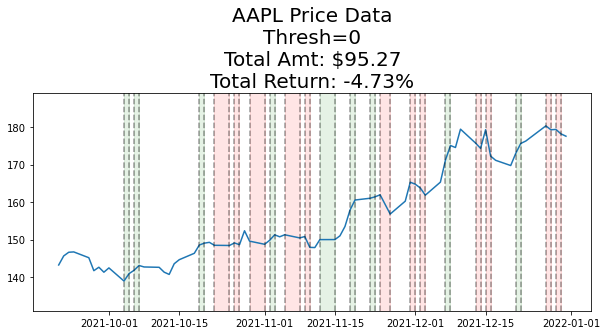

  0%|                                                    | 0/71 [00:00<?, ?it/s]/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.17571D+00    |proj g|=  1.09531D+02


 This problem is unconstrained.



At iterate    5    f= -3.18668D+00    |proj g|=  2.56493D+00

At iterate   10    f= -3.18836D+00    |proj g|=  4.17489D+01

At iterate   15    f= -3.22171D+00    |proj g|=  2.88388D+01

At iterate   20    f= -3.24207D+00    |proj g|=  2.07681D+01

At iterate   25    f= -3.26016D+00    |proj g|=  1.95351D+00

At iterate   30    f= -3.32215D+00    |proj g|=  5.18871D+01

At iterate   35    f= -3.36692D+00    |proj g|=  4.66589D+00

At iterate   40    f= -3.36696D+00    |proj g|=  2.65696D-01

At iterate   45    f= -3.36796D+00    |proj g|=  3.28759D+00

At iterate   50    f= -3.37866D+00    |proj g|=  3.32727D+00

At iterate   55    f= -3.42173D+00    |proj g|=  4.06958D+00

At iterate   60    f= -3.45887D+00    |proj g|=  6.69122D+01

At iterate   65    f= -3.46638D+00    |proj g|=  3.26729D-01

At iterate   70    f= -3.46645D+00    |proj g|=  6.91780D+00

At iterate   75    f= -3.47169D+00    |proj g|=  4.10739D+01

At iterate   80    f= -3.47489D+00    |proj g|=  1.55417D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  175    f= -3.49912D+00    |proj g|=  7.39129D-01

At iterate  180    f= -3.49925D+00    |proj g|=  1.41724D+01

At iterate  185    f= -3.50006D+00    |proj g|=  3.61160D-01

At iterate  190    f= -3.50006D+00    |proj g|=  8.88723D-01

At iterate  195    f= -3.50035D+00    |proj g|=  9.64267D+00

At iterate  200    f= -3.50533D+00    |proj g|=  2.27551D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12    200    267      2     0     0   2.276D+01  -3.505D+00
  F =  -3.5053275525157357     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 13%|█████▌                                      | 9/71 [00:15<01:47,  1.74s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88067D+00    |proj g|=  6.25561D+00

At iterate    5    f= -2.88080D+00    |proj g|=  5.16903D-01

At iterate   10    f= -2.89626D+00    |proj g|=  7.45890D+00

At iterate   15    f= -2.89810D+00    |proj g|=  4.12734D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -2.89817D+00    |proj g|=  2.35377D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     24     76      2     0     0   3.246D-01  -2.898D+00
  F =  -2.8981700316809880     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 15%|██████▋                                    | 11/71 [00:21<01:59,  1.98s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94542D+00    |proj g|=  4.97027D+00


 This problem is unconstrained.



At iterate    5    f= -2.94556D+00    |proj g|=  2.89802D+00

At iterate   10    f= -2.95000D+00    |proj g|=  1.54309D-01

At iterate   15    f= -2.95030D+00    |proj g|=  2.75431D+00

At iterate   20    f= -2.95649D+00    |proj g|=  1.11254D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -2.95650D+00    |proj g|=  3.32901D-01

At iterate   30    f= -2.95650D+00    |proj g|=  2.68163D-01

At iterate   35    f= -2.95651D+00    |proj g|=  1.03963D+00

At iterate   40    f= -2.95707D+00    |proj g|=  1.60626D+01

At iterate   45    f= -2.96316D+00    |proj g|=  1.27309D+01

At iterate   50    f= -2.96321D+00    |proj g|=  5.30476D-01

At iterate   55    f= -2.96325D+00    |proj g|=  2.10629D+00

At iterate   60    f= -2.96342D+00    |proj g|=  3.03864D-01

At iterate   65    f= -2.96343D+00    |proj g|=  1.74594D-01

At iterate   70    f= -2.96351D+00    |proj g|=  9.34342D-01

At iterate   75    f= -2.96545D+00    |proj g|=  3.06036D+00

At iterate   80    f= -2.96567D+00    |proj g|=  4.20299D-01

At iterate   85    f= -2.96568D+00    |proj g|=  1.85298D+00

At iterate   90    f= -2.96581D+00    |proj g|=  8.87944D+00

At iterate   95    f= -2.96881D+00    |proj g|=  9.82530D+00

At iterate  100    f= -2.98241D+00    |proj g|=  7.68078D+00

At iter

 18%|███████▊                                   | 13/71 [00:40<03:46,  3.90s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.19601D+00    |proj g|=  1.52893D+01

At iterate    5    f= -3.19773D+00    |proj g|=  2.36942D+00

At iterate   10    f= -3.20324D+00    |proj g|=  2.04373D+01

At iterate   15    f= -3.20961D+00    |proj g|=  6.80248D-02

At iterate   20    f= -3.21232D+00    |proj g|=  7.20123D+00

At iterate   25    f= -3.22289D+00    |proj g|=  3.73356D-01

At iterate   30    f= -3.22307D+00    |proj g|=  3.56649D+00

At iterate   35    f= -3.22825D+00    |proj g|=  6.69441D+00

At iterate   40    f= -3.22861D+00    |proj g|=  4.19725D-02

At iterate   45    f= -3.23106D+00    |proj g|=  7.03553D-02

At iterate   50    f= -3.23114D+00    |proj g|=  1.00596D+00

At iterate   55    f= -3.23195D+00    |proj g|=  6.45794D-01

At iterate   60    f= -3.23195D+00    |proj g|=  3.15584D-02

At iterate   65    f= -3.2

 20%|████████▍                                  | 14/71 [00:52<04:58,  5.24s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.22147D+00    |proj g|=  1.45871D+01


 This problem is unconstrained.



At iterate    5    f= -3.22320D+00    |proj g|=  3.49399D+00

At iterate   10    f= -3.23171D+00    |proj g|=  1.88295D+01

At iterate   15    f= -3.23534D+00    |proj g|=  8.74274D-02

At iterate   20    f= -3.23565D+00    |proj g|=  2.15422D+00

At iterate   25    f= -3.24400D+00    |proj g|=  7.82907D+00

At iterate   30    f= -3.24965D+00    |proj g|=  8.69973D-01

At iterate   35    f= -3.24981D+00    |proj g|=  4.58058D-01

At iterate   40    f= -3.25026D+00    |proj g|=  6.03924D+00

At iterate   45    f= -3.25103D+00    |proj g|=  1.78280D-02

At iterate   50    f= -3.25104D+00    |proj g|=  5.21247D-02

At iterate   55    f= -3.25109D+00    |proj g|=  2.33970D-01

At iterate   60    f= -3.25111D+00    |proj g|=  1.81007D-02

At iterate   65    f= -3.25111D+00    |proj g|=  1.70901D-01

At iterate   70    f= -3.25113D+00    |proj g|=  2.87160D-01

At iterate   75    f= -3.25114D+00    |proj g|=  7.45759D-03

At iterate   80    f= -3.25114D+00    |proj g|=  8.85432D-02

At iter

 21%|█████████                                  | 15/71 [01:05<06:05,  6.53s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.24660D+00    |proj g|=  1.57190D+01


 This problem is unconstrained.



At iterate    5    f= -3.24824D+00    |proj g|=  1.36199D+00

At iterate   10    f= -3.25033D+00    |proj g|=  1.61033D+01

At iterate   15    f= -3.25995D+00    |proj g|=  1.94609D-01

At iterate   20    f= -3.25997D+00    |proj g|=  5.37930D-01

At iterate   25    f= -3.26194D+00    |proj g|=  5.79570D+00

At iterate   30    f= -3.26564D+00    |proj g|=  1.48129D-01

At iterate   35    f= -3.26573D+00    |proj g|=  6.50019D-01

At iterate   40    f= -3.26800D+00    |proj g|=  2.06872D+00

At iterate   45    f= -3.26913D+00    |proj g|=  1.33197D-02

At iterate   50    f= -3.26915D+00    |proj g|=  4.77977D-01

At iterate   55    f= -3.26998D+00    |proj g|=  3.99707D+00

At iterate   60    f= -3.27030D+00    |proj g|=  1.46158D-01

At iterate   65    f= -3.27030D+00    |proj g|=  9.02380D-02

At iterate   70    f= -3.27033D+00    |proj g|=  7.02394D-01

At iterate   75    f= -3.27050D+00    |proj g|=  4.84991D-01

At iterate   80    f= -3.27052D+00    |proj g|=  6.07892D-03

At iter

 23%|█████████▋                                 | 16/71 [01:18<07:16,  7.93s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.15253D+00    |proj g|=  8.90089D-01

At iterate    5    f= -3.16802D+00    |proj g|=  2.77949D-01

At iterate   10    f= -3.18476D+00    |proj g|=  8.63651D-02

At iterate   15    f= -3.18930D+00    |proj g|=  4.79300D-01

At iterate   20    f= -3.19237D+00    |proj g|=  2.86230D-01

At iterate   25    f= -3.19748D+00    |proj g|=  4.00066D-01

At iterate   30    f= -3.20902D+00    |proj g|=  8.02502D-01

At iterate   35    f= -3.21044D+00    |proj g|=  2.13875D-01

At iterate   40    f= -3.21429D+00    |proj g|=  2.51371D+00

At iterate   45    f= -3.21590D+00    |proj g|=  1.69027D-02

At iterate   50    f= -3.21622D+00    |proj g|=  2.59513D-01

At iterate   55    f= -3.21653D+00    |proj g|=  1.12447D-01

At iterate   60    f= -3.21703D+00    |proj g|=  2.04779D-02

At iterate   65    f= -3.2

 24%|██████████▎                                | 17/71 [01:33<08:39,  9.62s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.16822D+00    |proj g|=  4.29335D+00


 This problem is unconstrained.



At iterate    5    f= -3.16876D+00    |proj g|=  1.10613D+00

At iterate   10    f= -3.17407D+00    |proj g|=  1.12909D+01

At iterate   15    f= -3.18433D+00    |proj g|=  2.30890D+00

At iterate   20    f= -3.19627D+00    |proj g|=  7.84206D+00

At iterate   25    f= -3.20062D+00    |proj g|=  8.65689D-02

At iterate   30    f= -3.20076D+00    |proj g|=  2.56700D+00

At iterate   35    f= -3.20603D+00    |proj g|=  7.49804D+00

At iterate   40    f= -3.20697D+00    |proj g|=  3.11613D-02

At iterate   45    f= -3.21355D+00    |proj g|=  1.31447D+00

At iterate   50    f= -3.21443D+00    |proj g|=  4.83712D-01

At iterate   55    f= -3.21736D+00    |proj g|=  4.75794D+00

At iterate   60    f= -3.22154D+00    |proj g|=  1.52711D+00

At iterate   65    f= -3.22206D+00    |proj g|=  4.06964D-01

At iterate   70    f= -3.22227D+00    |proj g|=  5.43397D-02

At iterate   75    f= -3.22236D+00    |proj g|=  4.63764D-01

At iterate   80    f= -3.22420D+00    |proj g|=  1.20486D+00

At iter

 25%|██████████▉                                | 18/71 [01:48<09:36, 10.88s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.13783D+00    |proj g|=  9.48922D+00

At iterate    5    f= -3.16281D+00    |proj g|=  3.56892D+00

At iterate   10    f= -3.17449D+00    |proj g|=  2.40069D+00

At iterate   15    f= -3.18524D+00    |proj g|=  8.21460D-02

At iterate   20    f= -3.18779D+00    |proj g|=  3.09858D+00

At iterate   25    f= -3.19213D+00    |proj g|=  3.32892D-02

At iterate   30    f= -3.19515D+00    |proj g|=  1.25223D-01

At iterate   35    f= -3.19520D+00    |proj g|=  2.26859D-01

At iterate   40    f= -3.19640D+00    |proj g|=  3.32058D-01

At iterate   45    f= -3.19678D+00    |proj g|=  3.92708D-03

At iterate   50    f= -3.19687D+00    |proj g|=  3.84934D-01

At iterate   55    f= -3.19693D+00    |proj g|=  2.32525D-03

At iterate   60    f= -3.19693D+00    |proj g|=  2.15364D-02

At iterate   65    f= -3.1

 27%|███████████▌                               | 19/71 [02:01<09:57, 11.50s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30800D+00    |proj g|=  4.70516D-01


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f= -2.71786D+00    |proj g|=  1.80149D-01

At iterate   10    f= -3.02194D+00    |proj g|=  4.61593D-02

At iterate   15    f= -3.04520D+00    |proj g|=  1.51650D-02

At iterate   20    f= -3.07217D+00    |proj g|=  4.78680D-02

At iterate   25    f= -3.10237D+00    |proj g|=  4.82638D-01

At iterate   30    f= -3.12911D+00    |proj g|=  7.09350D-02

At iterate   35    f= -3.14730D+00    |proj g|=  1.47700D+00

At iterate   40    f= -3.15368D+00    |proj g|=  9.82143D-02

At iterate   45    f= -3.17254D+00    |proj g|=  2.97050D+00

At iterate   50    f= -3.17464D+00    |proj g|=  3.23182D-01

At iterate   55    f= -3.17511D+00    |proj g|=  1.26338D-02

At iterate   60    f= -3.17533D+00    |proj g|=  1.99025D-01

At iterate   65    f= -3.17617D+00    |proj g|=  1.28989D-02

At iterate   70    f= -3.17634D+00    |proj g|=  5.84062D-03

At iterate   75    f= -3.17660D+00    |proj g|=  4.12705D-03

At iterate   80    f= -3.17660D+00    |proj g|=  3.99738D-02

At iter

 28%|████████████                               | 20/71 [02:16<10:25, 12.26s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.06758D+00    |proj g|=  8.76463D+00

At iterate    5    f= -3.15141D+00    |proj g|=  6.78414D-01

At iterate   10    f= -3.16805D+00    |proj g|=  5.42992D-02

At iterate   15    f= -3.17004D+00    |proj g|=  8.48233D-01

At iterate   20    f= -3.18398D+00    |proj g|=  9.17920D-02

At iterate   25    f= -3.19740D+00    |proj g|=  8.38802D-01

At iterate   30    f= -3.19825D+00    |proj g|=  8.68495D-01

At iterate   35    f= -3.20375D+00    |proj g|=  5.56121D-02

At iterate   40    f= -3.20463D+00    |proj g|=  5.61984D-01

At iterate   45    f= -3.20675D+00    |proj g|=  1.80260D-01

At iterate   50    f= -3.20679D+00    |proj g|=  1.62205D-02

At iterate   55    f= -3.20685D+00    |proj g|=  4.65670D-01

At iterate   60    f= -3.20751D+00    |proj g|=  9.36706D-01

At iterate   65    f= -3.2

 31%|█████████████▎                             | 22/71 [02:28<07:51,  9.63s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.17752D+00    |proj g|=  9.33637D+00

At iterate    5    f= -3.19626D+00    |proj g|=  1.48441D+00

At iterate   10    f= -3.20736D+00    |proj g|=  5.20842D-02

At iterate   15    f= -3.20830D+00    |proj g|=  1.21214D+00

At iterate   20    f= -3.21647D+00    |proj g|=  1.61662D+00

At iterate   25    f= -3.21840D+00    |proj g|=  6.92870D-01

At iterate   30    f= -3.22001D+00    |proj g|=  1.19407D-01

At iterate   35    f= -3.22060D+00    |proj g|=  5.37845D-01

At iterate   40    f= -3.22091D+00    |proj g|=  1.84005D-01

At iterate   45    f= -3.22134D+00    |proj g|=  2.14965D-02

At iterate   50    f= -3.22135D+00    |proj g|=  8.34555D-03

At iterate   55    f= -3.22149D+00    |proj g|=  5.66683D-01

At iterate   60    f= -3.22157D+00    |proj g|=  7.17082D-02

At iterate   65    f= -3.2

 32%|█████████████▉                             | 23/71 [02:43<08:40, 10.85s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.16153D+00    |proj g|=  9.89242D+00

At iterate    5    f= -3.18768D+00    |proj g|=  6.89751D-01

At iterate   10    f= -3.19858D+00    |proj g|=  1.40105D+00

At iterate   15    f= -3.20325D+00    |proj g|=  2.09687D+00

At iterate   20    f= -3.20570D+00    |proj g|=  4.26860D-01

At iterate   25    f= -3.20831D+00    |proj g|=  1.17356D-01

At iterate   30    f= -3.20849D+00    |proj g|=  4.09914D-01

At iterate   35    f= -3.20945D+00    |proj g|=  1.12132D-01

At iterate   40    f= -3.20953D+00    |proj g|=  5.42555D-02

At iterate   45    f= -3.21005D+00    |proj g|=  4.51172D-03

At iterate   50    f= -3.21006D+00    |proj g|=  1.72723D-01

At iterate   55    f= -3.21016D+00    |proj g|=  4.31595D-02

At iterate   60    f= -3.21016D+00    |proj g|=  1.85354D-03

At iterate   65    f= -3.2

 35%|███████████████▏                           | 25/71 [02:55<06:53,  8.98s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.15208D+00    |proj g|=  1.00790D+01


 This problem is unconstrained.



At iterate    5    f= -3.17469D+00    |proj g|=  5.61024D-01

At iterate   10    f= -3.18184D+00    |proj g|=  2.30152D+00

At iterate   15    f= -3.18313D+00    |proj g|=  4.89294D-02

At iterate   20    f= -3.18708D+00    |proj g|=  7.81020D-01

At iterate   25    f= -3.18744D+00    |proj g|=  5.39516D-02

At iterate   30    f= -3.18746D+00    |proj g|=  2.32142D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f= -3.18793D+00    |proj g|=  6.04989D-02

At iterate   40    f= -3.18795D+00    |proj g|=  2.61395D-01

At iterate   45    f= -3.18807D+00    |proj g|=  2.17928D-02

At iterate   50    f= -3.18809D+00    |proj g|=  4.67566D-02

At iterate   55    f= -3.18822D+00    |proj g|=  4.40371D-02

At iterate   60    f= -3.18822D+00    |proj g|=  2.29736D-02

At iterate   65    f= -3.18829D+00    |proj g|=  2.74957D-02

At iterate   70    f= -3.18829D+00    |proj g|=  2.16634D-02

At iterate   75    f= -3.18830D+00    |proj g|=  8.95186D-03

At iterate   80    f= -3.18830D+00    |proj g|=  7.98788D-03

At iterate   85    f= -3.18831D+00    |proj g|=  1.89642D-02

At iterate   90    f= -3.18831D+00    |proj g|=  1.93414D-03

At iterate   95    f= -3.18831D+00    |proj g|=  9.83369D-03

At iterate  100    f= -3.18831D+00    |proj g|=  4.16973D-03

At iterate  105    f= -3.18831D+00    |proj g|=  7.97407D-04

At iterate  110    f= -3.18831D+00    |proj g|=  2.56906D-04

At iter

 38%|████████████████▎                          | 27/71 [03:12<06:25,  8.76s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.16016D+00    |proj g|=  8.50383D+00

At iterate    5    f= -3.17594D+00    |proj g|=  1.04342D-01

At iterate   10    f= -3.17892D+00    |proj g|=  1.03286D+00

At iterate   15    f= -3.17938D+00    |proj g|=  2.57272D-01

At iterate   20    f= -3.18007D+00    |proj g|=  2.27753D-01

At iterate   25    f= -3.18028D+00    |proj g|=  1.25165D-01

At iterate   30    f= -3.18052D+00    |proj g|=  8.80078D-02

At iterate   35    f= -3.18052D+00    |proj g|=  1.78008D-02

At iterate   40    f= -3.18052D+00    |proj g|=  5.51109D-02

At iterate   45    f= -3.18053D+00    |proj g|=  2.21192D-03

At iterate   50    f= -3.18055D+00    |proj g|=  3.23892D-02

At iterate   55    f= -3.18056D+00    |proj g|=  4.36207D-03

At iterate   60    f= -3.18057D+00    |proj g|=  4.60739D-02

At iterate   65    f= -3.1

 39%|████████████████▉                          | 28/71 [03:25<06:54,  9.65s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.10915D+00    |proj g|=  8.26552D+00

At iterate    5    f= -3.12428D+00    |proj g|=  1.87800D+00

At iterate   10    f= -3.12473D+00    |proj g|=  1.27744D-01

At iterate   15    f= -3.12587D+00    |proj g|=  1.72927D+00

At iterate   20    f= -3.12892D+00    |proj g|=  1.01666D-01

At iterate   25    f= -3.12895D+00    |proj g|=  2.02518D-01

At iterate   30    f= -3.13015D+00    |proj g|=  5.44420D-01

At iterate   35    f= -3.13032D+00    |proj g|=  1.55733D-01

At iterate   40    f= -3.13182D+00    |proj g|=  9.43553D-02

At iterate   45    f= -3.13239D+00    |proj g|=  3.45808D-03

At iterate   50    f= -3.13244D+00    |proj g|=  2.95212D-01

At iterate   55    f= -3.13248D+00    |proj g|=  6.77192D-03

At iterate   60    f= -3.13249D+00    |proj g|=  6.32064D-02

At iterate   65    f= -3.1

 42%|██████████████████▏                        | 30/71 [03:41<06:07,  8.95s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.11597D+00    |proj g|=  7.62954D+00


 This problem is unconstrained.



At iterate    5    f= -3.12436D+00    |proj g|=  3.47915D+00

At iterate   10    f= -3.12962D+00    |proj g|=  2.36284D-02

At iterate   15    f= -3.13195D+00    |proj g|=  4.04602D-01

At iterate   20    f= -3.13498D+00    |proj g|=  2.12507D-02

At iterate   25    f= -3.13824D+00    |proj g|=  1.35358D+00

At iterate   30    f= -3.13872D+00    |proj g|=  2.08035D-01

At iterate   35    f= -3.13961D+00    |proj g|=  1.78442D+00

At iterate   40    f= -3.14226D+00    |proj g|=  8.44991D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f= -3.14233D+00    |proj g|=  2.76043D-01

At iterate   50    f= -3.14294D+00    |proj g|=  1.04045D+00

At iterate   55    f= -3.14311D+00    |proj g|=  5.88182D-02

At iterate   60    f= -3.14340D+00    |proj g|=  3.13122D-01

At iterate   65    f= -3.14341D+00    |proj g|=  6.92646D-03

At iterate   70    f= -3.14343D+00    |proj g|=  2.22697D-02

At iterate   75    f= -3.14344D+00    |proj g|=  1.70337D-02

At iterate   80    f= -3.14344D+00    |proj g|=  2.69003D-02

At iterate   85    f= -3.14345D+00    |proj g|=  3.63243D-02

At iterate   90    f= -3.14345D+00    |proj g|=  8.73559D-03

At iterate   95    f= -3.14345D+00    |proj g|=  2.87246D-03

At iterate  100    f= -3.14345D+00    |proj g|=  3.40838D-04

At iterate  105    f= -3.14345D+00    |proj g|=  2.20872D-03

At iterate  110    f= -3.14345D+00    |proj g|=  5.64881D-05

At iterate  115    f= -3.14345D+00    |proj g|=  8.30447D-06

At iterate  120    f= -3.14345D+00    |proj g|=  6.48814D-05

       

 45%|███████████████████▍                       | 32/71 [03:51<04:55,  7.57s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.12540D+00    |proj g|=  7.74708D+00

At iterate    5    f= -3.13441D+00    |proj g|=  3.58278D+00

At iterate   10    f= -3.13923D+00    |proj g|=  1.81357D-01

At iterate   15    f= -3.14008D+00    |proj g|=  1.34306D+00

At iterate   20    f= -3.14437D+00    |proj g|=  1.65642D-01

At iterate   25    f= -3.14877D+00    |proj g|=  1.17243D-01

At iterate   30    f= -3.15091D+00    |proj g|=  8.99285D-01

At iterate   35    f= -3.15169D+00    |proj g|=  1.22725D-02

At iterate   40    f= -3.15278D+00    |proj g|=  4.74853D-01

At iterate   45    f= -3.15305D+00    |proj g|=  2.08242D-02

At iterate   50    f= -3.15308D+00    |proj g|=  1.62645D-01

At iterate   55    f= -3.15317D+00    |proj g|=  2.05529D-02

At iterate   60    f= -3.15317D+00    |proj g|=  1.40838D-03

At iterate   65    f= -3.1

 46%|███████████████████▉                       | 33/71 [04:02<05:20,  8.42s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.13897D+00    |proj g|=  7.18017D+00

At iterate    5    f= -3.14466D+00    |proj g|=  2.45608D+00

At iterate   10    f= -3.15157D+00    |proj g|=  7.95942D-02

At iterate   15    f= -3.15695D+00    |proj g|=  2.43632D+00

At iterate   20    f= -3.15761D+00    |proj g|=  3.01213D-01

At iterate   25    f= -3.16024D+00    |proj g|=  6.82369D-01

At iterate   30    f= -3.16044D+00    |proj g|=  5.24198D-02

At iterate   35    f= -3.16059D+00    |proj g|=  1.10990D+00

At iterate   40    f= -3.16129D+00    |proj g|=  6.69044D-01

At iterate   45    f= -3.16135D+00    |proj g|=  1.06749D-01

At iterate   50    f= -3.16136D+00    |proj g|=  9.17299D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   55    f= -3.16140D+00    |proj g|=  7.64596D-02

At iterate   60    f= -3.16140D+00    |proj g|=  5.27369D-02

At iterate   65    f= -3.16142D+00    |proj g|=  2.81025D-01

At iterate   70    f= -3.16144D+00    |proj g|=  4.93663D-02

At iterate   75    f= -3.16144D+00    |proj g|=  3.87295D-03

At iterate   80    f= -3.16144D+00    |proj g|=  4.45588D-02

At iterate   85    f= -3.16144D+00    |proj g|=  3.04285D-03

At iterate   90    f= -3.16144D+00    |proj g|=  4.05871D-03

At iterate   95    f= -3.16144D+00    |proj g|=  5.88862D-05

At iterate  100    f= -3.16144D+00    |proj g|=  3.66507D-04

At iterate  105    f= -3.16144D+00    |proj g|=  3.57563D-03

At iterate  110    f= -3.16144D+00    |proj g|=  1.18305D-04

At iterate  115    f= -3.16144D+00    |proj g|=  1.89893D-04

At iterate  120    f= -3.16144D+00    |proj g|=  1.33591D-03

At iterate  125    f= -3.16144D+00    |proj g|=  3.94795D-05

At iterate  130    f= -3.16144D+00    |proj g|=  5.08038D-05

At iter

 48%|████████████████████▌                      | 34/71 [04:15<05:43,  9.28s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.13851D+00    |proj g|=  7.57481D+00

At iterate    5    f= -3.14691D+00    |proj g|=  3.46049D+00

At iterate   10    f= -3.15275D+00    |proj g|=  2.79001D-02

At iterate   15    f= -3.15643D+00    |proj g|=  9.57808D-02

At iterate   20    f= -3.15734D+00    |proj g|=  9.04321D-03

At iterate   25    f= -3.15807D+00    |proj g|=  8.99845D-03

At iterate   30    f= -3.15811D+00    |proj g|=  1.25429D-03

At iterate   35    f= -3.15811D+00    |proj g|=  2.93277D-04

At iterate   40    f= -3.15811D+00    |proj g|=  3.63087D-04

At iterate   45    f= -3.15811D+00    |proj g|=  1.10667D-04

At iterate   50    f= -3.15811D+00    |proj g|=  1.31006D-05

At iterate   55    f= -3.15811D+00    |proj g|=  6.17284D-05

At iterate   60    f= -3.15811D+00    |proj g|=  2.90878D-05

           * * *

Tit   = 

 49%|█████████████████████▏                     | 35/71 [04:20<05:02,  8.40s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.11557D+00    |proj g|=  4.14866D+00

At iterate    5    f= -3.11715D+00    |proj g|=  5.04409D-01

At iterate   10    f= -3.12049D+00    |proj g|=  4.36496D+00

At iterate   15    f= -3.12371D+00    |proj g|=  1.50833D-02

At iterate   20    f= -3.12535D+00    |proj g|=  8.34663D-02

At iterate   25    f= -3.12547D+00    |proj g|=  1.90451D-02

At iterate   30    f= -3.12561D+00    |proj g|=  6.26117D-03

At iterate   35    f= -3.12562D+00    |proj g|=  1.75399D-02

At iterate   40    f= -3.12562D+00    |proj g|=  8.97504D-04

At iterate   45    f= -3.12562D+00    |proj g|=  2.22631D-03

At iterate   50    f= -3.12562D+00    |proj g|=  7.61746D-04

At iterate   55    f= -3.12562D+00    |proj g|=  1.23190D-03

At iterate   60    f= -3.12562D+00    |proj g|=  5.07594D-05

At iterate   65    f= -3.1

 52%|██████████████████████▍                    | 37/71 [04:27<03:38,  6.43s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.07909D+00    |proj g|=  6.29911D+00

At iterate    5    f= -3.08292D+00    |proj g|=  1.42361D+00

At iterate   10    f= -3.09064D+00    |proj g|=  1.45426D+00

At iterate   15    f= -3.09283D+00    |proj g|=  9.17013D-03

At iterate   20    f= -3.09317D+00    |proj g|=  7.91687D-03

At iterate   25    f= -3.09320D+00    |proj g|=  6.33512D-02

At iterate   30    f= -3.09323D+00    |proj g|=  3.97620D-03

At iterate   35    f= -3.09323D+00    |proj g|=  2.21333D-02

At iterate   40    f= -3.09323D+00    |proj g|=  2.53397D-04

At iterate   45    f= -3.09323D+00    |proj g|=  1.13362D-02

At iterate   50    f= -3.09323D+00    |proj g|=  7.36144D-03

At iterate   55    f= -3.09323D+00    |proj g|=  1.48459D-04

At iterate   60    f= -3.09323D+00    |proj g|=  2.86327D-03

At iterate   65    f= -3.0

 54%|███████████████████████                    | 38/71 [04:36<03:50,  6.97s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.09734D+00    |proj g|=  6.62389D+00

At iterate    5    f= -3.10175D+00    |proj g|=  1.98845D+00

At iterate   10    f= -3.10916D+00    |proj g|=  4.26939D-01

At iterate   15    f= -3.10965D+00    |proj g|=  9.96880D-02

At iterate   20    f= -3.11103D+00    |proj g|=  1.07638D-02

At iterate   25    f= -3.11112D+00    |proj g|=  3.86981D-01

At iterate   30    f= -3.11135D+00    |proj g|=  5.95537D-03

At iterate   35    f= -3.11139D+00    |proj g|=  4.05045D-03

At iterate   40    f= -3.11141D+00    |proj g|=  1.44280D-03

At iterate   45    f= -3.11141D+00    |proj g|=  9.89875D-05

At iterate   50    f= -3.11141D+00    |proj g|=  3.42393D-05

At iterate   55    f= -3.11141D+00    |proj g|=  5.87530D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

 56%|████████████████████████▏                  | 40/71 [04:41<02:40,  5.17s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08148D+00    |proj g|=  6.82819D+00


 This problem is unconstrained.



At iterate    5    f= -3.08717D+00    |proj g|=  2.37210D+00

At iterate   10    f= -3.09317D+00    |proj g|=  1.44212D-01

At iterate   15    f= -3.09357D+00    |proj g|=  9.13543D-01

At iterate   20    f= -3.09531D+00    |proj g|=  1.26807D-01

At iterate   25    f= -3.09536D+00    |proj g|=  2.09037D-01

At iterate   30    f= -3.09593D+00    |proj g|=  1.09437D-01

At iterate   35    f= -3.09594D+00    |proj g|=  5.56102D-03

At iterate   40    f= -3.09596D+00    |proj g|=  1.79520D-01

At iterate   45    f= -3.09608D+00    |proj g|=  3.68313D-02

At iterate   50    f= -3.09608D+00    |proj g|=  7.82743D-03

At iterate   55    f= -3.09608D+00    |proj g|=  1.52397D-02

At iterate   60    f= -3.09609D+00    |proj g|=  2.85998D-03

At iterate   65    f= -3.09609D+00    |proj g|=  1.23288D-03

At iterate   70    f= -3.09609D+00    |proj g|=  4.46851D-03

At iterate   75    f= -3.09609D+00    |proj g|=  2.36233D-03

At iterate   80    f= -3.09609D+00    |proj g|=  5.80869D-05

At iter

 58%|████████████████████████▊                  | 41/71 [04:50<02:59,  5.98s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.03871D+00    |proj g|=  5.25109D+00


 This problem is unconstrained.



At iterate    5    f= -3.04282D+00    |proj g|=  6.68588D-01

At iterate   10    f= -3.04760D+00    |proj g|=  1.90422D+00

At iterate   15    f= -3.04949D+00    |proj g|=  4.47878D-01

At iterate   20    f= -3.05055D+00    |proj g|=  5.29561D-02

At iterate   25    f= -3.05088D+00    |proj g|=  1.94421D-01

At iterate   30    f= -3.05091D+00    |proj g|=  2.75267D-02

At iterate   35    f= -3.05097D+00    |proj g|=  7.84635D-03

At iterate   40    f= -3.05098D+00    |proj g|=  2.19359D-02

At iterate   45    f= -3.05098D+00    |proj g|=  5.74978D-02

At iterate   50    f= -3.05099D+00    |proj g|=  1.73427D-02

At iterate   55    f= -3.05099D+00    |proj g|=  1.56359D-03

At iterate   60    f= -3.05099D+00    |proj g|=  8.75073D-03

At iterate   65    f= -3.05099D+00    |proj g|=  7.79776D-04

At iterate   70    f= -3.05099D+00    |proj g|=  2.33458D-04

At iterate   75    f= -3.05099D+00    |proj g|=  3.48699D-04

At iterate   80    f= -3.05099D+00    |proj g|=  1.64024D-03

At iter

 59%|█████████████████████████▍                 | 42/71 [04:58<03:09,  6.54s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.03496D+00    |proj g|=  4.02101D+00

At iterate    5    f= -3.03838D+00    |proj g|=  4.29181D-01

At iterate   10    f= -3.04211D+00    |proj g|=  2.36312D+00

At iterate   15    f= -3.04350D+00    |proj g|=  5.94796D-02

At iterate   20    f= -3.04539D+00    |proj g|=  2.98317D-01

At iterate   25    f= -3.04590D+00    |proj g|=  2.03204D-02

At iterate   30    f= -3.04612D+00    |proj g|=  3.34723D-03

At iterate   35    f= -3.04612D+00    |proj g|=  1.77285D-02

At iterate   40    f= -3.04612D+00    |proj g|=  6.03650D-04

At iterate   45    f= -3.04612D+00    |proj g|=  5.60352D-04

At iterate   50    f= -3.04612D+00    |proj g|=  6.90115D-05

At iterate   55    f= -3.04612D+00    |proj g|=  1.37668D-05

At iterate   60    f= -3.04612D+00    |proj g|=  2.17604D-06

           * * *

Tit   = 

 61%|██████████████████████████                 | 43/71 [05:03<02:53,  6.20s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.05228D+00    |proj g|=  4.36385D+00

At iterate    5    f= -3.05557D+00    |proj g|=  3.60173D-01

At iterate   10    f= -3.05856D+00    |proj g|=  2.83059D+00

At iterate   15    f= -3.06066D+00    |proj g|=  1.72969D-02

At iterate   20    f= -3.06270D+00    |proj g|=  1.05755D-01

At iterate   25    f= -3.06291D+00    |proj g|=  4.19611D-03

At iterate   30    f= -3.06295D+00    |proj g|=  2.33801D-01

At iterate   35    f= -3.06297D+00    |proj g|=  2.13345D-03

At iterate   40    f= -3.06297D+00    |proj g|=  7.22644D-03

At iterate   45    f= -3.06298D+00    |proj g|=  4.01497D-03

At iterate   50    f= -3.06298D+00    |proj g|=  8.14815D-04

At iterate   55    f= -3.06298D+00    |proj g|=  2.96070D-03

At iterate   60    f= -3.06298D+00    |proj g|=  4.75620D-05

At iterate   65    f= -3.0

 63%|███████████████████████████▎               | 45/71 [05:11<02:14,  5.17s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.05548D+00    |proj g|=  4.13162D+00

At iterate    5    f= -3.05897D+00    |proj g|=  4.22945D-01

At iterate   10    f= -3.06266D+00    |proj g|=  2.46666D+00

At iterate   15    f= -3.06427D+00    |proj g|=  1.51522D-01

At iterate   20    f= -3.06553D+00    |proj g|=  6.45057D-01

At iterate   25    f= -3.06631D+00    |proj g|=  3.94638D-02

At iterate   30    f= -3.06633D+00    |proj g|=  1.46140D-02

At iterate   35    f= -3.06637D+00    |proj g|=  8.09424D-03

At iterate   40    f= -3.06638D+00    |proj g|=  8.95328D-03

At iterate   45    f= -3.06638D+00    |proj g|=  1.46794D-02

At iterate   50    f= -3.06638D+00    |proj g|=  2.95763D-05

At iterate   55    f= -3.06638D+00    |proj g|=  1.54232D-04

At iterate   60    f= -3.06638D+00    |proj g|=  5.53335D-05

At iterate   65    f= -3.0

 65%|███████████████████████████▊               | 46/71 [05:17<02:15,  5.42s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.01813D+00    |proj g|=  3.92611D+00

At iterate    5    f= -3.01978D+00    |proj g|=  2.59857D-01

At iterate   10    f= -3.02110D+00    |proj g|=  2.89024D+00

At iterate   15    f= -3.02362D+00    |proj g|=  6.40584D-02

At iterate   20    f= -3.02413D+00    |proj g|=  3.77333D-01

At iterate   25    f= -3.02508D+00    |proj g|=  1.19259D-01

At iterate   30    f= -3.02518D+00    |proj g|=  4.55316D-03

At iterate   35    f= -3.02520D+00    |proj g|=  9.48293D-02

At iterate   40    f= -3.02531D+00    |proj g|=  1.03661D-01

At iterate   45    f= -3.02532D+00    |proj g|=  5.95506D-03

At iterate   50    f= -3.02533D+00    |proj g|=  1.30180D-02

At iterate   55    f= -3.02533D+00    |proj g|=  3.97886D-03

At iterate   60    f= -3.02533D+00    |proj g|=  9.84102D-05

At iterate   65    f= -3.0

 66%|████████████████████████████▍              | 47/71 [05:29<02:46,  6.93s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.00091D+00    |proj g|=  4.86658D+00

At iterate    5    f= -3.00463D+00    |proj g|=  4.82178D-01

At iterate   10    f= -3.00744D+00    |proj g|=  1.55866D+00

At iterate   15    f= -3.00790D+00    |proj g|=  4.21101D-02

At iterate   20    f= -3.00971D+00    |proj g|=  3.38508D-01

At iterate   25    f= -3.00981D+00    |proj g|=  2.66676D-01

At iterate   30    f= -3.01009D+00    |proj g|=  1.17679D-01

At iterate   35    f= -3.01024D+00    |proj g|=  2.09487D-01

At iterate   40    f= -3.01026D+00    |proj g|=  6.75895D-03

At iterate   45    f= -3.01027D+00    |proj g|=  2.53850D-03

At iterate   50    f= -3.01027D+00    |proj g|=  1.35407D-03

At iterate   55    f= -3.01027D+00    |proj g|=  1.14952D-03

At iterate   60    f= -3.01027D+00    |proj g|=  7.27862D-05

At iterate   65    f= -3.0

 68%|█████████████████████████████              | 48/71 [05:39<02:59,  7.81s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.96208D+00    |proj g|=  5.32284D+00

At iterate    5    f= -2.97091D+00    |proj g|=  3.58941D-01

At iterate   10    f= -2.97443D+00    |proj g|=  1.39818D+00

At iterate   15    f= -2.97509D+00    |proj g|=  4.40672D-02

At iterate   20    f= -2.97746D+00    |proj g|=  3.78474D-01

At iterate   25    f= -2.97766D+00    |proj g|=  3.04649D-02

At iterate   30    f= -2.97852D+00    |proj g|=  4.67638D-02

At iterate   35    f= -2.97863D+00    |proj g|=  1.55937D-02

At iterate   40    f= -2.97869D+00    |proj g|=  2.71233D-02

At iterate   45    f= -2.97872D+00    |proj g|=  1.06537D-02

At iterate   50    f= -2.97873D+00    |proj g|=  1.58900D-03

At iterate   55    f= -2.97873D+00    |proj g|=  2.76916D-03

At iterate   60    f= -2.97873D+00    |proj g|=  1.31153D-03

At iterate   65    f= -2.9

 69%|█████████████████████████████▋             | 49/71 [05:47<02:55,  7.96s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.96813D+00    |proj g|=  5.10310D+00


 This problem is unconstrained.



At iterate    5    f= -2.97277D+00    |proj g|=  5.93338D-01

At iterate   10    f= -2.97764D+00    |proj g|=  1.02075D+00

At iterate   15    f= -2.97979D+00    |proj g|=  1.32934D-01

At iterate   20    f= -2.97991D+00    |proj g|=  2.12805D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -2.98106D+00    |proj g|=  3.74761D-02

At iterate   30    f= -2.98107D+00    |proj g|=  2.11273D-01

At iterate   35    f= -2.98148D+00    |proj g|=  6.52566D-01

At iterate   40    f= -2.98156D+00    |proj g|=  1.72332D-02

At iterate   45    f= -2.98204D+00    |proj g|=  3.98492D-01

At iterate   50    f= -2.98235D+00    |proj g|=  1.56066D-01

At iterate   55    f= -2.98249D+00    |proj g|=  1.24811D-02

At iterate   60    f= -2.98252D+00    |proj g|=  1.17372D-02

At iterate   65    f= -2.98252D+00    |proj g|=  2.18559D-02

At iterate   70    f= -2.98253D+00    |proj g|=  1.71201D-03

At iterate   75    f= -2.98253D+00    |proj g|=  3.57940D-03

At iterate   80    f= -2.98253D+00    |proj g|=  3.07399D-04

At iterate   85    f= -2.98253D+00    |proj g|=  5.94325D-04

At iterate   90    f= -2.98253D+00    |proj g|=  2.52687D-05

At iterate   95    f= -2.98253D+00    |proj g|=  7.02682D-04

At iterate  100    f= -2.98253D+00    |proj g|=  3.24185D-05

At iter

 72%|██████████████████████████████▉            | 51/71 [05:59<02:19,  6.96s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.96534D+00    |proj g|=  5.04473D+00

At iterate    5    f= -2.96916D+00    |proj g|=  6.25162D-01

At iterate   10    f= -2.97310D+00    |proj g|=  1.50846D+00

At iterate   15    f= -2.97376D+00    |proj g|=  7.31740D-01

At iterate   20    f= -2.97606D+00    |proj g|=  8.12220D-01

At iterate   25    f= -2.97626D+00    |proj g|=  1.50634D-02

At iterate   30    f= -2.97723D+00    |proj g|=  7.03890D-02

At iterate   35    f= -2.97724D+00    |proj g|=  7.69544D-02

At iterate   40    f= -2.97740D+00    |proj g|=  5.83737D-02

At iterate   45    f= -2.97744D+00    |proj g|=  1.61969D-02

At iterate   50    f= -2.97745D+00    |proj g|=  2.12816D-03

At iterate   55    f= -2.97746D+00    |proj g|=  1.23838D-02

At iterate   60    f= -2.97746D+00    |proj g|=  2.07097D-02

At iterate   65    f= -2.9

 75%|████████████████████████████████           | 53/71 [06:10<01:55,  6.42s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.92398D+00    |proj g|=  4.73437D+00

At iterate    5    f= -2.92873D+00    |proj g|=  3.83986D-01

At iterate   10    f= -2.93187D+00    |proj g|=  1.96514D+00

At iterate   15    f= -2.93286D+00    |proj g|=  7.48654D-02

At iterate   20    f= -2.93581D+00    |proj g|=  3.76436D-01

At iterate   25    f= -2.93731D+00    |proj g|=  3.73542D-02

At iterate   30    f= -2.93915D+00    |proj g|=  4.49703D-02

At iterate   35    f= -2.93955D+00    |proj g|=  1.87949D-02

At iterate   40    f= -2.93970D+00    |proj g|=  1.56190D-02

At iterate   45    f= -2.93974D+00    |proj g|=  2.54943D-03

At iterate   50    f= -2.93974D+00    |proj g|=  7.15294D-04

At iterate   55    f= -2.93974D+00    |proj g|=  3.72173D-03

At iterate   60    f= -2.93974D+00    |proj g|=  2.63656D-04

At iterate   65    f= -2.9

 76%|████████████████████████████████▋          | 54/71 [06:20<02:04,  7.32s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.92538D+00    |proj g|=  4.71144D+00

At iterate    5    f= -2.92983D+00    |proj g|=  4.13932D-01

At iterate   10    f= -2.93232D+00    |proj g|=  9.37901D-01

At iterate   15    f= -2.93445D+00    |proj g|=  1.81476D+00

At iterate   20    f= -2.93592D+00    |proj g|=  1.49811D-02

At iterate   25    f= -2.93634D+00    |proj g|=  3.80897D-02

At iterate   30    f= -2.93813D+00    |proj g|=  2.36999D-02

At iterate   35    f= -2.93990D+00    |proj g|=  8.09219D-01

At iterate   40    f= -2.94103D+00    |proj g|=  1.97893D-02

At iterate   45    f= -2.94133D+00    |proj g|=  2.30837D-01

At iterate   50    f= -2.94251D+00    |proj g|=  3.46370D-02

At iterate   55    f= -2.94283D+00    |proj g|=  5.60646D-02

At iterate   60    f= -2.94289D+00    |proj g|=  3.72165D-01

At iterate   65    f= -2.9

 79%|█████████████████████████████████▉         | 56/71 [06:33<01:42,  6.84s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88670D+00    |proj g|=  3.62243D+00


 This problem is unconstrained.



At iterate    5    f= -2.89410D+00    |proj g|=  1.31512D+00

At iterate   10    f= -2.89537D+00    |proj g|=  3.75054D-02

At iterate   15    f= -2.89669D+00    |proj g|=  6.21799D-01

At iterate   20    f= -2.89827D+00    |proj g|=  9.37197D-03

At iterate   25    f= -2.89857D+00    |proj g|=  6.45731D-02

At iterate   30    f= -2.89862D+00    |proj g|=  9.59486D-03

At iterate   35    f= -2.89864D+00    |proj g|=  9.14291D-04

At iterate   40    f= -2.89865D+00    |proj g|=  1.19309D-03

At iterate   45    f= -2.89865D+00    |proj g|=  1.64055D-03

At iterate   50    f= -2.89865D+00    |proj g|=  8.50164D-04

At iterate   55    f= -2.89865D+00    |proj g|=  3.54827D-05

At iterate   60    f= -2.89865D+00    |proj g|=  4.26770D-05

At iterate   65    f= -2.89865D+00    |proj g|=  3.57936D-05

At iterate   70    f= -2.89865D+00    |proj g|=  6.48814D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 80%|██████████████████████████████████▌        | 57/71 [06:40<01:38,  7.06s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.89037D+00    |proj g|=  3.94126D+00

At iterate    5    f= -2.89545D+00    |proj g|=  6.55835D-01

At iterate   10    f= -2.89953D+00    |proj g|=  5.06644D-01

At iterate   15    f= -2.90155D+00    |proj g|=  3.97379D-02

At iterate   20    f= -2.90180D+00    |proj g|=  1.87735D-01

At iterate   25    f= -2.90223D+00    |proj g|=  6.32037D-02

At iterate   30    f= -2.90225D+00    |proj g|=  1.24421D-01

At iterate   35    f= -2.90232D+00    |proj g|=  4.39879D-03

At iterate   40    f= -2.90233D+00    |proj g|=  8.50751D-03

At iterate   45    f= -2.90233D+00    |proj g|=  2.06705D-02

At iterate   50    f= -2.90235D+00    |proj g|=  3.85114D-04

At iterate   55    f= -2.90235D+00    |proj g|=  2.86771D-03

At iterate   60    f= -2.90235D+00    |proj g|=  9.92806D-04

At iterate   65    f= -2.9

 82%|███████████████████████████████████▏       | 58/71 [06:51<01:43,  7.99s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88526D+00    |proj g|=  4.16194D+00


 This problem is unconstrained.



At iterate    5    f= -2.88921D+00    |proj g|=  3.36832D-01

At iterate   10    f= -2.89156D+00    |proj g|=  1.63944D+00

At iterate   15    f= -2.89229D+00    |proj g|=  5.03420D-02

At iterate   20    f= -2.89446D+00    |proj g|=  7.47946D-02

At iterate   25    f= -2.89474D+00    |proj g|=  1.31259D-02

At iterate   30    f= -2.89518D+00    |proj g|=  2.76471D-01

At iterate   35    f= -2.89538D+00    |proj g|=  8.26530D-02

At iterate   40    f= -2.89541D+00    |proj g|=  5.04752D-04

At iterate   45    f= -2.89541D+00    |proj g|=  1.05698D-03

At iterate   50    f= -2.89541D+00    |proj g|=  1.18439D-04

At iterate   55    f= -2.89541D+00    |proj g|=  4.32854D-04

At iterate   60    f= -2.89541D+00    |proj g|=  1.43441D-04

At iterate   65    f= -2.89541D+00    |proj g|=  3.27471D-04

At iterate   70    f= -2.89541D+00    |proj g|=  1.87050D-04

At iterate   75    f= -2.89541D+00    |proj g|=  2.12719D-05

At iterate   80    f= -2.89541D+00    |proj g|=  8.52651D-06

At iter

 85%|████████████████████████████████████▎      | 60/71 [06:59<01:09,  6.28s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.82891D+00    |proj g|=  3.30385D+00

At iterate    5    f= -2.83051D+00    |proj g|=  3.99197D-01

At iterate   10    f= -2.83251D+00    |proj g|=  1.91601D+00

At iterate   15    f= -2.83317D+00    |proj g|=  3.67585D-02

At iterate   20    f= -2.83515D+00    |proj g|=  6.51884D-01

At iterate   25    f= -2.83562D+00    |proj g|=  3.62852D-02

At iterate   30    f= -2.83656D+00    |proj g|=  7.65996D-03

At iterate   35    f= -2.83702D+00    |proj g|=  1.16087D-01

At iterate   40    f= -2.83716D+00    |proj g|=  8.32951D-02

At iterate   45    f= -2.83732D+00    |proj g|=  3.15598D-02

At iterate   50    f= -2.83734D+00    |proj g|=  1.38999D-02

At iterate   55    f= -2.83735D+00    |proj g|=  6.56777D-03

At iterate   60    f= -2.83736D+00    |proj g|=  5.46088D-03

At iterate   65    f= -2.8

 87%|█████████████████████████████████████▌     | 62/71 [07:13<00:59,  6.66s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.83677D+00    |proj g|=  3.05974D+00

At iterate    5    f= -2.83812D+00    |proj g|=  4.87213D-01

At iterate   10    f= -2.83999D+00    |proj g|=  1.16704D+00

At iterate   15    f= -2.84023D+00    |proj g|=  1.62236D-01

At iterate   20    f= -2.84160D+00    |proj g|=  7.88809D-01

At iterate   25    f= -2.84244D+00    |proj g|=  8.81679D-02

At iterate   30    f= -2.84316D+00    |proj g|=  6.55031D-02

At iterate   35    f= -2.84355D+00    |proj g|=  2.13835D-01

At iterate   40    f= -2.84359D+00    |proj g|=  6.76402D-02

At iterate   45    f= -2.84363D+00    |proj g|=  1.45694D-01

At iterate   50    f= -2.84383D+00    |proj g|=  1.57461D-01

At iterate   55    f= -2.84385D+00    |proj g|=  1.96879D-02

At iterate   60    f= -2.84385D+00    |proj g|=  6.19508D-02

At iterate   65    f= -2.8

 89%|██████████████████████████████████████▏    | 63/71 [07:30<01:10,  8.76s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.83599D+00    |proj g|=  3.67954D+00


 This problem is unconstrained.



At iterate    5    f= -2.83802D+00    |proj g|=  2.21852D-01

At iterate   10    f= -2.83905D+00    |proj g|=  1.88234D+00

At iterate   15    f= -2.84003D+00    |proj g|=  1.79637D-02

At iterate   20    f= -2.84157D+00    |proj g|=  5.86035D-02

At iterate   25    f= -2.84189D+00    |proj g|=  8.00046D-02

At iterate   30    f= -2.84212D+00    |proj g|=  1.76156D-02

At iterate   35    f= -2.84216D+00    |proj g|=  4.10507D-02

At iterate   40    f= -2.84217D+00    |proj g|=  6.19305D-03

At iterate   45    f= -2.84218D+00    |proj g|=  1.52260D-02

At iterate   50    f= -2.84219D+00    |proj g|=  7.50742D-03

At iterate   55    f= -2.84219D+00    |proj g|=  4.19398D-04

At iterate   60    f= -2.84219D+00    |proj g|=  1.74882D-03

At iterate   65    f= -2.84219D+00    |proj g|=  3.60378D-04

At iterate   70    f= -2.84219D+00    |proj g|=  4.07097D-04

At iterate   75    f= -2.84219D+00    |proj g|=  1.78257D-04

At iterate   80    f= -2.84219D+00    |proj g|=  4.20020D-04

At iter

 90%|██████████████████████████████████████▊    | 64/71 [07:46<01:12, 10.41s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.84748D+00    |proj g|=  3.48725D+00


 This problem is unconstrained.



At iterate    5    f= -2.84921D+00    |proj g|=  2.54375D-01

At iterate   10    f= -2.85035D+00    |proj g|=  1.90637D+00

At iterate   15    f= -2.85119D+00    |proj g|=  1.79489D-02

At iterate   20    f= -2.85244D+00    |proj g|=  6.71499D-01

At iterate   25    f= -2.85278D+00    |proj g|=  5.78382D-03

At iterate   30    f= -2.85280D+00    |proj g|=  7.18119D-03

At iterate   35    f= -2.85280D+00    |proj g|=  4.27351D-03

At iterate   40    f= -2.85280D+00    |proj g|=  3.36220D-04

At iterate   45    f= -2.85280D+00    |proj g|=  1.31988D-03

At iterate   50    f= -2.85280D+00    |proj g|=  4.21441D-05

At iterate   55    f= -2.85280D+00    |proj g|=  2.52687D-05

At iterate   60    f= -2.85280D+00    |proj g|=  1.42553D-05

At iterate   65    f= -2.85280D+00    |proj g|=  1.66533D-05

At iterate   70    f= -2.85280D+00    |proj g|=  1.94245D-04

At iterate   75    f= -2.85280D+00    |proj g|=  6.95444D-05

At iterate   80    f= -2.85280D+00    |proj g|=  2.48690D-05

At iter

 93%|███████████████████████████████████████▉   | 66/71 [07:55<00:40,  8.10s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.84077D+00    |proj g|=  3.69706D+00

At iterate    5    f= -2.84269D+00    |proj g|=  2.39256D-01

At iterate   10    f= -2.84382D+00    |proj g|=  2.03181D+00

At iterate   15    f= -2.84490D+00    |proj g|=  1.81070D-02

At iterate   20    f= -2.84592D+00    |proj g|=  8.67924D-02

At iterate   25    f= -2.84632D+00    |proj g|=  5.30714D-02

At iterate   30    f= -2.84635D+00    |proj g|=  3.32133D-02

At iterate   35    f= -2.84637D+00    |proj g|=  2.30960D-02

At iterate   40    f= -2.84637D+00    |proj g|=  4.90594D-03

At iterate   45    f= -2.84637D+00    |proj g|=  1.62526D-02

At iterate   50    f= -2.84637D+00    |proj g|=  8.49720D-04

At iterate   55    f= -2.84637D+00    |proj g|=  1.49281D-03

At iterate   60    f= -2.84637D+00    |proj g|=  4.24718D-03

At iterate   65    f= -2.8

 94%|████████████████████████████████████████▌  | 67/71 [08:05<00:33,  8.46s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.84912D+00    |proj g|=  3.75265D+00


 This problem is unconstrained.



At iterate    5    f= -2.85098D+00    |proj g|=  2.34576D-01

At iterate   10    f= -2.85204D+00    |proj g|=  2.05675D+00

At iterate   15    f= -2.85310D+00    |proj g|=  1.61123D-02

At iterate   20    f= -2.85390D+00    |proj g|=  6.62908D-02

At iterate   25    f= -2.85411D+00    |proj g|=  2.92286D-03

At iterate   30    f= -2.85413D+00    |proj g|=  6.21592D-04

At iterate   35    f= -2.85413D+00    |proj g|=  5.03286D-04

At iterate   40    f= -2.85413D+00    |proj g|=  2.76441D-03

At iterate   45    f= -2.85413D+00    |proj g|=  1.08757D-04

At iterate   50    f= -2.85413D+00    |proj g|=  5.73142D-04

At iterate   55    f= -2.85413D+00    |proj g|=  4.61231D-04

At iterate   60    f= -2.85413D+00    |proj g|=  2.64233D-05

At iterate   65    f= -2.85413D+00    |proj g|=  4.31255D-04

At iterate   70    f= -2.85413D+00    |proj g|=  4.71223D-04

At iterate   75    f= -2.85413D+00    |proj g|=  2.83062D-04

At iterate   80    f= -2.85413D+00    |proj g|=  4.25882D-05

At iter

 97%|█████████████████████████████████████████▊ | 69/71 [08:12<00:13,  6.53s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.85499D+00    |proj g|=  3.55203D+00

At iterate    5    f= -2.85663D+00    |proj g|=  2.51428D-01

At iterate   10    f= -2.85772D+00    |proj g|=  2.01654D+00

At iterate   15    f= -2.85866D+00    |proj g|=  1.40786D-02

At iterate   20    f= -2.85916D+00    |proj g|=  9.34130D-02

At iterate   25    f= -2.85929D+00    |proj g|=  2.81890D-01

At iterate   30    f= -2.85930D+00    |proj g|=  2.67466D-03

At iterate   35    f= -2.85930D+00    |proj g|=  7.61493D-03

At iterate   40    f= -2.85931D+00    |proj g|=  3.90010D-02

At iterate   45    f= -2.85932D+00    |proj g|=  4.37312D-03

At iterate   50    f= -2.85932D+00    |proj g|=  2.76383D-03

At iterate   55    f= -2.85932D+00    |proj g|=  2.61213D-04

At iterate   60    f= -2.85932D+00    |proj g|=  2.10112D-03

At iterate   65    f= -2.8

100%|███████████████████████████████████████████| 71/71 [08:22<00:00,  7.08s/it]


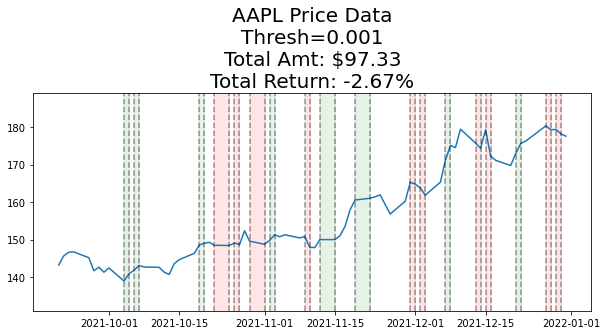

  0%|                                                    | 0/71 [00:00<?, ?it/s]/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.17571D+00    |proj g|=  1.09531D+02

At iterate    5    f= -3.18668D+00    |proj g|=  2.56493D+00

At iterate   10    f= -3.18836D+00    |proj g|=  4.17489D+01

At iterate   15    f= -3.22171D+00    |proj g|=  2.88388D+01

At iterate   20    f= -3.24207D+00    |proj g|=  2.07681D+01

At iterate   25    f= -3.26016D+00    |proj g|=  1.95351D+00

At iterate   30    f= -3.32215D+00    |proj g|=  5.18871D+01

At iterate   35    f= -3.36692D+00    |proj g|=  4.66589D+00

At iterate   40    f= -3.36696D+00    |proj g|=  2.65696D-01

At iterate   45    f= -3.36796D+00    |proj g|=  3.28759D+00

At iterate   50    f= -3.37866D+00    |proj g|=  3.32727D+00

At iterate   55    f= -3.42173D+00    |proj g|=  4.06958D+00

At iterate   60    f= -3.45887D+00    |proj g|=  6.69122D+01

At iterate   65    f= -3.4


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  175    f= -3.49912D+00    |proj g|=  7.39129D-01

At iterate  180    f= -3.49925D+00    |proj g|=  1.41724D+01

At iterate  185    f= -3.50006D+00    |proj g|=  3.61160D-01

At iterate  190    f= -3.50006D+00    |proj g|=  8.88723D-01

At iterate  195    f= -3.50035D+00    |proj g|=  9.64267D+00

At iterate  200    f= -3.50533D+00    |proj g|=  2.27551D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12    200    267      2     0     0   2.276D+01  -3.505D+00
  F =  -3.5053275525157357     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 13%|█████▌                                      | 9/71 [00:14<01:40,  1.62s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88067D+00    |proj g|=  6.25561D+00


 This problem is unconstrained.



At iterate    5    f= -2.88080D+00    |proj g|=  5.16903D-01

At iterate   10    f= -2.89626D+00    |proj g|=  7.45890D+00

At iterate   15    f= -2.89810D+00    |proj g|=  4.12734D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -2.89817D+00    |proj g|=  2.35377D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     24     76      2     0     0   3.246D-01  -2.898D+00
  F =  -2.8981700316809880     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 15%|██████▋                                    | 11/71 [00:20<01:55,  1.92s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94542D+00    |proj g|=  4.97027D+00


 This problem is unconstrained.



At iterate    5    f= -2.94556D+00    |proj g|=  2.89802D+00

At iterate   10    f= -2.95000D+00    |proj g|=  1.54309D-01

At iterate   15    f= -2.95030D+00    |proj g|=  2.75431D+00

At iterate   20    f= -2.95649D+00    |proj g|=  1.11254D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -2.95650D+00    |proj g|=  3.32901D-01

At iterate   30    f= -2.95650D+00    |proj g|=  2.68163D-01

At iterate   35    f= -2.95651D+00    |proj g|=  1.03963D+00

At iterate   40    f= -2.95707D+00    |proj g|=  1.60626D+01

At iterate   45    f= -2.96316D+00    |proj g|=  1.27309D+01

At iterate   50    f= -2.96321D+00    |proj g|=  5.30476D-01

At iterate   55    f= -2.96325D+00    |proj g|=  2.10629D+00

At iterate   60    f= -2.96342D+00    |proj g|=  3.03864D-01

At iterate   65    f= -2.96343D+00    |proj g|=  1.74594D-01

At iterate   70    f= -2.96351D+00    |proj g|=  9.34342D-01

At iterate   75    f= -2.96545D+00    |proj g|=  3.06036D+00

At iterate   80    f= -2.96567D+00    |proj g|=  4.20299D-01

At iterate   85    f= -2.96568D+00    |proj g|=  1.85298D+00

At iterate   90    f= -2.96581D+00    |proj g|=  8.87944D+00

At iterate   95    f= -2.96881D+00    |proj g|=  9.82530D+00

At iterate  100    f= -2.98241D+00    |proj g|=  7.68078D+00

At iter

 18%|███████▊                                   | 13/71 [00:42<04:07,  4.27s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.19601D+00    |proj g|=  1.52893D+01


 This problem is unconstrained.



At iterate    5    f= -3.19773D+00    |proj g|=  2.36942D+00

At iterate   10    f= -3.20324D+00    |proj g|=  2.04373D+01

At iterate   15    f= -3.20961D+00    |proj g|=  6.80248D-02

At iterate   20    f= -3.21232D+00    |proj g|=  7.20123D+00

At iterate   25    f= -3.22289D+00    |proj g|=  3.73356D-01

At iterate   30    f= -3.22307D+00    |proj g|=  3.56649D+00

At iterate   35    f= -3.22825D+00    |proj g|=  6.69441D+00

At iterate   40    f= -3.22861D+00    |proj g|=  4.19725D-02

At iterate   45    f= -3.23106D+00    |proj g|=  7.03553D-02

At iterate   50    f= -3.23114D+00    |proj g|=  1.00596D+00

At iterate   55    f= -3.23195D+00    |proj g|=  6.45794D-01

At iterate   60    f= -3.23195D+00    |proj g|=  3.15584D-02

At iterate   65    f= -3.23206D+00    |proj g|=  7.75049D-01

At iterate   70    f= -3.23234D+00    |proj g|=  5.61079D-02

At iterate   75    f= -3.23262D+00    |proj g|=  6.40057D-02

At iterate   80    f= -3.23263D+00    |proj g|=  7.86606D-02

At iter

 20%|████████▍                                  | 14/71 [00:55<05:20,  5.63s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.22147D+00    |proj g|=  1.45871D+01


 This problem is unconstrained.



At iterate    5    f= -3.22320D+00    |proj g|=  3.49399D+00

At iterate   10    f= -3.23171D+00    |proj g|=  1.88295D+01

At iterate   15    f= -3.23534D+00    |proj g|=  8.74274D-02

At iterate   20    f= -3.23565D+00    |proj g|=  2.15422D+00

At iterate   25    f= -3.24400D+00    |proj g|=  7.82907D+00

At iterate   30    f= -3.24965D+00    |proj g|=  8.69973D-01

At iterate   35    f= -3.24981D+00    |proj g|=  4.58058D-01

At iterate   40    f= -3.25026D+00    |proj g|=  6.03924D+00

At iterate   45    f= -3.25103D+00    |proj g|=  1.78280D-02

At iterate   50    f= -3.25104D+00    |proj g|=  5.21247D-02

At iterate   55    f= -3.25109D+00    |proj g|=  2.33970D-01

At iterate   60    f= -3.25111D+00    |proj g|=  1.81007D-02

At iterate   65    f= -3.25111D+00    |proj g|=  1.70901D-01

At iterate   70    f= -3.25113D+00    |proj g|=  2.87160D-01

At iterate   75    f= -3.25114D+00    |proj g|=  7.45759D-03

At iterate   80    f= -3.25114D+00    |proj g|=  8.85432D-02

At iter

 21%|█████████                                  | 15/71 [01:07<06:22,  6.84s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.24660D+00    |proj g|=  1.57190D+01


 This problem is unconstrained.



At iterate    5    f= -3.24824D+00    |proj g|=  1.36199D+00

At iterate   10    f= -3.25033D+00    |proj g|=  1.61033D+01

At iterate   15    f= -3.25995D+00    |proj g|=  1.94609D-01

At iterate   20    f= -3.25997D+00    |proj g|=  5.37930D-01

At iterate   25    f= -3.26194D+00    |proj g|=  5.79570D+00

At iterate   30    f= -3.26564D+00    |proj g|=  1.48129D-01

At iterate   35    f= -3.26573D+00    |proj g|=  6.50019D-01

At iterate   40    f= -3.26800D+00    |proj g|=  2.06872D+00

At iterate   45    f= -3.26913D+00    |proj g|=  1.33197D-02

At iterate   50    f= -3.26915D+00    |proj g|=  4.77977D-01

At iterate   55    f= -3.26998D+00    |proj g|=  3.99707D+00

At iterate   60    f= -3.27030D+00    |proj g|=  1.46158D-01

At iterate   65    f= -3.27030D+00    |proj g|=  9.02380D-02

At iterate   70    f= -3.27033D+00    |proj g|=  7.02394D-01

At iterate   75    f= -3.27050D+00    |proj g|=  4.84991D-01

At iterate   80    f= -3.27052D+00    |proj g|=  6.07892D-03

At iter

 23%|█████████▋                                 | 16/71 [01:19<07:12,  7.86s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.15253D+00    |proj g|=  8.90089D-01


 This problem is unconstrained.



At iterate    5    f= -3.16802D+00    |proj g|=  2.77949D-01

At iterate   10    f= -3.18476D+00    |proj g|=  8.63651D-02

At iterate   15    f= -3.18930D+00    |proj g|=  4.79300D-01

At iterate   20    f= -3.19237D+00    |proj g|=  2.86230D-01

At iterate   25    f= -3.19748D+00    |proj g|=  4.00066D-01

At iterate   30    f= -3.20902D+00    |proj g|=  8.02502D-01

At iterate   35    f= -3.21044D+00    |proj g|=  2.13875D-01

At iterate   40    f= -3.21429D+00    |proj g|=  2.51371D+00

At iterate   45    f= -3.21590D+00    |proj g|=  1.69027D-02

At iterate   50    f= -3.21622D+00    |proj g|=  2.59513D-01

At iterate   55    f= -3.21653D+00    |proj g|=  1.12447D-01

At iterate   60    f= -3.21703D+00    |proj g|=  2.04779D-02

At iterate   65    f= -3.21705D+00    |proj g|=  3.71030D-02

At iterate   70    f= -3.21717D+00    |proj g|=  5.37557D-02

At iterate   75    f= -3.21719D+00    |proj g|=  5.88587D-03

At iterate   80    f= -3.21720D+00    |proj g|=  8.92922D-02

At iter

 24%|██████████▎                                | 17/71 [01:34<08:24,  9.35s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.16822D+00    |proj g|=  4.29335D+00


 This problem is unconstrained.



At iterate    5    f= -3.16876D+00    |proj g|=  1.10613D+00

At iterate   10    f= -3.17407D+00    |proj g|=  1.12909D+01

At iterate   15    f= -3.18433D+00    |proj g|=  2.30890D+00

At iterate   20    f= -3.19627D+00    |proj g|=  7.84206D+00

At iterate   25    f= -3.20062D+00    |proj g|=  8.65689D-02

At iterate   30    f= -3.20076D+00    |proj g|=  2.56700D+00

At iterate   35    f= -3.20603D+00    |proj g|=  7.49804D+00

At iterate   40    f= -3.20697D+00    |proj g|=  3.11613D-02

At iterate   45    f= -3.21355D+00    |proj g|=  1.31447D+00

At iterate   50    f= -3.21443D+00    |proj g|=  4.83712D-01

At iterate   55    f= -3.21736D+00    |proj g|=  4.75794D+00

At iterate   60    f= -3.22154D+00    |proj g|=  1.52711D+00

At iterate   65    f= -3.22206D+00    |proj g|=  4.06964D-01

At iterate   70    f= -3.22227D+00    |proj g|=  5.43397D-02

At iterate   75    f= -3.22236D+00    |proj g|=  4.63764D-01

At iterate   80    f= -3.22420D+00    |proj g|=  1.20486D+00

At iter

 25%|██████████▉                                | 18/71 [01:48<09:24, 10.66s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.13783D+00    |proj g|=  9.48922D+00


 This problem is unconstrained.



At iterate    5    f= -3.16281D+00    |proj g|=  3.56892D+00

At iterate   10    f= -3.17449D+00    |proj g|=  2.40069D+00

At iterate   15    f= -3.18524D+00    |proj g|=  8.21460D-02

At iterate   20    f= -3.18779D+00    |proj g|=  3.09858D+00

At iterate   25    f= -3.19213D+00    |proj g|=  3.32892D-02

At iterate   30    f= -3.19515D+00    |proj g|=  1.25223D-01

At iterate   35    f= -3.19520D+00    |proj g|=  2.26859D-01

At iterate   40    f= -3.19640D+00    |proj g|=  3.32058D-01

At iterate   45    f= -3.19678D+00    |proj g|=  3.92708D-03

At iterate   50    f= -3.19687D+00    |proj g|=  3.84934D-01

At iterate   55    f= -3.19693D+00    |proj g|=  2.32525D-03

At iterate   60    f= -3.19693D+00    |proj g|=  2.15364D-02

At iterate   65    f= -3.19694D+00    |proj g|=  7.51139D-02

At iterate   70    f= -3.19695D+00    |proj g|=  3.49978D-03

At iterate   75    f= -3.19695D+00    |proj g|=  7.21747D-03

At iterate   80    f= -3.19695D+00    |proj g|=  7.05973D-03

At iter

 27%|███████████▌                               | 19/71 [02:01<09:41, 11.19s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30800D+00    |proj g|=  4.70516D-01


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f= -2.71786D+00    |proj g|=  1.80149D-01

At iterate   10    f= -3.02194D+00    |proj g|=  4.61593D-02

At iterate   15    f= -3.04520D+00    |proj g|=  1.51650D-02

At iterate   20    f= -3.07217D+00    |proj g|=  4.78680D-02

At iterate   25    f= -3.10237D+00    |proj g|=  4.82638D-01

At iterate   30    f= -3.12911D+00    |proj g|=  7.09350D-02

At iterate   35    f= -3.14730D+00    |proj g|=  1.47700D+00

At iterate   40    f= -3.15368D+00    |proj g|=  9.82143D-02

At iterate   45    f= -3.17254D+00    |proj g|=  2.97050D+00

At iterate   50    f= -3.17464D+00    |proj g|=  3.23182D-01

At iterate   55    f= -3.17511D+00    |proj g|=  1.26338D-02

At iterate   60    f= -3.17533D+00    |proj g|=  1.99025D-01

At iterate   65    f= -3.17617D+00    |proj g|=  1.28989D-02

At iterate   70    f= -3.17634D+00    |proj g|=  5.84062D-03

At iterate   75    f= -3.17660D+00    |proj g|=  4.12705D-03

At iterate   80    f= -3.17660D+00    |proj g|=  3.99738D-02

At iter

 28%|████████████                               | 20/71 [02:14<09:59, 11.75s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.02189D+00    |proj g|=  8.36614D+00


 This problem is unconstrained.



At iterate    5    f= -3.13301D+00    |proj g|=  8.24150D-01

At iterate   10    f= -3.14875D+00    |proj g|=  1.05628D-01

At iterate   15    f= -3.15321D+00    |proj g|=  1.32852D+00

At iterate   20    f= -3.16474D+00    |proj g|=  8.38668D-01

At iterate   25    f= -3.17470D+00    |proj g|=  1.09941D-01

At iterate   30    f= -3.18330D+00    |proj g|=  3.30771D-01

At iterate   35    f= -3.18497D+00    |proj g|=  1.14146D+00

At iterate   40    f= -3.18920D+00    |proj g|=  3.46383D-01

At iterate   45    f= -3.19168D+00    |proj g|=  2.35182D-01

At iterate   50    f= -3.19226D+00    |proj g|=  1.23744D-02

At iterate   55    f= -3.19261D+00    |proj g|=  5.29812D-03

At iterate   60    f= -3.19272D+00    |proj g|=  2.02256D-03

At iterate   65    f= -3.19275D+00    |proj g|=  3.20680D-02

At iterate   70    f= -3.19278D+00    |proj g|=  2.34651D-02

At iterate   75    f= -3.19279D+00    |proj g|=  1.41980D-03

At iterate   80    f= -3.19279D+00    |proj g|=  7.04845D-03

At iter

 30%|████████████▋                              | 21/71 [02:27<09:58, 11.97s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.06758D+00    |proj g|=  8.76463D+00


 This problem is unconstrained.



At iterate    5    f= -3.15141D+00    |proj g|=  6.78414D-01

At iterate   10    f= -3.16805D+00    |proj g|=  5.42992D-02

At iterate   15    f= -3.17004D+00    |proj g|=  8.48233D-01

At iterate   20    f= -3.18398D+00    |proj g|=  9.17920D-02

At iterate   25    f= -3.19740D+00    |proj g|=  8.38802D-01

At iterate   30    f= -3.19825D+00    |proj g|=  8.68495D-01

At iterate   35    f= -3.20375D+00    |proj g|=  5.56121D-02

At iterate   40    f= -3.20463D+00    |proj g|=  5.61984D-01

At iterate   45    f= -3.20675D+00    |proj g|=  1.80260D-01

At iterate   50    f= -3.20679D+00    |proj g|=  1.62205D-02

At iterate   55    f= -3.20685D+00    |proj g|=  4.65670D-01

At iterate   60    f= -3.20751D+00    |proj g|=  9.36706D-01

At iterate   65    f= -3.20767D+00    |proj g|=  4.80278D-03

At iterate   70    f= -3.20772D+00    |proj g|=  4.25165D-02

At iterate   75    f= -3.20777D+00    |proj g|=  2.89342D-02

At iterate   80    f= -3.20782D+00    |proj g|=  6.83298D-03

At iter

 31%|█████████████▎                             | 22/71 [02:38<09:40, 11.84s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.17752D+00    |proj g|=  9.33637D+00

At iterate    5    f= -3.19626D+00    |proj g|=  1.48441D+00

At iterate   10    f= -3.20736D+00    |proj g|=  5.20842D-02

At iterate   15    f= -3.20830D+00    |proj g|=  1.21214D+00

At iterate   20    f= -3.21647D+00    |proj g|=  1.61662D+00

At iterate   25    f= -3.21840D+00    |proj g|=  6.92870D-01

At iterate   30    f= -3.22001D+00    |proj g|=  1.19407D-01

At iterate   35    f= -3.22060D+00    |proj g|=  5.37845D-01

At iterate   40    f= -3.22091D+00    |proj g|=  1.84005D-01

At iterate   45    f= -3.22134D+00    |proj g|=  2.14965D-02

At iterate   50    f= -3.22135D+00    |proj g|=  8.34555D-03

At iterate   55    f= -3.22149D+00    |proj g|=  5.66683D-01

At iterate   60    f= -3.22157D+00    |proj g|=  7.17082D-02

At iterate   65    f= -3.2

 32%|█████████████▉                             | 23/71 [02:50<09:26, 11.80s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.16153D+00    |proj g|=  9.89242D+00

At iterate    5    f= -3.18768D+00    |proj g|=  6.89751D-01

At iterate   10    f= -3.19858D+00    |proj g|=  1.40105D+00

At iterate   15    f= -3.20325D+00    |proj g|=  2.09687D+00

At iterate   20    f= -3.20570D+00    |proj g|=  4.26860D-01

At iterate   25    f= -3.20831D+00    |proj g|=  1.17356D-01

At iterate   30    f= -3.20849D+00    |proj g|=  4.09914D-01

At iterate   35    f= -3.20945D+00    |proj g|=  1.12132D-01

At iterate   40    f= -3.20953D+00    |proj g|=  5.42555D-02

At iterate   45    f= -3.21005D+00    |proj g|=  4.51172D-03

At iterate   50    f= -3.21006D+00    |proj g|=  1.72723D-01

At iterate   55    f= -3.21016D+00    |proj g|=  4.31595D-02

At iterate   60    f= -3.21016D+00    |proj g|=  1.85354D-03

At iterate   65    f= -3.2

 35%|███████████████▏                           | 25/71 [03:00<06:39,  8.69s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.15208D+00    |proj g|=  1.00790D+01

At iterate    5    f= -3.17469D+00    |proj g|=  5.61024D-01

At iterate   10    f= -3.18184D+00    |proj g|=  2.30152D+00

At iterate   15    f= -3.18313D+00    |proj g|=  4.89294D-02

At iterate   20    f= -3.18708D+00    |proj g|=  7.81020D-01

At iterate   25    f= -3.18744D+00    |proj g|=  5.39516D-02

At iterate   30    f= -3.18746D+00    |proj g|=  2.32142D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f= -3.18793D+00    |proj g|=  6.04989D-02

At iterate   40    f= -3.18795D+00    |proj g|=  2.61395D-01

At iterate   45    f= -3.18807D+00    |proj g|=  2.17928D-02

At iterate   50    f= -3.18809D+00    |proj g|=  4.67566D-02

At iterate   55    f= -3.18822D+00    |proj g|=  4.40371D-02

At iterate   60    f= -3.18822D+00    |proj g|=  2.29736D-02

At iterate   65    f= -3.18829D+00    |proj g|=  2.74957D-02

At iterate   70    f= -3.18829D+00    |proj g|=  2.16634D-02

At iterate   75    f= -3.18830D+00    |proj g|=  8.95186D-03

At iterate   80    f= -3.18830D+00    |proj g|=  7.98788D-03

At iterate   85    f= -3.18831D+00    |proj g|=  1.89642D-02

At iterate   90    f= -3.18831D+00    |proj g|=  1.93414D-03

At iterate   95    f= -3.18831D+00    |proj g|=  9.83369D-03

At iterate  100    f= -3.18831D+00    |proj g|=  4.16973D-03

At iterate  105    f= -3.18831D+00    |proj g|=  7.97407D-04

At iterate  110    f= -3.18831D+00    |proj g|=  2.56906D-04

At iter

 38%|████████████████▎                          | 27/71 [03:12<05:36,  7.65s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.16016D+00    |proj g|=  8.50383D+00

At iterate    5    f= -3.17594D+00    |proj g|=  1.04342D-01

At iterate   10    f= -3.17892D+00    |proj g|=  1.03286D+00

At iterate   15    f= -3.17938D+00    |proj g|=  2.57272D-01

At iterate   20    f= -3.18007D+00    |proj g|=  2.27753D-01

At iterate   25    f= -3.18028D+00    |proj g|=  1.25165D-01

At iterate   30    f= -3.18052D+00    |proj g|=  8.80078D-02

At iterate   35    f= -3.18052D+00    |proj g|=  1.78008D-02

At iterate   40    f= -3.18052D+00    |proj g|=  5.51109D-02

At iterate   45    f= -3.18053D+00    |proj g|=  2.21192D-03

At iterate   50    f= -3.18055D+00    |proj g|=  3.23892D-02

At iterate   55    f= -3.18056D+00    |proj g|=  4.36207D-03

At iterate   60    f= -3.18057D+00    |proj g|=  4.60739D-02

At iterate   65    f= -3.1

 39%|████████████████▉                          | 28/71 [03:24<06:06,  8.53s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.10915D+00    |proj g|=  8.26552D+00


 This problem is unconstrained.



At iterate    5    f= -3.12428D+00    |proj g|=  1.87800D+00

At iterate   10    f= -3.12473D+00    |proj g|=  1.27744D-01

At iterate   15    f= -3.12587D+00    |proj g|=  1.72927D+00

At iterate   20    f= -3.12892D+00    |proj g|=  1.01666D-01

At iterate   25    f= -3.12895D+00    |proj g|=  2.02518D-01

At iterate   30    f= -3.13015D+00    |proj g|=  5.44420D-01

At iterate   35    f= -3.13032D+00    |proj g|=  1.55733D-01

At iterate   40    f= -3.13182D+00    |proj g|=  9.43553D-02

At iterate   45    f= -3.13239D+00    |proj g|=  3.45808D-03

At iterate   50    f= -3.13244D+00    |proj g|=  2.95212D-01

At iterate   55    f= -3.13248D+00    |proj g|=  6.77192D-03

At iterate   60    f= -3.13249D+00    |proj g|=  6.32064D-02

At iterate   65    f= -3.13249D+00    |proj g|=  2.01152D-02

At iterate   70    f= -3.13250D+00    |proj g|=  4.64568D-02

At iterate   75    f= -3.13250D+00    |proj g|=  2.75180D-03

At iterate   80    f= -3.13250D+00    |proj g|=  1.35554D-03

At iter

 42%|██████████████████▏                        | 30/71 [03:36<05:10,  7.58s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.11712D+00    |proj g|=  8.35999D+00

At iterate    5    f= -3.13402D+00    |proj g|=  4.75486D-01

At iterate   10    f= -3.13816D+00    |proj g|=  3.88825D-02

At iterate   15    f= -3.13931D+00    |proj g|=  1.43508D+00

At iterate   20    f= -3.14061D+00    |proj g|=  7.71881D-02

At iterate   25    f= -3.14062D+00    |proj g|=  9.16648D-02

At iterate   30    f= -3.14073D+00    |proj g|=  2.38941D-01

At iterate   35    f= -3.14078D+00    |proj g|=  1.21656D-01

At iterate   40    f= -3.14097D+00    |proj g|=  4.39470D-02

At iterate   45    f= -3.14133D+00    |proj g|=  3.57323D-03

At iterate   50    f= -3.14133D+00    |proj g|=  1.04752D-02

At iterate   55    f= -3.14133D+00    |proj g|=  3.67297D-03

At iterate   60    f= -3.14133D+00    |proj g|=  3.78635D-03

At iterate   65    f= -3.1

 44%|██████████████████▊                        | 31/71 [03:47<05:34,  8.37s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.12540D+00    |proj g|=  7.74708D+00

At iterate    5    f= -3.13441D+00    |proj g|=  3.58278D+00

At iterate   10    f= -3.13923D+00    |proj g|=  1.81357D-01

At iterate   15    f= -3.14008D+00    |proj g|=  1.34306D+00

At iterate   20    f= -3.14437D+00    |proj g|=  1.65642D-01

At iterate   25    f= -3.14877D+00    |proj g|=  1.17243D-01

At iterate   30    f= -3.15091D+00    |proj g|=  8.99285D-01

At iterate   35    f= -3.15169D+00    |proj g|=  1.22725D-02

At iterate   40    f= -3.15278D+00    |proj g|=  4.74853D-01

At iterate   45    f= -3.15305D+00    |proj g|=  2.08242D-02

At iterate   50    f= -3.15308D+00    |proj g|=  1.62645D-01

At iterate   55    f= -3.15317D+00    |proj g|=  2.05529D-02

At iterate   60    f= -3.15317D+00    |proj g|=  1.40838D-03

At iterate   65    f= -3.1

 46%|███████████████████▉                       | 33/71 [03:57<04:32,  7.17s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.13897D+00    |proj g|=  7.18017D+00

At iterate    5    f= -3.14466D+00    |proj g|=  2.45608D+00

At iterate   10    f= -3.15157D+00    |proj g|=  7.95942D-02

At iterate   15    f= -3.15695D+00    |proj g|=  2.43632D+00

At iterate   20    f= -3.15761D+00    |proj g|=  3.01213D-01

At iterate   25    f= -3.16024D+00    |proj g|=  6.82369D-01

At iterate   30    f= -3.16044D+00    |proj g|=  5.24198D-02

At iterate   35    f= -3.16059D+00    |proj g|=  1.10990D+00

At iterate   40    f= -3.16129D+00    |proj g|=  6.69044D-01

At iterate   45    f= -3.16135D+00    |proj g|=  1.06749D-01

At iterate   50    f= -3.16136D+00    |proj g|=  9.17299D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   55    f= -3.16140D+00    |proj g|=  7.64596D-02

At iterate   60    f= -3.16140D+00    |proj g|=  5.27369D-02

At iterate   65    f= -3.16142D+00    |proj g|=  2.81025D-01

At iterate   70    f= -3.16144D+00    |proj g|=  4.93663D-02

At iterate   75    f= -3.16144D+00    |proj g|=  3.87295D-03

At iterate   80    f= -3.16144D+00    |proj g|=  4.45588D-02

At iterate   85    f= -3.16144D+00    |proj g|=  3.04285D-03

At iterate   90    f= -3.16144D+00    |proj g|=  4.05871D-03

At iterate   95    f= -3.16144D+00    |proj g|=  5.88862D-05

At iterate  100    f= -3.16144D+00    |proj g|=  3.66507D-04

At iterate  105    f= -3.16144D+00    |proj g|=  3.57563D-03

At iterate  110    f= -3.16144D+00    |proj g|=  1.18305D-04

At iterate  115    f= -3.16144D+00    |proj g|=  1.89893D-04

At iterate  120    f= -3.16144D+00    |proj g|=  1.33591D-03

At iterate  125    f= -3.16144D+00    |proj g|=  3.94795D-05

At iterate  130    f= -3.16144D+00    |proj g|=  5.08038D-05

At iter

 48%|████████████████████▌                      | 34/71 [04:08<04:54,  7.97s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.13851D+00    |proj g|=  7.57481D+00


 This problem is unconstrained.



At iterate    5    f= -3.14691D+00    |proj g|=  3.46049D+00

At iterate   10    f= -3.15275D+00    |proj g|=  2.79001D-02

At iterate   15    f= -3.15643D+00    |proj g|=  9.57808D-02

At iterate   20    f= -3.15734D+00    |proj g|=  9.04321D-03

At iterate   25    f= -3.15807D+00    |proj g|=  8.99845D-03

At iterate   30    f= -3.15811D+00    |proj g|=  1.25429D-03

At iterate   35    f= -3.15811D+00    |proj g|=  2.93277D-04

At iterate   40    f= -3.15811D+00    |proj g|=  3.63087D-04

At iterate   45    f= -3.15811D+00    |proj g|=  1.10667D-04

At iterate   50    f= -3.15811D+00    |proj g|=  1.31006D-05

At iterate   55    f= -3.15811D+00    |proj g|=  6.17284D-05

At iterate   60    f= -3.15811D+00    |proj g|=  2.90878D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 49%|█████████████████████▏                     | 35/71 [04:13<04:19,  7.20s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.11849D+00    |proj g|=  6.23976D+00

At iterate    5    f= -3.12223D+00    |proj g|=  1.37238D+00

At iterate   10    f= -3.12965D+00    |proj g|=  1.48672D+00

At iterate   15    f= -3.13255D+00    |proj g|=  3.63543D-02

At iterate   20    f= -3.13309D+00    |proj g|=  4.34586D-02

At iterate   25    f= -3.13334D+00    |proj g|=  2.52983D-01

At iterate   30    f= -3.13352D+00    |proj g|=  5.63687D-03

At iterate   35    f= -3.13352D+00    |proj g|=  1.79504D-02

At iterate   40    f= -3.13359D+00    |proj g|=  4.53064D-03

At iterate   45    f= -3.13359D+00    |proj g|=  6.28972D-03

At iterate   50    f= -3.13359D+00    |proj g|=  5.61258D-03

At iterate   55    f= -3.13359D+00    |proj g|=  8.25739D-04

At iterate   60    f= -3.13359D+00    |proj g|=  1.92313D-03

At iterate   65    f= -3.1

 51%|█████████████████████▊                     | 36/71 [04:20<04:10,  7.14s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.07909D+00    |proj g|=  6.29911D+00

At iterate    5    f= -3.08292D+00    |proj g|=  1.42361D+00

At iterate   10    f= -3.09064D+00    |proj g|=  1.45426D+00

At iterate   15    f= -3.09283D+00    |proj g|=  9.17013D-03

At iterate   20    f= -3.09317D+00    |proj g|=  7.91687D-03

At iterate   25    f= -3.09320D+00    |proj g|=  6.33512D-02

At iterate   30    f= -3.09323D+00    |proj g|=  3.97620D-03

At iterate   35    f= -3.09323D+00    |proj g|=  2.21333D-02

At iterate   40    f= -3.09323D+00    |proj g|=  2.53397D-04

At iterate   45    f= -3.09323D+00    |proj g|=  1.13362D-02

At iterate   50    f= -3.09323D+00    |proj g|=  7.36144D-03

At iterate   55    f= -3.09323D+00    |proj g|=  1.48459D-04

At iterate   60    f= -3.09323D+00    |proj g|=  2.86327D-03

At iterate   65    f= -3.0

 54%|███████████████████████                    | 38/71 [04:28<03:11,  5.81s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08877D+00    |proj g|=  6.26120D+00

At iterate    5    f= -3.09248D+00    |proj g|=  1.39766D+00

At iterate   10    f= -3.10025D+00    |proj g|=  1.60741D+00

At iterate   15    f= -3.10244D+00    |proj g|=  1.80586D-02

At iterate   20    f= -3.10278D+00    |proj g|=  3.24811D-03

At iterate   25    f= -3.10279D+00    |proj g|=  1.25766D-01

At iterate   30    f= -3.10285D+00    |proj g|=  5.30002D-02

At iterate   35    f= -3.10285D+00    |proj g|=  2.51794D-03

At iterate   40    f= -3.10285D+00    |proj g|=  7.76335D-02

At iterate   45    f= -3.10285D+00    |proj g|=  8.72813D-04

At iterate   50    f= -3.10285D+00    |proj g|=  4.50950D-03

At iterate   55    f= -3.10285D+00    |proj g|=  7.10996D-03

At iterate   60    f= -3.10285D+00    |proj g|=  1.41576D-04

At iterate   65    f= -3.1

 55%|███████████████████████▌                   | 39/71 [04:35<03:17,  6.17s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.09734D+00    |proj g|=  6.62389D+00

At iterate    5    f= -3.10175D+00    |proj g|=  1.98845D+00

At iterate   10    f= -3.10916D+00    |proj g|=  4.26939D-01

At iterate   15    f= -3.10965D+00    |proj g|=  9.96880D-02

At iterate   20    f= -3.11103D+00    |proj g|=  1.07638D-02

At iterate   25    f= -3.11112D+00    |proj g|=  3.86981D-01

At iterate   30    f= -3.11135D+00    |proj g|=  5.95537D-03

At iterate   35    f= -3.11139D+00    |proj g|=  4.05045D-03

At iterate   40    f= -3.11141D+00    |proj g|=  1.44280D-03

At iterate   45    f= -3.11141D+00    |proj g|=  9.89875D-05

At iterate   50    f= -3.11141D+00    |proj g|=  3.42393D-05

At iterate   55    f= -3.11141D+00    |proj g|=  5.87530D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

 56%|████████████████████████▏                  | 40/71 [04:39<02:55,  5.66s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08148D+00    |proj g|=  6.82819D+00

At iterate    5    f= -3.08717D+00    |proj g|=  2.37210D+00

At iterate   10    f= -3.09317D+00    |proj g|=  1.44212D-01

At iterate   15    f= -3.09357D+00    |proj g|=  9.13543D-01

At iterate   20    f= -3.09531D+00    |proj g|=  1.26807D-01

At iterate   25    f= -3.09536D+00    |proj g|=  2.09037D-01

At iterate   30    f= -3.09593D+00    |proj g|=  1.09437D-01

At iterate   35    f= -3.09594D+00    |proj g|=  5.56102D-03

At iterate   40    f= -3.09596D+00    |proj g|=  1.79520D-01

At iterate   45    f= -3.09608D+00    |proj g|=  3.68313D-02

At iterate   50    f= -3.09608D+00    |proj g|=  7.82743D-03

At iterate   55    f= -3.09608D+00    |proj g|=  1.52397D-02

At iterate   60    f= -3.09609D+00    |proj g|=  2.85998D-03

At iterate   65    f= -3.0

 58%|████████████████████████▊                  | 41/71 [04:47<03:01,  6.06s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.03871D+00    |proj g|=  5.25109D+00


 This problem is unconstrained.



At iterate    5    f= -3.04282D+00    |proj g|=  6.68588D-01

At iterate   10    f= -3.04760D+00    |proj g|=  1.90422D+00

At iterate   15    f= -3.04949D+00    |proj g|=  4.47878D-01

At iterate   20    f= -3.05055D+00    |proj g|=  5.29561D-02

At iterate   25    f= -3.05088D+00    |proj g|=  1.94421D-01

At iterate   30    f= -3.05091D+00    |proj g|=  2.75267D-02

At iterate   35    f= -3.05097D+00    |proj g|=  7.84635D-03

At iterate   40    f= -3.05098D+00    |proj g|=  2.19359D-02

At iterate   45    f= -3.05098D+00    |proj g|=  5.74978D-02

At iterate   50    f= -3.05099D+00    |proj g|=  1.73427D-02

At iterate   55    f= -3.05099D+00    |proj g|=  1.56359D-03

At iterate   60    f= -3.05099D+00    |proj g|=  8.75073D-03

At iterate   65    f= -3.05099D+00    |proj g|=  7.79776D-04

At iterate   70    f= -3.05099D+00    |proj g|=  2.33458D-04

At iterate   75    f= -3.05099D+00    |proj g|=  3.48699D-04

At iterate   80    f= -3.05099D+00    |proj g|=  1.64024D-03

At iter

 59%|█████████████████████████▍                 | 42/71 [04:54<03:04,  6.37s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.03496D+00    |proj g|=  4.02101D+00

At iterate    5    f= -3.03838D+00    |proj g|=  4.29181D-01

At iterate   10    f= -3.04211D+00    |proj g|=  2.36312D+00

At iterate   15    f= -3.04350D+00    |proj g|=  5.94796D-02

At iterate   20    f= -3.04539D+00    |proj g|=  2.98317D-01

At iterate   25    f= -3.04590D+00    |proj g|=  2.03204D-02

At iterate   30    f= -3.04612D+00    |proj g|=  3.34723D-03

At iterate   35    f= -3.04612D+00    |proj g|=  1.77285D-02

At iterate   40    f= -3.04612D+00    |proj g|=  6.03650D-04

At iterate   45    f= -3.04612D+00    |proj g|=  5.60352D-04

At iterate   50    f= -3.04612D+00    |proj g|=  6.90115D-05

At iterate   55    f= -3.04612D+00    |proj g|=  1.37668D-05

At iterate   60    f= -3.04612D+00    |proj g|=  2.17604D-06

           * * *

Tit   = 

 61%|██████████████████████████                 | 43/71 [04:58<02:43,  5.84s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.05228D+00    |proj g|=  4.36385D+00

At iterate    5    f= -3.05557D+00    |proj g|=  3.60173D-01

At iterate   10    f= -3.05856D+00    |proj g|=  2.83059D+00

At iterate   15    f= -3.06066D+00    |proj g|=  1.72969D-02

At iterate   20    f= -3.06270D+00    |proj g|=  1.05755D-01

At iterate   25    f= -3.06291D+00    |proj g|=  4.19611D-03

At iterate   30    f= -3.06295D+00    |proj g|=  2.33801D-01

At iterate   35    f= -3.06297D+00    |proj g|=  2.13345D-03

At iterate   40    f= -3.06297D+00    |proj g|=  7.22644D-03

At iterate   45    f= -3.06298D+00    |proj g|=  4.01497D-03

At iterate   50    f= -3.06298D+00    |proj g|=  8.14815D-04

At iterate   55    f= -3.06298D+00    |proj g|=  2.96070D-03

At iterate   60    f= -3.06298D+00    |proj g|=  4.75620D-05

At iterate   65    f= -3.0

 63%|███████████████████████████▎               | 45/71 [05:05<02:02,  4.69s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.05548D+00    |proj g|=  4.13162D+00

At iterate    5    f= -3.05897D+00    |proj g|=  4.22945D-01

At iterate   10    f= -3.06266D+00    |proj g|=  2.46666D+00

At iterate   15    f= -3.06427D+00    |proj g|=  1.51522D-01

At iterate   20    f= -3.06553D+00    |proj g|=  6.45057D-01

At iterate   25    f= -3.06631D+00    |proj g|=  3.94638D-02

At iterate   30    f= -3.06633D+00    |proj g|=  1.46140D-02

At iterate   35    f= -3.06637D+00    |proj g|=  8.09424D-03

At iterate   40    f= -3.06638D+00    |proj g|=  8.95328D-03

At iterate   45    f= -3.06638D+00    |proj g|=  1.46794D-02

At iterate   50    f= -3.06638D+00    |proj g|=  2.95763D-05

At iterate   55    f= -3.06638D+00    |proj g|=  1.54232D-04

At iterate   60    f= -3.06638D+00    |proj g|=  5.53335D-05

At iterate   65    f= -3.0

 65%|███████████████████████████▊               | 46/71 [05:11<02:03,  4.94s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.01813D+00    |proj g|=  3.92611D+00

At iterate    5    f= -3.01978D+00    |proj g|=  2.59857D-01

At iterate   10    f= -3.02110D+00    |proj g|=  2.89024D+00

At iterate   15    f= -3.02362D+00    |proj g|=  6.40584D-02

At iterate   20    f= -3.02413D+00    |proj g|=  3.77333D-01

At iterate   25    f= -3.02508D+00    |proj g|=  1.19259D-01

At iterate   30    f= -3.02518D+00    |proj g|=  4.55316D-03

At iterate   35    f= -3.02520D+00    |proj g|=  9.48293D-02

At iterate   40    f= -3.02531D+00    |proj g|=  1.03661D-01

At iterate   45    f= -3.02532D+00    |proj g|=  5.95506D-03

At iterate   50    f= -3.02533D+00    |proj g|=  1.30180D-02

At iterate   55    f= -3.02533D+00    |proj g|=  3.97886D-03

At iterate   60    f= -3.02533D+00    |proj g|=  9.84102D-05

At iterate   65    f= -3.0

 66%|████████████████████████████▍              | 47/71 [05:20<02:24,  6.04s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.00091D+00    |proj g|=  4.86658D+00

At iterate    5    f= -3.00463D+00    |proj g|=  4.82178D-01

At iterate   10    f= -3.00744D+00    |proj g|=  1.55866D+00

At iterate   15    f= -3.00790D+00    |proj g|=  4.21101D-02

At iterate   20    f= -3.00971D+00    |proj g|=  3.38508D-01

At iterate   25    f= -3.00981D+00    |proj g|=  2.66676D-01

At iterate   30    f= -3.01009D+00    |proj g|=  1.17679D-01

At iterate   35    f= -3.01024D+00    |proj g|=  2.09487D-01

At iterate   40    f= -3.01026D+00    |proj g|=  6.75895D-03

At iterate   45    f= -3.01027D+00    |proj g|=  2.53850D-03

At iterate   50    f= -3.01027D+00    |proj g|=  1.35407D-03

At iterate   55    f= -3.01027D+00    |proj g|=  1.14952D-03

At iterate   60    f= -3.01027D+00    |proj g|=  7.27862D-05

At iterate   65    f= -3.0

 68%|█████████████████████████████              | 48/71 [05:27<02:26,  6.38s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.96208D+00    |proj g|=  5.32284D+00

At iterate    5    f= -2.97091D+00    |proj g|=  3.58941D-01

At iterate   10    f= -2.97443D+00    |proj g|=  1.39818D+00

At iterate   15    f= -2.97509D+00    |proj g|=  4.40672D-02

At iterate   20    f= -2.97746D+00    |proj g|=  3.78474D-01

At iterate   25    f= -2.97766D+00    |proj g|=  3.04649D-02

At iterate   30    f= -2.97852D+00    |proj g|=  4.67638D-02

At iterate   35    f= -2.97863D+00    |proj g|=  1.55937D-02

At iterate   40    f= -2.97869D+00    |proj g|=  2.71233D-02

At iterate   45    f= -2.97872D+00    |proj g|=  1.06537D-02

At iterate   50    f= -2.97873D+00    |proj g|=  1.58900D-03

At iterate   55    f= -2.97873D+00    |proj g|=  2.76916D-03

At iterate   60    f= -2.97873D+00    |proj g|=  1.31153D-03

At iterate   65    f= -2.9

 69%|█████████████████████████████▋             | 49/71 [05:35<02:27,  6.70s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.96813D+00    |proj g|=  5.10310D+00

At iterate    5    f= -2.97277D+00    |proj g|=  5.93338D-01

At iterate   10    f= -2.97764D+00    |proj g|=  1.02075D+00

At iterate   15    f= -2.97979D+00    |proj g|=  1.32934D-01

At iterate   20    f= -2.97991D+00    |proj g|=  2.12805D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -2.98106D+00    |proj g|=  3.74761D-02

At iterate   30    f= -2.98107D+00    |proj g|=  2.11273D-01

At iterate   35    f= -2.98148D+00    |proj g|=  6.52566D-01

At iterate   40    f= -2.98156D+00    |proj g|=  1.72332D-02

At iterate   45    f= -2.98204D+00    |proj g|=  3.98492D-01

At iterate   50    f= -2.98235D+00    |proj g|=  1.56066D-01

At iterate   55    f= -2.98249D+00    |proj g|=  1.24811D-02

At iterate   60    f= -2.98252D+00    |proj g|=  1.17372D-02

At iterate   65    f= -2.98252D+00    |proj g|=  2.18559D-02

At iterate   70    f= -2.98253D+00    |proj g|=  1.71201D-03

At iterate   75    f= -2.98253D+00    |proj g|=  3.57940D-03

At iterate   80    f= -2.98253D+00    |proj g|=  3.07399D-04

At iterate   85    f= -2.98253D+00    |proj g|=  5.94325D-04

At iterate   90    f= -2.98253D+00    |proj g|=  2.52687D-05

At iterate   95    f= -2.98253D+00    |proj g|=  7.02682D-04

At iterate  100    f= -2.98253D+00    |proj g|=  3.24185D-05

At iter

 72%|██████████████████████████████▉            | 51/71 [05:43<01:54,  5.70s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.96534D+00    |proj g|=  5.04473D+00


 This problem is unconstrained.



At iterate    5    f= -2.96916D+00    |proj g|=  6.25162D-01

At iterate   10    f= -2.97310D+00    |proj g|=  1.50846D+00

At iterate   15    f= -2.97376D+00    |proj g|=  7.31740D-01

At iterate   20    f= -2.97606D+00    |proj g|=  8.12220D-01

At iterate   25    f= -2.97626D+00    |proj g|=  1.50634D-02

At iterate   30    f= -2.97723D+00    |proj g|=  7.03890D-02

At iterate   35    f= -2.97724D+00    |proj g|=  7.69544D-02

At iterate   40    f= -2.97740D+00    |proj g|=  5.83737D-02

At iterate   45    f= -2.97744D+00    |proj g|=  1.61969D-02

At iterate   50    f= -2.97745D+00    |proj g|=  2.12816D-03

At iterate   55    f= -2.97746D+00    |proj g|=  1.23838D-02

At iterate   60    f= -2.97746D+00    |proj g|=  2.07097D-02

At iterate   65    f= -2.97747D+00    |proj g|=  1.51181D-03

At iterate   70    f= -2.97747D+00    |proj g|=  1.56466D-03

At iterate   75    f= -2.97747D+00    |proj g|=  5.80798D-03

At iterate   80    f= -2.97747D+00    |proj g|=  3.86886D-03

At iter

 75%|████████████████████████████████           | 53/71 [05:53<01:36,  5.36s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.92398D+00    |proj g|=  4.73437D+00

At iterate    5    f= -2.92873D+00    |proj g|=  3.83986D-01

At iterate   10    f= -2.93187D+00    |proj g|=  1.96514D+00

At iterate   15    f= -2.93286D+00    |proj g|=  7.48654D-02

At iterate   20    f= -2.93581D+00    |proj g|=  3.76436D-01

At iterate   25    f= -2.93731D+00    |proj g|=  3.73542D-02

At iterate   30    f= -2.93915D+00    |proj g|=  4.49703D-02

At iterate   35    f= -2.93955D+00    |proj g|=  1.87949D-02

At iterate   40    f= -2.93970D+00    |proj g|=  1.56190D-02

At iterate   45    f= -2.93974D+00    |proj g|=  2.54943D-03

At iterate   50    f= -2.93974D+00    |proj g|=  7.15294D-04

At iterate   55    f= -2.93974D+00    |proj g|=  3.72173D-03

At iterate   60    f= -2.93974D+00    |proj g|=  2.63656D-04

At iterate   65    f= -2.9

 76%|████████████████████████████████▋          | 54/71 [06:00<01:37,  5.73s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.92538D+00    |proj g|=  4.71144D+00

At iterate    5    f= -2.92983D+00    |proj g|=  4.13932D-01

At iterate   10    f= -2.93232D+00    |proj g|=  9.37901D-01

At iterate   15    f= -2.93445D+00    |proj g|=  1.81476D+00

At iterate   20    f= -2.93592D+00    |proj g|=  1.49811D-02

At iterate   25    f= -2.93634D+00    |proj g|=  3.80897D-02

At iterate   30    f= -2.93813D+00    |proj g|=  2.36999D-02

At iterate   35    f= -2.93990D+00    |proj g|=  8.09219D-01

At iterate   40    f= -2.94103D+00    |proj g|=  1.97893D-02

At iterate   45    f= -2.94133D+00    |proj g|=  2.30837D-01

At iterate   50    f= -2.94251D+00    |proj g|=  3.46370D-02

At iterate   55    f= -2.94283D+00    |proj g|=  5.60646D-02

At iterate   60    f= -2.94289D+00    |proj g|=  3.72165D-01

At iterate   65    f= -2.9

 79%|█████████████████████████████████▉         | 56/71 [06:09<01:18,  5.26s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88670D+00    |proj g|=  3.62243D+00

At iterate    5    f= -2.89410D+00    |proj g|=  1.31512D+00

At iterate   10    f= -2.89537D+00    |proj g|=  3.75054D-02

At iterate   15    f= -2.89669D+00    |proj g|=  6.21799D-01

At iterate   20    f= -2.89827D+00    |proj g|=  9.37197D-03

At iterate   25    f= -2.89857D+00    |proj g|=  6.45731D-02

At iterate   30    f= -2.89862D+00    |proj g|=  9.59486D-03

At iterate   35    f= -2.89864D+00    |proj g|=  9.14291D-04

At iterate   40    f= -2.89865D+00    |proj g|=  1.19309D-03

At iterate   45    f= -2.89865D+00    |proj g|=  1.64055D-03

At iterate   50    f= -2.89865D+00    |proj g|=  8.50164D-04

At iterate   55    f= -2.89865D+00    |proj g|=  3.54827D-05

At iterate   60    f= -2.89865D+00    |proj g|=  4.26770D-05

At iterate   65    f= -2.8

 80%|██████████████████████████████████▌        | 57/71 [06:17<01:21,  5.84s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.89037D+00    |proj g|=  3.94126D+00

At iterate    5    f= -2.89545D+00    |proj g|=  6.55835D-01

At iterate   10    f= -2.89953D+00    |proj g|=  5.06644D-01

At iterate   15    f= -2.90155D+00    |proj g|=  3.97379D-02

At iterate   20    f= -2.90180D+00    |proj g|=  1.87735D-01

At iterate   25    f= -2.90223D+00    |proj g|=  6.32037D-02

At iterate   30    f= -2.90225D+00    |proj g|=  1.24421D-01

At iterate   35    f= -2.90232D+00    |proj g|=  4.39879D-03

At iterate   40    f= -2.90233D+00    |proj g|=  8.50751D-03

At iterate   45    f= -2.90233D+00    |proj g|=  2.06705D-02

At iterate   50    f= -2.90235D+00    |proj g|=  3.85114D-04

At iterate   55    f= -2.90235D+00    |proj g|=  2.86771D-03

At iterate   60    f= -2.90235D+00    |proj g|=  9.92806D-04

At iterate   65    f= -2.9

 82%|███████████████████████████████████▏       | 58/71 [06:25<01:21,  6.28s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88526D+00    |proj g|=  4.16194D+00

At iterate    5    f= -2.88921D+00    |proj g|=  3.36832D-01

At iterate   10    f= -2.89156D+00    |proj g|=  1.63944D+00

At iterate   15    f= -2.89229D+00    |proj g|=  5.03420D-02

At iterate   20    f= -2.89446D+00    |proj g|=  7.47946D-02

At iterate   25    f= -2.89474D+00    |proj g|=  1.31259D-02

At iterate   30    f= -2.89518D+00    |proj g|=  2.76471D-01

At iterate   35    f= -2.89538D+00    |proj g|=  8.26530D-02

At iterate   40    f= -2.89541D+00    |proj g|=  5.04752D-04

At iterate   45    f= -2.89541D+00    |proj g|=  1.05698D-03

At iterate   50    f= -2.89541D+00    |proj g|=  1.18439D-04

At iterate   55    f= -2.89541D+00    |proj g|=  4.32854D-04

At iterate   60    f= -2.89541D+00    |proj g|=  1.43441D-04

At iterate   65    f= -2.8

 85%|████████████████████████████████████▎      | 60/71 [06:31<00:55,  5.01s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.82891D+00    |proj g|=  3.30385D+00

At iterate    5    f= -2.83051D+00    |proj g|=  3.99197D-01

At iterate   10    f= -2.83251D+00    |proj g|=  1.91601D+00

At iterate   15    f= -2.83317D+00    |proj g|=  3.67585D-02

At iterate   20    f= -2.83515D+00    |proj g|=  6.51884D-01

At iterate   25    f= -2.83562D+00    |proj g|=  3.62852D-02

At iterate   30    f= -2.83656D+00    |proj g|=  7.65996D-03

At iterate   35    f= -2.83702D+00    |proj g|=  1.16087D-01

At iterate   40    f= -2.83716D+00    |proj g|=  8.32951D-02

At iterate   45    f= -2.83732D+00    |proj g|=  3.15598D-02

At iterate   50    f= -2.83734D+00    |proj g|=  1.38999D-02

At iterate   55    f= -2.83735D+00    |proj g|=  6.56777D-03

At iterate   60    f= -2.83736D+00    |proj g|=  5.46088D-03

At iterate   65    f= -2.8

 87%|█████████████████████████████████████▌     | 62/71 [06:42<00:45,  5.09s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.83677D+00    |proj g|=  3.05974D+00

At iterate    5    f= -2.83812D+00    |proj g|=  4.87213D-01

At iterate   10    f= -2.83999D+00    |proj g|=  1.16704D+00

At iterate   15    f= -2.84023D+00    |proj g|=  1.62236D-01

At iterate   20    f= -2.84160D+00    |proj g|=  7.88809D-01

At iterate   25    f= -2.84244D+00    |proj g|=  8.81679D-02

At iterate   30    f= -2.84316D+00    |proj g|=  6.55031D-02

At iterate   35    f= -2.84355D+00    |proj g|=  2.13835D-01

At iterate   40    f= -2.84359D+00    |proj g|=  6.76402D-02

At iterate   45    f= -2.84363D+00    |proj g|=  1.45694D-01

At iterate   50    f= -2.84383D+00    |proj g|=  1.57461D-01

At iterate   55    f= -2.84385D+00    |proj g|=  1.96879D-02

At iterate   60    f= -2.84385D+00    |proj g|=  6.19508D-02

At iterate   65    f= -2.8

 89%|██████████████████████████████████████▏    | 63/71 [06:51<00:47,  5.90s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.83599D+00    |proj g|=  3.67954D+00

At iterate    5    f= -2.83802D+00    |proj g|=  2.21852D-01

At iterate   10    f= -2.83905D+00    |proj g|=  1.88234D+00

At iterate   15    f= -2.84003D+00    |proj g|=  1.79637D-02

At iterate   20    f= -2.84157D+00    |proj g|=  5.86035D-02

At iterate   25    f= -2.84189D+00    |proj g|=  8.00046D-02

At iterate   30    f= -2.84212D+00    |proj g|=  1.76156D-02

At iterate   35    f= -2.84216D+00    |proj g|=  4.10507D-02

At iterate   40    f= -2.84217D+00    |proj g|=  6.19305D-03

At iterate   45    f= -2.84218D+00    |proj g|=  1.52260D-02

At iterate   50    f= -2.84219D+00    |proj g|=  7.50742D-03

At iterate   55    f= -2.84219D+00    |proj g|=  4.19398D-04

At iterate   60    f= -2.84219D+00    |proj g|=  1.74882D-03

At iterate   65    f= -2.8

 90%|██████████████████████████████████████▊    | 64/71 [06:58<00:44,  6.31s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.84748D+00    |proj g|=  3.48725D+00

At iterate    5    f= -2.84921D+00    |proj g|=  2.54375D-01

At iterate   10    f= -2.85035D+00    |proj g|=  1.90637D+00

At iterate   15    f= -2.85119D+00    |proj g|=  1.79489D-02

At iterate   20    f= -2.85244D+00    |proj g|=  6.71499D-01

At iterate   25    f= -2.85278D+00    |proj g|=  5.78382D-03

At iterate   30    f= -2.85280D+00    |proj g|=  7.18119D-03

At iterate   35    f= -2.85280D+00    |proj g|=  4.27351D-03

At iterate   40    f= -2.85280D+00    |proj g|=  3.36220D-04

At iterate   45    f= -2.85280D+00    |proj g|=  1.31988D-03

At iterate   50    f= -2.85280D+00    |proj g|=  4.21441D-05

At iterate   55    f= -2.85280D+00    |proj g|=  2.52687D-05

At iterate   60    f= -2.85280D+00    |proj g|=  1.42553D-05

At iterate   65    f= -2.8

 93%|███████████████████████████████████████▉   | 66/71 [07:05<00:25,  5.08s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.84077D+00    |proj g|=  3.69706D+00

At iterate    5    f= -2.84269D+00    |proj g|=  2.39256D-01

At iterate   10    f= -2.84382D+00    |proj g|=  2.03181D+00

At iterate   15    f= -2.84490D+00    |proj g|=  1.81070D-02

At iterate   20    f= -2.84592D+00    |proj g|=  8.67924D-02

At iterate   25    f= -2.84632D+00    |proj g|=  5.30714D-02

At iterate   30    f= -2.84635D+00    |proj g|=  3.32133D-02

At iterate   35    f= -2.84637D+00    |proj g|=  2.30960D-02

At iterate   40    f= -2.84637D+00    |proj g|=  4.90594D-03

At iterate   45    f= -2.84637D+00    |proj g|=  1.62526D-02

At iterate   50    f= -2.84637D+00    |proj g|=  8.49720D-04

At iterate   55    f= -2.84637D+00    |proj g|=  1.49281D-03

At iterate   60    f= -2.84637D+00    |proj g|=  4.24718D-03

At iterate   65    f= -2.8

 94%|████████████████████████████████████████▌  | 67/71 [07:14<00:23,  5.96s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.84912D+00    |proj g|=  3.75265D+00

At iterate    5    f= -2.85098D+00    |proj g|=  2.34576D-01

At iterate   10    f= -2.85204D+00    |proj g|=  2.05675D+00

At iterate   15    f= -2.85310D+00    |proj g|=  1.61123D-02

At iterate   20    f= -2.85390D+00    |proj g|=  6.62908D-02

At iterate   25    f= -2.85411D+00    |proj g|=  2.92286D-03

At iterate   30    f= -2.85413D+00    |proj g|=  6.21592D-04

At iterate   35    f= -2.85413D+00    |proj g|=  5.03286D-04

At iterate   40    f= -2.85413D+00    |proj g|=  2.76441D-03

At iterate   45    f= -2.85413D+00    |proj g|=  1.08757D-04

At iterate   50    f= -2.85413D+00    |proj g|=  5.73142D-04

At iterate   55    f= -2.85413D+00    |proj g|=  4.61231D-04

At iterate   60    f= -2.85413D+00    |proj g|=  2.64233D-05

At iterate   65    f= -2.8

 97%|█████████████████████████████████████████▊ | 69/71 [07:20<00:09,  4.89s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.85350D+00    |proj g|=  3.73067D+00

At iterate    5    f= -2.85530D+00    |proj g|=  2.21321D-01

At iterate   10    f= -2.85623D+00    |proj g|=  1.92472D+00

At iterate   15    f= -2.85714D+00    |proj g|=  1.47333D-02

At iterate   20    f= -2.85797D+00    |proj g|=  6.38859D-02

At iterate   25    f= -2.85798D+00    |proj g|=  6.06364D-03

At iterate   30    f= -2.85799D+00    |proj g|=  8.43440D-02

At iterate   35    f= -2.85799D+00    |proj g|=  7.81641D-04

At iterate   40    f= -2.85800D+00    |proj g|=  1.40954D-03

At iterate   45    f= -2.85800D+00    |proj g|=  1.50093D-03

At iterate   50    f= -2.85800D+00    |proj g|=  1.21458D-03

At iterate   55    f= -2.85800D+00    |proj g|=  2.00906D-04

At iterate   60    f= -2.85800D+00    |proj g|=  1.92291D-05

At iterate   65    f= -2.8

100%|███████████████████████████████████████████| 71/71 [07:26<00:00,  6.29s/it]


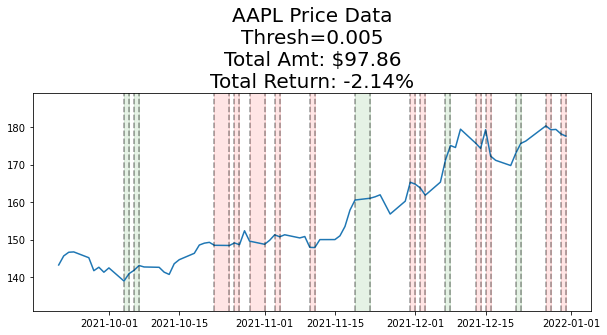

In [14]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (11,0,0), thresh, verbose=False)

# Try ARMA(11,11) Model

  0%|                                                    | 0/71 [00:00<?, ?it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.99450D+00    |proj g|=  1.52203D+02

At iterate    5    f= -3.00416D+00    |proj g|=  4.72378D+01
  ys=-2.079E-06  -gs= 6.725E-06 BFGS update SKIPPED
  ys=-1.183E-05  -gs= 1.759E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()

 Line search cannot locate an adequate point after MAXLS
  function an


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23      9     73      2     2     0   9.040D+01  -3.004D+00
  F =  -3.0041630842342699     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 18%|███████▊                                   | 13/71 [00:13<01:02,  1.07s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.10002D+00    |proj g|=  2.38329D+00


 This problem is unconstrained.



At iterate    5    f= -3.22055D+00    |proj g|=  1.12800D+00

At iterate   10    f= -3.22320D+00    |proj g|=  5.73628D-01

At iterate   15    f= -3.23902D+00    |proj g|=  7.61612D+00

At iterate   20    f= -3.25224D+00    |proj g|=  8.51329D-01

At iterate   25    f= -3.28619D+00    |proj g|=  1.81899D+01

At iterate   30    f= -3.31735D+00    |proj g|=  2.17883D+00

At iterate   35    f= -3.32792D+00    |proj g|=  2.78111D+01

At iterate   40    f= -3.34578D+00    |proj g|=  9.08759D-02

At iterate   45    f= -3.34586D+00    |proj g|=  2.05985D+00

At iterate   50    f= -3.34666D+00    |proj g|=  1.78545D+00

At iterate   55    f= -3.34768D+00    |proj g|=  7.82767D-01

At iterate   60    f= -3.35567D+00    |proj g|=  1.18052D+01

At iterate   65    f= -3.35592D+00    |proj g|=  4.29357D-01

At iterate   70    f= -3.35593D+00    |proj g|=  1.11741D-01

At iterate   75    f= -3.35598D+00    |proj g|=  9.68988D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   80    f= -3.35628D+00    |proj g|=  5.34255D-02

At iterate   85    f= -3.35635D+00    |proj g|=  6.95621D+00

At iterate   90    f= -3.35692D+00    |proj g|=  6.75462D-01

At iterate   95    f= -3.36065D+00    |proj g|=  2.28278D+00

At iterate  100    f= -3.36080D+00    |proj g|=  2.63427D-01

At iterate  105    f= -3.36434D+00    |proj g|=  9.48794D-02

At iterate  110    f= -3.36475D+00    |proj g|=  9.65442D-01

At iterate  115    f= -3.36687D+00    |proj g|=  3.03735D-01

At iterate  120    f= -3.36796D+00    |proj g|=  1.88768D-01

At iterate  125    f= -3.36976D+00    |proj g|=  4.48501D+00

At iterate  130    f= -3.37206D+00    |proj g|=  8.93429D-02

At iterate  135    f= -3.37226D+00    |proj g|=  4.25771D-01

At iterate  140    f= -3.37251D+00    |proj g|=  3.17446D-01

At iterate  145    f= -3.37416D+00    |proj g|=  6.36551D-01

At iterate  150    f= -3.37424D+00    |proj g|=  5.97120D-02

At iterate  155    f= -3.37425D+00    |proj g|=  6.60578D-01

At iter

 20%|████████▍                                  | 14/71 [00:55<04:48,  5.07s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.99155D+00    |proj g|=  6.91850D+00

At iterate    5    f= -2.99443D+00    |proj g|=  1.91091D+01

At iterate   10    f= -3.03990D+00    |proj g|=  7.54913D+00

At iterate   15    f= -3.04156D+00    |proj g|=  8.10853D+00

At iterate   20    f= -3.06928D+00    |proj g|=  9.75192D+00

At iterate   25    f= -3.07351D+00    |proj g|=  7.62351D+00

At iterate   30    f= -3.08166D+00    |proj g|=  2.84224D+00

At iterate   35    f= -3.08472D+00    |proj g|=  1.68601D+01

At iterate   40    f= -3.15194D+00    |proj g|=  4.92506D+01

At iterate   45    f= -3.18756D+00    |proj g|=  2.41345D-01

At iterate   50    f= -3.19439D+00    |proj g|=  5.87554D+00

At iterate   55    f= -3.25142D+00    |proj g|=  4.86505D+00

At iterate   60    f= -3.25170D+00    |proj g|=  6.94160D-01

At iterate   65    f= -3.2

 21%|█████████                                  | 15/71 [01:35<08:46,  9.40s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.07332D+00    |proj g|=  3.60939D+01

At iterate    5    f= -3.07794D+00    |proj g|=  1.48845D+01

At iterate   10    f= -3.15702D+00    |proj g|=  1.23917D+02

At iterate   15    f= -3.22817D+00    |proj g|=  1.78856D-01

At iterate   20    f= -3.22885D+00    |proj g|=  1.34908D+01

At iterate   25    f= -3.24169D+00    |proj g|=  8.74781D+00

At iterate   30    f= -3.24199D+00    |proj g|=  1.44607D+00

At iterate   35    f= -3.25716D+00    |proj g|=  1.12663D+01

At iterate   40    f= -3.27904D+00    |proj g|=  4.19894D-01

At iterate   45    f= -3.28031D+00    |proj g|=  5.41637D+00

At iterate   50    f= -3.31567D+00    |proj g|=  1.34517D+01

At iterate   55    f= -3.31934D+00    |proj g|=  2.11448D-01

At iterate   60    f= -3.35360D+00    |proj g|=  1.45504D-01

At iterate   65    f= -3.3

 23%|█████████▋                                 | 16/71 [02:14<12:39, 13.81s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.72026D+00    |proj g|=  1.95608D+05


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23      3     33      1     0     0   4.660D+05   5.718D+00
  F =   5.7184586153308157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 25%|██████████▉                                | 18/71 [02:23<09:47, 11.08s/it]/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:728: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
 This problem is unconstrained.
 28%|████████████                               | 20/71 [02:25<06:46,  7.97s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=          NaN    |proj g|=          NaN


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80198D+00    |proj g|=  7.86017D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-3.104E+02  -gs= 3.187E+00 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23      3     52      3     1     0   1.226D+02  -1.118D+00
  F =  -1.1182227205378694     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 31%|█████████████▎                             | 22/71 [02:41<06:15,  7.66s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=          NaN    |proj g|=          NaN


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57768D+00    |proj g|=  4.22571D+00

At iterate    5    f=  3.57768D+00    |proj g|=  2.10984D+00

At iterate   10    f=  3.57747D+00    |proj g|=  2.12831D+00

At iterate   15    f=  2.30136D+00    |proj g|=  4.63567D+01
  ys=-2.662E+01  -gs= 1.312E+00 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     17    113      2     1     0   4.053D+01   2.301D+00
  F =   2.3013581392986326     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 32%|█████████████▉                             | 23/71 [03:09<09:45, 12.21s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37916D+00    |proj g|=  1.75354D+00

At iterate    5    f= -2.92582D+00    |proj g|=  6.39208D+00

At iterate   10    f= -3.00363D+00    |proj g|=  7.10664D+01

At iterate   15    f= -3.04995D+00    |proj g|=  2.05818D+00

At iterate   20    f= -3.16169D+00    |proj g|=  2.56876D+01

At iterate   25    f= -3.17095D+00    |proj g|=  9.25622D+00

At iterate   30    f= -3.22576D+00    |proj g|=  7.42267D+00

At iterate   35    f= -3.29636D+00    |proj g|=  4.37819D+00

At iterate   40    f= -3.30349D+00    |proj g|=  8.13111D-01

At iterate   45    f= -3.30912D+00    |proj g|=  3.16577D+00

At iterate   50    f= -3.31152D+00    |proj g|=  9.66170D-01

At iterate   55    f= -3.31212D+00    |proj g|=  6.95141D-02

At iterate   60    f= -3.31223D+00    |proj g|=  7.95551D-02

At iterate   65    f= -3.3

 34%|██████████████▌                            | 24/71 [04:08<18:28, 23.59s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27666D+00    |proj g|=  7.29616D-01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23      1     21      1     0     0   7.296D-01   3.277D+00
  F =   3.2766607417073943     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 35%|███████████████▏                           | 25/71 [04:17<15:14, 19.89s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89471D-01    |proj g|=  7.83635D+00


 This problem is unconstrained.



At iterate    5    f= -2.99484D+00    |proj g|=  3.79267D+00

At iterate   10    f= -2.99934D+00    |proj g|=  2.89753D+00

At iterate   15    f= -3.02009D+00    |proj g|=  5.09296D+01

At iterate   20    f= -3.16238D+00    |proj g|=  3.71075D+00

At iterate   25    f= -3.21141D+00    |proj g|=  8.54339D+00

At iterate   30    f= -3.24067D+00    |proj g|=  7.88974D-01

At iterate   35    f= -3.24114D+00    |proj g|=  3.99994D+00

At iterate   40    f= -3.24881D+00    |proj g|=  5.59833D+00

At iterate   45    f= -3.24971D+00    |proj g|=  1.86423D-01

At iterate   50    f= -3.25424D+00    |proj g|=  2.67152D+00

At iterate   55    f= -3.25444D+00    |proj g|=  2.48367D-01

At iterate   60    f= -3.25476D+00    |proj g|=  5.20936D-01

At iterate   65    f= -3.26169D+00    |proj g|=  3.65642D+00

At iterate   70    f= -3.26603D+00    |proj g|=  2.56523D-01

At iterate   75    f= -3.26667D+00    |proj g|=  1.00531D+00

At iterate   80    f= -3.26811D+00    |proj g|=  2.81699D+00

At iter

 38%|████████████████▎                          | 27/71 [05:06<15:53, 21.66s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.02682D+00    |proj g|=  3.92331D+01


 This problem is unconstrained.



At iterate    5    f= -3.07698D+00    |proj g|=  1.98972D+00

At iterate   10    f= -3.09515D+00    |proj g|=  8.71496D+00
  ys=-1.243E-01  -gs= 4.150E-02 BFGS update SKIPPED

At iterate   15    f= -3.18350D+00    |proj g|=  3.22799D+00

At iterate   20    f= -3.18656D+00    |proj g|=  3.21285D+00

At iterate   25    f= -3.21600D+00    |proj g|=  4.99091D-01

At iterate   30    f= -3.22885D+00    |proj g|=  1.12288D+00

At iterate   35    f= -3.23068D+00    |proj g|=  9.22471D-01

At iterate   40    f= -3.24884D+00    |proj g|=  3.44456D-01

At iterate   45    f= -3.25163D+00    |proj g|=  2.28925D-01

At iterate   50    f= -3.26391D+00    |proj g|=  1.21493D+01

At iterate   55    f= -3.26964D+00    |proj g|=  6.84871D-02

At iterate   60    f= -3.27121D+00    |proj g|=  2.91304D-01

At iterate   65    f= -3.27649D+00    |proj g|=  6.09107D-01

At iterate   70    f= -3.27735D+00    |proj g|=  4.47428D-02

At iterate   75    f= -3.27905D+00    |proj g|=  9.55707D-01

At iterate   80  

 39%|████████████████▉                          | 28/71 [05:48<18:59, 26.50s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08552D+00    |proj g|=  4.19859D+01


 This problem is unconstrained.



At iterate    5    f= -3.11796D+00    |proj g|=  7.87834D+00

At iterate   10    f= -3.14198D+00    |proj g|=  7.05195D-01

At iterate   15    f= -3.15119D+00    |proj g|=  1.68111D+01

At iterate   20    f= -3.23767D+00    |proj g|=  1.81929D+01

At iterate   25    f= -3.24627D+00    |proj g|=  1.58295D+00

At iterate   30    f= -3.25851D+00    |proj g|=  1.81148D+00

At iterate   35    f= -3.26002D+00    |proj g|=  1.32918D+00

At iterate   40    f= -3.26644D+00    |proj g|=  1.49989D+00

At iterate   45    f= -3.26864D+00    |proj g|=  3.82023D-01

At iterate   50    f= -3.28556D+00    |proj g|=  3.44119D+00

At iterate   55    f= -3.28765D+00    |proj g|=  1.26332D-01

At iterate   60    f= -3.28818D+00    |proj g|=  1.30727D+00

At iterate   65    f= -3.29287D+00    |proj g|=  1.52126D-01

At iterate   70    f= -3.29299D+00    |proj g|=  2.89764D-01

At iterate   75    f= -3.29640D+00    |proj g|=  2.21522D-01

At iterate   80    f= -3.29936D+00    |proj g|=  2.50605D-01

At iter

 41%|█████████████████▌                         | 29/71 [06:26<20:31, 29.32s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.29071D+00    |proj g|=  1.48570D+02


 This problem is unconstrained.



At iterate    5    f= -2.55812D+00    |proj g|=  5.69345D+01

At iterate   10    f= -2.85541D+00    |proj g|=  1.66871D+01

At iterate   15    f= -2.87496D+00    |proj g|=  1.40219D+00

At iterate   20    f= -2.94627D+00    |proj g|=  9.27683D-01

At iterate   25    f= -3.00761D+00    |proj g|=  7.23121D+00

At iterate   30    f= -3.06721D+00    |proj g|=  9.13939D-01

At iterate   35    f= -3.07210D+00    |proj g|=  1.18299D+00

At iterate   40    f= -3.11533D+00    |proj g|=  4.06564D+01

At iterate   45    f= -3.17635D+00    |proj g|=  2.10156D-01

At iterate   50    f= -3.19646D+00    |proj g|=  4.78561D+01

At iterate   55    f= -3.21012D+00    |proj g|=  1.76194D+00

At iterate   60    f= -3.21105D+00    |proj g|=  1.43733D+00

At iterate   65    f= -3.21247D+00    |proj g|=  4.51907D-01

At iterate   70    f= -3.21307D+00    |proj g|=  3.65363D+00

At iterate   75    f= -3.23908D+00    |proj g|=  2.08223D+00

At iterate   80    f= -3.24023D+00    |proj g|=  7.60195D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  115    f= -3.28029D+00    |proj g|=  1.77774D+00

At iterate  120    f= -3.28205D+00    |proj g|=  5.88164D-01

At iterate  125    f= -3.28381D+00    |proj g|=  1.65658D-01

At iterate  130    f= -3.28522D+00    |proj g|=  5.65604D+00

At iterate  135    f= -3.29090D+00    |proj g|=  1.43802D+00

At iterate  140    f= -3.29095D+00    |proj g|=  8.03036D-01

At iterate  145    f= -3.29154D+00    |proj g|=  7.19002D+00

At iterate  150    f= -3.30193D+00    |proj g|=  1.17867D+01

At iterate  155    f= -3.30312D+00    |proj g|=  3.42774D+00

At iterate  160    f= -3.30334D+00    |proj g|=  1.91253D+00

At iterate  165    f= -3.30533D+00    |proj g|=  1.29816D+00

At iterate  170    f= -3.30612D+00    |proj g|=  4.71444D+00

At iterate  175    f= -3.30686D+00    |proj g|=  1.37835D+00

At iterate  180    f= -3.31615D+00    |proj g|=  1.93467D+01

At iterate  185    f= -3.31862D+00    |proj g|=  9.18281D-02

At iterate  190    f= -3.32396D+00    |proj g|=  4.34463D+00

At iter

 42%|██████████████████▏                        | 30/71 [07:06<22:03, 32.27s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94502D+00    |proj g|=  1.49397D+01


 This problem is unconstrained.



At iterate    5    f= -2.94907D+00    |proj g|=  2.21549D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     10     71      2     0     0   6.066D+00  -2.949D+00
  F =  -2.9491347557694310     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 45%|███████████████████▍                       | 32/71 [07:23<14:17, 21.98s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.97245D+00    |proj g|=  3.92470D+01


 This problem is unconstrained.



At iterate    5    f= -3.01313D+00    |proj g|=  3.20869D+00

At iterate   10    f= -3.02941D+00    |proj g|=  5.88944D+00

At iterate   15    f= -3.03719D+00    |proj g|=  4.73820D+00

At iterate   20    f= -3.15088D+00    |proj g|=  4.00732D-01

At iterate   25    f= -3.17776D+00    |proj g|=  1.25124D+00

At iterate   30    f= -3.20628D+00    |proj g|=  8.21808D-01

At iterate   35    f= -3.23001D+00    |proj g|=  4.74198D-01

At iterate   40    f= -3.23833D+00    |proj g|=  6.07689D-01

At iterate   45    f= -3.24663D+00    |proj g|=  1.41447D-01

At iterate   50    f= -3.24678D+00    |proj g|=  1.09006D+00

At iterate   55    f= -3.24850D+00    |proj g|=  1.31303D+00

At iterate   60    f= -3.25820D+00    |proj g|=  3.82343D-01

At iterate   65    f= -3.25844D+00    |proj g|=  2.56527D-01

At iterate   70    f= -3.26191D+00    |proj g|=  1.17312D+00

At iterate   75    f= -3.26372D+00    |proj g|=  7.10852D-01

At iterate   80    f= -3.26472D+00    |proj g|=  8.17374D-01

At iter

 46%|███████████████████▉                       | 33/71 [08:18<18:48, 29.69s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.07106D+00    |proj g|=  2.09554D+01

At iterate    5    f= -3.08530D+00    |proj g|=  1.03965D+01

At iterate   10    f= -3.09792D+00    |proj g|=  8.24037D+00

At iterate   15    f= -3.10890D+00    |proj g|=  5.54187D-01

At iterate   20    f= -3.19341D+00    |proj g|=  9.73359D+00

At iterate   25    f= -3.21116D+00    |proj g|=  8.50410D+00

At iterate   30    f= -3.21427D+00    |proj g|=  2.39841D+00

At iterate   35    f= -3.24009D+00    |proj g|=  1.60920D-01

At iterate   40    f= -3.24216D+00    |proj g|=  1.47135D+00

At iterate   45    f= -3.25108D+00    |proj g|=  1.45331D+00

At iterate   50    f= -3.26278D+00    |proj g|=  6.76139D-01

At iterate   55    f= -3.27297D+00    |proj g|=  4.01817D+00

At iterate   60    f= -3.27500D+00    |proj g|=  5.40863D-02

At iterate   65    f= -3.2


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  120    f= -3.28542D+00    |proj g|=  2.44853D-02

At iterate  125    f= -3.28545D+00    |proj g|=  9.89001D-02

At iterate  130    f= -3.28553D+00    |proj g|=  1.64112D-01

At iterate  135    f= -3.28556D+00    |proj g|=  1.35707D-01

At iterate  140    f= -3.28557D+00    |proj g|=  7.94240D-02

At iterate  145    f= -3.28563D+00    |proj g|=  5.00380D-01

At iterate  150    f= -3.28576D+00    |proj g|=  1.01593D-01

At iterate  155    f= -3.28579D+00    |proj g|=  1.39188D-01

At iterate  160    f= -3.28580D+00    |proj g|=  1.69019D-02

At iterate  165    f= -3.28584D+00    |proj g|=  9.62216D-02

At iterate  170    f= -3.28595D+00    |proj g|=  2.24767D-02

At iterate  175    f= -3.28595D+00    |proj g|=  3.35650D-02

At iterate  180    f= -3.28596D+00    |proj g|=  3.28937D-02

At iterate  185    f= -3.28597D+00    |proj g|=  2.16742D-02

At iterate  190    f= -3.28598D+00    |proj g|=  1.58224D-01

At iterate  195    f= -3.28599D+00    |proj g|=  4.62768D-03

At iter

 48%|████████████████████▌                      | 34/71 [09:10<21:49, 35.40s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.87426D+00    |proj g|=  7.95447D+01

At iterate    5    f= -2.93023D+00    |proj g|=  4.92796D+01

At iterate   10    f= -3.09702D+00    |proj g|=  2.16666D+00

At iterate   15    f= -3.15530D+00    |proj g|=  2.72389D-01

At iterate   20    f= -3.15583D+00    |proj g|=  4.91947D+00

At iterate   25    f= -3.16736D+00    |proj g|=  5.14612D+00

At iterate   30    f= -3.16817D+00    |proj g|=  1.34982D-01

At iterate   35    f= -3.19909D+00    |proj g|=  4.15679D+00

At iterate   40    f= -3.22283D+00    |proj g|=  1.27026D+00

At iterate   45    f= -3.23031D+00    |proj g|=  2.03347D-01

At iterate   50    f= -3.23693D+00    |proj g|=  1.50935D-01

At iterate   55    f= -3.24361D+00    |proj g|=  4.51536D+00

At iterate   60    f= -3.25038D+00    |proj g|=  5.05075D-01

At iterate   65    f= -3.2


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  155    f= -3.26335D+00    |proj g|=  4.96327D-02

At iterate  160    f= -3.26567D+00    |proj g|=  6.70413D-02

At iterate  165    f= -3.26707D+00    |proj g|=  5.99962D+00

At iterate  170    f= -3.27104D+00    |proj g|=  2.68294D-02

At iterate  175    f= -3.27107D+00    |proj g|=  2.11744D-01

At iterate  180    f= -3.27119D+00    |proj g|=  8.45475D-01

At iterate  185    f= -3.27147D+00    |proj g|=  6.71050D-02

At iterate  190    f= -3.27635D+00    |proj g|=  1.08711D+00

At iterate  195    f= -3.27723D+00    |proj g|=  2.02865D+00

At iterate  200    f= -3.27829D+00    |proj g|=  1.01568D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 51%|█████████████████████▊                     | 36/71 [09:53<17:11, 29.47s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.35440D+00    |proj g|=  2.56674D+00


 This problem is unconstrained.



At iterate    5    f= -2.84888D+00    |proj g|=  1.82163D+01

At iterate   10    f= -3.06888D+00    |proj g|=  1.68381D+00

At iterate   15    f= -3.13323D+00    |proj g|=  8.43992D-01

At iterate   20    f= -3.18343D+00    |proj g|=  1.56634D-01

At iterate   25    f= -3.18874D+00    |proj g|=  6.35342D-02

At iterate   30    f= -3.19421D+00    |proj g|=  7.38740D-02

At iterate   35    f= -3.19502D+00    |proj g|=  1.86802D-01

At iterate   40    f= -3.19564D+00    |proj g|=  2.02247D-01

At iterate   45    f= -3.19791D+00    |proj g|=  3.61353D-01

At iterate   50    f= -3.19948D+00    |proj g|=  4.48758D-02

At iterate   55    f= -3.19962D+00    |proj g|=  3.96802D-02

At iterate   60    f= -3.19980D+00    |proj g|=  2.03525D-01

At iterate   65    f= -3.19986D+00    |proj g|=  4.32730D-02

At iterate   70    f= -3.19992D+00    |proj g|=  4.69259D-02

At iterate   75    f= -3.20059D+00    |proj g|=  5.48962D-02

At iterate   80    f= -3.20091D+00    |proj g|=  3.80440D-01

At iter

 54%|███████████████████████                    | 38/71 [10:39<14:55, 27.15s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.86361D+00    |proj g|=  1.17130D+01


 This problem is unconstrained.



At iterate    5    f= -3.03873D+00    |proj g|=  3.50925D-01

At iterate   10    f= -3.08757D+00    |proj g|=  5.82716D-01

At iterate   15    f= -3.14118D+00    |proj g|=  2.82144D+00

At iterate   20    f= -3.15711D+00    |proj g|=  2.29536D-01

At iterate   25    f= -3.16265D+00    |proj g|=  2.21348D-02

At iterate   30    f= -3.16345D+00    |proj g|=  4.12068D-01

At iterate   35    f= -3.16706D+00    |proj g|=  1.73107D-01

At iterate   40    f= -3.16804D+00    |proj g|=  5.15481D-02

At iterate   45    f= -3.16821D+00    |proj g|=  4.37881D-01

At iterate   50    f= -3.16841D+00    |proj g|=  3.92323D-01

At iterate   55    f= -3.16912D+00    |proj g|=  1.26203D-01

At iterate   60    f= -3.16947D+00    |proj g|=  3.87538D-01

At iterate   65    f= -3.16958D+00    |proj g|=  7.84100D-02

At iterate   70    f= -3.16964D+00    |proj g|=  3.64949D-02

At iterate   75    f= -3.16988D+00    |proj g|=  1.07159D-01

At iterate   80    f= -3.17207D+00    |proj g|=  1.41422D-01

At iter

 56%|████████████████████████▏                  | 40/71 [11:30<13:41, 26.50s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.05683D+00    |proj g|=  5.54964D-01

At iterate    5    f= -3.09948D+00    |proj g|=  3.94967D-01

At iterate   10    f= -3.14441D+00    |proj g|=  8.71813D-01

At iterate   15    f= -3.16129D+00    |proj g|=  1.45802D-01

At iterate   20    f= -3.17243D+00    |proj g|=  3.66542D-02

At iterate   25    f= -3.17595D+00    |proj g|=  1.20237D+00

At iterate   30    f= -3.17679D+00    |proj g|=  4.88414D-02

At iterate   35    f= -3.17714D+00    |proj g|=  2.82144D-01

At iterate   40    f= -3.17999D+00    |proj g|=  1.28174D+00

At iterate   45    f= -3.18491D+00    |proj g|=  1.03558D-01

At iterate   50    f= -3.18790D+00    |proj g|=  1.69288D-01

At iterate   55    f= -3.18830D+00    |proj g|=  1.87958D-02

At iterate   60    f= -3.18884D+00    |proj g|=  4.86313D-02

At iterate   65    f= -3.1

 58%|████████████████████████▊                  | 41/71 [12:11<14:40, 29.35s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.75690D+00    |proj g|=  4.73585D+00


 This problem is unconstrained.



At iterate    5    f= -2.84846D+00    |proj g|=  8.20490D-01

At iterate   10    f= -2.92912D+00    |proj g|=  3.13588D+00

At iterate   15    f= -3.05614D+00    |proj g|=  2.24354D-01

At iterate   20    f= -3.06748D+00    |proj g|=  1.46983D-01

At iterate   25    f= -3.08609D+00    |proj g|=  1.24295D-01

At iterate   30    f= -3.09438D+00    |proj g|=  2.54243D+00

At iterate   35    f= -3.09936D+00    |proj g|=  7.10227D-01

At iterate   40    f= -3.10078D+00    |proj g|=  6.40284D-02

At iterate   45    f= -3.10607D+00    |proj g|=  1.00202D-01

At iterate   50    f= -3.11626D+00    |proj g|=  1.30715D-01

At iterate   55    f= -3.11741D+00    |proj g|=  1.54711D-02

At iterate   60    f= -3.11859D+00    |proj g|=  7.13478D-01

At iterate   65    f= -3.11982D+00    |proj g|=  9.73962D-02

At iterate   70    f= -3.11984D+00    |proj g|=  6.06582D-02

At iterate   75    f= -3.12087D+00    |proj g|=  1.25422D+00

At iterate   80    f= -3.12127D+00    |proj g|=  1.75837D-01

At iter

 59%|█████████████████████████▍                 | 42/71 [12:51<15:24, 31.87s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.53413D+00    |proj g|=  5.76467D+01

At iterate    5    f= -2.58188D+00    |proj g|=  1.42711D+01

At iterate   10    f= -2.65472D+00    |proj g|=  1.42619D+00

At iterate   15    f= -2.66892D+00    |proj g|=  5.14525D+00

At iterate   20    f= -2.83090D+00    |proj g|=  6.07179D-01

At iterate   25    f= -2.83228D+00    |proj g|=  6.07899D+00

At iterate   30    f= -2.89525D+00    |proj g|=  4.80762D+01

At iterate   35    f= -2.92251D+00    |proj g|=  2.31381D-01

At iterate   40    f= -2.98753D+00    |proj g|=  8.01061D+00

At iterate   45    f= -3.00152D+00    |proj g|=  1.29198D+00

At iterate   50    f= -3.01508D+00    |proj g|=  1.19922D+01

At iterate   55    f= -3.02337D+00    |proj g|=  4.66179D-01

At iterate   60    f= -3.02387D+00    |proj g|=  1.28542D+00

At iterate   65    f= -3.0

 61%|██████████████████████████                 | 43/71 [13:35<16:09, 34.61s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.56278D+00    |proj g|=  9.19321D+01


 This problem is unconstrained.



At iterate    5    f= -2.64980D+00    |proj g|=  5.81879D+00

At iterate   10    f= -2.70098D+00    |proj g|=  4.07087D+01

At iterate   15    f= -2.71454D+00    |proj g|=  9.94583D+00

At iterate   20    f= -2.83534D+00    |proj g|=  1.90366D+01

At iterate   25    f= -2.84289D+00    |proj g|=  2.27104D-01

At iterate   30    f= -2.93111D+00    |proj g|=  1.49951D+01

At iterate   35    f= -2.96998D+00    |proj g|=  2.18409D+01

At iterate   40    f= -3.00159D+00    |proj g|=  2.07897D-01

At iterate   45    f= -3.00258D+00    |proj g|=  2.63370D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f= -3.03265D+00    |proj g|=  8.46226D-01

At iterate   55    f= -3.03320D+00    |proj g|=  4.86558D+00

At iterate   60    f= -3.04152D+00    |proj g|=  8.19375D-01

At iterate   65    f= -3.04624D+00    |proj g|=  1.14647D+01

At iterate   70    f= -3.05219D+00    |proj g|=  5.73563D-01

At iterate   75    f= -3.05689D+00    |proj g|=  1.99050D+00

At iterate   80    f= -3.05764D+00    |proj g|=  5.76448D-01

At iterate   85    f= -3.06754D+00    |proj g|=  1.27293D+00

At iterate   90    f= -3.08345D+00    |proj g|=  1.02038D-01

At iterate   95    f= -3.08373D+00    |proj g|=  1.26385D-01

At iterate  100    f= -3.08405D+00    |proj g|=  2.03015D+00

At iterate  105    f= -3.08561D+00    |proj g|=  4.56478D-02

At iterate  110    f= -3.08564D+00    |proj g|=  1.49317D-01

At iterate  115    f= -3.08571D+00    |proj g|=  3.19107D-01

At iterate  120    f= -3.08610D+00    |proj g|=  2.19813D-01

At iterate  125    f= -3.08627D+00    |proj g|=  5.49876D-02

At iter

 63%|███████████████████████████▎               | 45/71 [14:14<12:20, 28.47s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.70724D+00    |proj g|=  3.40461D+00

At iterate    5    f= -2.86053D+00    |proj g|=  2.95989D+00

At iterate   10    f= -3.08976D+00    |proj g|=  3.93508D+00

At iterate   15    f= -3.09996D+00    |proj g|=  6.65922D-02

At iterate   20    f= -3.11621D+00    |proj g|=  3.12493D+00

At iterate   25    f= -3.12355D+00    |proj g|=  4.72055D-01

At iterate   30    f= -3.13751D+00    |proj g|=  1.35364D-01

At iterate   35    f= -3.13840D+00    |proj g|=  3.21361D-01

At iterate   40    f= -3.13888D+00    |proj g|=  5.24794D-01

At iterate   45    f= -3.14611D+00    |proj g|=  2.46552D-01

At iterate   50    f= -3.14634D+00    |proj g|=  2.24264D-01

At iterate   55    f= -3.14653D+00    |proj g|=  6.96575D-02

At iterate   60    f= -3.14725D+00    |proj g|=  2.47065D-01

At iterate   65    f= -3.1

 65%|███████████████████████████▊               | 46/71 [15:10<14:26, 34.65s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.59159D+00    |proj g|=  2.45137D+02

At iterate    5    f= -2.90919D+00    |proj g|=  3.59085D+00

At iterate   10    f= -2.91559D+00    |proj g|=  4.88746D+01

At iterate   15    f= -2.94619D+00    |proj g|=  1.26983D+00

At iterate   20    f= -2.94810D+00    |proj g|=  4.03238D+00

At iterate   25    f= -2.97559D+00    |proj g|=  4.72239D+00

At iterate   30    f= -2.99206D+00    |proj g|=  2.10850D+01

At iterate   35    f= -3.05853D+00    |proj g|=  8.30362D+00

At iterate   40    f= -3.05920D+00    |proj g|=  3.26363D-01

At iterate   45    f= -3.06173D+00    |proj g|=  1.77715D+00

At iterate   50    f= -3.06178D+00    |proj g|=  1.91143D-01

At iterate   55    f= -3.06217D+00    |proj g|=  1.79641D+00

At iterate   60    f= -3.06942D+00    |proj g|=  5.30525D+00

At iterate   65    f= -3.0

 66%|████████████████████████████▍              | 47/71 [15:55<14:53, 37.23s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.14994D+00    |proj g|=  2.28661D+02

At iterate    5    f= -2.76699D+00    |proj g|=  3.74553D-01

At iterate   10    f= -2.76762D+00    |proj g|=  1.66798D+01

At iterate   15    f= -2.80280D+00    |proj g|=  8.04033D+01

At iterate   20    f= -2.82046D+00    |proj g|=  2.05892D-01

At iterate   25    f= -2.82186D+00    |proj g|=  1.17071D+01

At iterate   30    f= -2.88735D+00    |proj g|=  4.73477D+01

At iterate   35    f= -2.91301D+00    |proj g|=  7.91721D+00

At iterate   40    f= -3.02464D+00    |proj g|=  1.87437D+01

At iterate   45    f= -3.02981D+00    |proj g|=  1.44864D+00

At iterate   50    f= -3.03454D+00    |proj g|=  6.59409D+00

At iterate   55    f= -3.03645D+00    |proj g|=  2.30758D-01

At iterate   60    f= -3.03701D+00    |proj g|=  9.97834D-01

At iterate   65    f= -3.0


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   85    f= -3.04808D+00    |proj g|=  2.65692D+00

At iterate   90    f= -3.04978D+00    |proj g|=  1.71470D+00

At iterate   95    f= -3.04990D+00    |proj g|=  9.96356D-02

At iterate  100    f= -3.05016D+00    |proj g|=  1.68141D+00

At iterate  105    f= -3.05216D+00    |proj g|=  2.53754D+00

At iterate  110    f= -3.05335D+00    |proj g|=  3.47920D+00

At iterate  115    f= -3.05506D+00    |proj g|=  1.19440D-01

At iterate  120    f= -3.05594D+00    |proj g|=  3.47493D+00

At iterate  125    f= -3.05896D+00    |proj g|=  2.22603D-01

At iterate  130    f= -3.05918D+00    |proj g|=  1.24291D-01

At iterate  135    f= -3.05971D+00    |proj g|=  3.81896D-01

At iterate  140    f= -3.06151D+00    |proj g|=  3.01365D-01

At iterate  145    f= -3.06182D+00    |proj g|=  6.15784D-01

At iterate  150    f= -3.06490D+00    |proj g|=  9.37554D-02

At iterate  155    f= -3.06639D+00    |proj g|=  1.89606D+00

At iterate  160    f= -3.06928D+00    |proj g|=  3.78703D+00

At iter

 68%|█████████████████████████████              | 48/71 [16:33<14:23, 37.54s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.00300D+00    |proj g|=  1.34096D+00


 This problem is unconstrained.



At iterate    5    f= -3.00754D+00    |proj g|=  2.42710D+00

At iterate   10    f= -3.03065D+00    |proj g|=  2.55029D-01

At iterate   15    f= -3.03500D+00    |proj g|=  1.68962D+00

At iterate   20    f= -3.03922D+00    |proj g|=  1.88136D+00

At iterate   25    f= -3.05554D+00    |proj g|=  6.71440D-01

At iterate   30    f= -3.05685D+00    |proj g|=  3.94306D-01

At iterate   35    f= -3.06483D+00    |proj g|=  1.13394D+00

At iterate   40    f= -3.06613D+00    |proj g|=  5.06291D-01

At iterate   45    f= -3.07083D+00    |proj g|=  5.61452D-02

At iterate   50    f= -3.07206D+00    |proj g|=  7.08173D-01

At iterate   55    f= -3.07432D+00    |proj g|=  1.64930D-01

At iterate   60    f= -3.07461D+00    |proj g|=  3.93744D-01

At iterate   65    f= -3.07483D+00    |proj g|=  1.67830D-01

At iterate   70    f= -3.07549D+00    |proj g|=  2.38587D-01

At iterate   75    f= -3.07608D+00    |proj g|=  2.97586D-02

At iterate   80    f= -3.07736D+00    |proj g|=  5.26518D-01

At iter

 69%|█████████████████████████████▋             | 49/71 [17:25<15:06, 41.23s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94526D+00    |proj g|=  1.53371D+00

At iterate    5    f= -2.94926D+00    |proj g|=  2.39052D+00

At iterate   10    f= -2.97334D+00    |proj g|=  4.29952D-01

At iterate   15    f= -2.98609D+00    |proj g|=  7.72577D-01

At iterate   20    f= -2.99383D+00    |proj g|=  3.17256D+00

At iterate   25    f= -2.99978D+00    |proj g|=  6.06374D-01

At iterate   30    f= -3.00869D+00    |proj g|=  3.06367D+00

At iterate   35    f= -3.01477D+00    |proj g|=  4.24159D-01

At iterate   40    f= -3.01585D+00    |proj g|=  2.23645D-01

At iterate   45    f= -3.01862D+00    |proj g|=  9.29933D-01

At iterate   50    f= -3.02187D+00    |proj g|=  5.91097D-01

At iterate   55    f= -3.02737D+00    |proj g|=  2.57049D-01

At iterate   60    f= -3.02881D+00    |proj g|=  7.47876D-02

At iterate   65    f= -3.0

 72%|██████████████████████████████▉            | 51/71 [18:33<12:44, 38.24s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.13283D+00    |proj g|=  2.41391D+02

At iterate    5    f= -2.72568D+00    |proj g|=  5.29429D+00

At iterate   10    f= -2.73853D+00    |proj g|=  7.53711D+01

At iterate   15    f= -2.82342D+00    |proj g|=  7.05215D+00

At iterate   20    f= -2.82372D+00    |proj g|=  2.29195D+00

At iterate   25    f= -2.82877D+00    |proj g|=  3.19605D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -2.92879D+00    |proj g|=  5.86820D+01

At iterate   35    f= -2.93986D+00    |proj g|=  2.32608D+00

At iterate   40    f= -2.94373D+00    |proj g|=  3.18650D+01

At iterate   45    f= -2.96712D+00    |proj g|=  2.92391D-01

At iterate   50    f= -2.97475D+00    |proj g|=  2.69811D+00

At iterate   55    f= -2.99126D+00    |proj g|=  1.72821D-01

At iterate   60    f= -3.00242D+00    |proj g|=  1.72566D-01

At iterate   65    f= -3.00700D+00    |proj g|=  5.07848D+00

At iterate   70    f= -3.04656D+00    |proj g|=  7.53441D+00

At iterate   75    f= -3.04791D+00    |proj g|=  1.85021D-01

At iterate   80    f= -3.04796D+00    |proj g|=  3.65807D-01

At iterate   85    f= -3.05316D+00    |proj g|=  2.93967D+00

At iterate   90    f= -3.05972D+00    |proj g|=  1.30426D+00

At iterate   95    f= -3.06374D+00    |proj g|=  1.36427D+00

At iterate  100    f= -3.06554D+00    |proj g|=  9.98403D-01

At iterate  105    f= -3.06683D+00    |proj g|=  1.86434D-02

At iter

 75%|████████████████████████████████           | 53/71 [19:49<11:25, 38.08s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.66610D+00    |proj g|=  1.35745D+02

At iterate    5    f= -2.75063D+00    |proj g|=  3.73879D+01

At iterate   10    f= -2.83524D+00    |proj g|=  1.00707D+01

At iterate   15    f= -2.87760D+00    |proj g|=  1.80526D+01

At iterate   20    f= -2.89312D+00    |proj g|=  2.54217D+00

At iterate   25    f= -2.90594D+00    |proj g|=  1.95890D+01

At iterate   30    f= -2.93317D+00    |proj g|=  1.34854D+00

At iterate   35    f= -2.93487D+00    |proj g|=  2.23863D+00

At iterate   40    f= -2.94771D+00    |proj g|=  6.39696D+00

At iterate   45    f= -2.97494D+00    |proj g|=  6.70660D-02

At iterate   50    f= -2.97922D+00    |proj g|=  8.10464D+00

At iterate   55    f= -2.98836D+00    |proj g|=  8.17767D-02

At iterate   60    f= -2.98962D+00    |proj g|=  3.23904D+00

At iterate   65    f= -2.9

 76%|████████████████████████████████▋          | 54/71 [21:00<12:47, 45.15s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.49536D+00    |proj g|=  4.38658D+01

At iterate    5    f= -2.84778D+00    |proj g|=  8.61534D-01

At iterate   10    f= -2.86159D+00    |proj g|=  8.71210D+00

At iterate   15    f= -2.88360D+00    |proj g|=  7.51866D+00

At iterate   20    f= -2.89348D+00    |proj g|=  1.84019D+00

At iterate   25    f= -2.92342D+00    |proj g|=  2.34842D+00

At iterate   30    f= -2.93847D+00    |proj g|=  7.42737D-02

At iterate   35    f= -2.94595D+00    |proj g|=  1.02826D+00

At iterate   40    f= -2.95957D+00    |proj g|=  8.55005D-01

At iterate   45    f= -2.96174D+00    |proj g|=  4.74263D-01

At iterate   50    f= -2.96236D+00    |proj g|=  3.60162D-01

At iterate   55    f= -2.96966D+00    |proj g|=  4.22273D+00

At iterate   60    f= -2.98466D+00    |proj g|=  1.27357D+00

At iterate   65    f= -2.9

 79%|█████████████████████████████████▉         | 56/71 [22:09<10:18, 41.21s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.41838D+00    |proj g|=  1.15541D+02

At iterate    5    f= -2.62430D+00    |proj g|=  9.84429D+00

At iterate   10    f= -2.68103D+00    |proj g|=  9.68429D+01

At iterate   15    f= -2.73563D+00    |proj g|=  3.40972D-01

At iterate   20    f= -2.74181D+00    |proj g|=  1.81613D+01

At iterate   25    f= -2.80593D+00    |proj g|=  3.89689D+00

At iterate   30    f= -2.81246D+00    |proj g|=  6.97112D-01

At iterate   35    f= -2.86768D+00    |proj g|=  4.26766D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -2.92589D+00    |proj g|=  2.97956D-01

At iterate   45    f= -2.92599D+00    |proj g|=  2.70815D+00

At iterate   50    f= -2.93192D+00    |proj g|=  1.41221D+01

At iterate   55    f= -2.93501D+00    |proj g|=  2.38818D+00

At iterate   60    f= -2.93927D+00    |proj g|=  4.14553D+00

At iterate   65    f= -2.93957D+00    |proj g|=  4.90980D-01

At iterate   70    f= -2.94065D+00    |proj g|=  4.84653D+00

At iterate   75    f= -2.94332D+00    |proj g|=  6.76784D-02

At iterate   80    f= -2.94872D+00    |proj g|=  7.07745D-02

At iterate   85    f= -2.95390D+00    |proj g|=  2.23084D-01

At iterate   90    f= -2.95452D+00    |proj g|=  7.46757D-02

At iterate   95    f= -2.95484D+00    |proj g|=  1.89917D-01

At iterate  100    f= -2.95545D+00    |proj g|=  2.53388D-01

At iterate  105    f= -2.95570D+00    |proj g|=  9.73233D-01

At iterate  110    f= -2.95637D+00    |proj g|=  1.01190D+00

At iterate  115    f= -2.95833D+00    |proj g|=  1.28715D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  145    f= -2.95968D+00    |proj g|=  9.03099D-01

At iterate  150    f= -2.95987D+00    |proj g|=  5.50460D-02

At iterate  155    f= -2.95994D+00    |proj g|=  6.01819D-01

At iterate  160    f= -2.96010D+00    |proj g|=  1.29106D-01

At iterate  165    f= -2.96045D+00    |proj g|=  1.22567D+00

At iterate  170    f= -2.96128D+00    |proj g|=  1.57898D-01

At iterate  175    f= -2.96165D+00    |proj g|=  8.19145D-01

At iterate  180    f= -2.96181D+00    |proj g|=  1.03279D-01

At iterate  185    f= -2.96190D+00    |proj g|=  1.38007D-01

At iterate  190    f= -2.96227D+00    |proj g|=  3.00266D-01

At iterate  195    f= -2.96234D+00    |proj g|=  1.30948D-01

At iterate  200    f= -2.96257D+00    |proj g|=  1.62180D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 80%|██████████████████████████████████▌        | 57/71 [23:25<11:18, 48.48s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.21357D+00    |proj g|=  1.05947D+02


 This problem is unconstrained.



At iterate    5    f= -2.60265D+00    |proj g|=  4.52393D+01

At iterate   10    f= -2.71378D+00    |proj g|=  3.14910D+01

At iterate   15    f= -2.72033D+00    |proj g|=  2.02913D+00

At iterate   20    f= -2.73252D+00    |proj g|=  2.89358D+01

At iterate   25    f= -2.79904D+00    |proj g|=  2.50072D+01

At iterate   30    f= -2.80743D+00    |proj g|=  4.67521D-01

At iterate   35    f= -2.81006D+00    |proj g|=  1.47520D+01

At iterate   40    f= -2.86022D+00    |proj g|=  7.27853D+00

At iterate   45    f= -2.86191D+00    |proj g|=  1.44134D-01

At iterate   50    f= -2.87844D+00    |proj g|=  3.11555D-01

At iterate   55    f= -2.91573D+00    |proj g|=  2.40750D+00

At iterate   60    f= -2.91929D+00    |proj g|=  2.03226D+00

At iterate   65    f= -2.93471D+00    |proj g|=  1.40114D+00

At iterate   70    f= -2.93547D+00    |proj g|=  4.31346D-01

At iterate   75    f= -2.94391D+00    |proj g|=  3.76337D-01

At iterate   80    f= -2.94437D+00    |proj g|=  6.82199D-01

At iter

 82%|███████████████████████████████████▏       | 58/71 [24:36<11:40, 53.88s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14533D+00    |proj g|=  1.12381D+02

At iterate    5    f= -2.51667D+00    |proj g|=  4.63400D+00

At iterate   10    f= -2.53112D+00    |proj g|=  7.15150D+01

At iterate   15    f= -2.67135D+00    |proj g|=  2.69558D+01

At iterate   20    f= -2.67681D+00    |proj g|=  2.37331D+00

At iterate   25    f= -2.68181D+00    |proj g|=  3.32188D+01

At iterate   30    f= -2.73423D+00    |proj g|=  3.38189D+01

At iterate   35    f= -2.75482D+00    |proj g|=  5.96046D+00

At iterate   40    f= -2.76253D+00    |proj g|=  2.85952D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f= -2.83569D+00    |proj g|=  4.22224D-01

At iterate   50    f= -2.83602D+00    |proj g|=  6.36199D+00

At iterate   55    f= -2.86035D+00    |proj g|=  4.15585D+01

At iterate   60    f= -2.87381D+00    |proj g|=  6.59276D-01

At iterate   65    f= -2.88247D+00    |proj g|=  8.13460D+00

At iterate   70    f= -2.89250D+00    |proj g|=  2.35554D+00

At iterate   75    f= -2.91225D+00    |proj g|=  1.69092D-01

At iterate   80    f= -2.92190D+00    |proj g|=  5.60343D-01

At iterate   85    f= -2.92908D+00    |proj g|=  6.30475D-01

At iterate   90    f= -2.93068D+00    |proj g|=  3.78263D+00

At iterate   95    f= -2.93750D+00    |proj g|=  5.64709D-01

At iterate  100    f= -2.94135D+00    |proj g|=  1.46016D+00

At iterate  105    f= -2.94555D+00    |proj g|=  1.56758D-01

At iterate  110    f= -2.94559D+00    |proj g|=  1.65331D-01

At iterate  115    f= -2.94680D+00    |proj g|=  5.73286D-01

At iterate  120    f= -2.94717D+00    |proj g|=  6.61475D-02

At iter

 85%|████████████████████████████████████▎      | 60/71 [25:52<08:41, 47.38s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88600D+00    |proj g|=  3.05624D+00

At iterate    5    f= -2.90343D+00    |proj g|=  1.41840D-01

At iterate   10    f= -2.90441D+00    |proj g|=  1.23522D+00

At iterate   15    f= -2.90711D+00    |proj g|=  1.40047D-01

At iterate   20    f= -2.90887D+00    |proj g|=  1.14409D+00

At iterate   25    f= -2.91363D+00    |proj g|=  6.93633D-02

At iterate   30    f= -2.92116D+00    |proj g|=  4.05347D-02

At iterate   35    f= -2.92446D+00    |proj g|=  1.49810D-01

At iterate   40    f= -2.93132D+00    |proj g|=  2.62023D-01

At iterate   45    f= -2.93558D+00    |proj g|=  3.58945D-01

At iterate   50    f= -2.93939D+00    |proj g|=  1.45173D-01

At iterate   55    f= -2.94147D+00    |proj g|=  1.52463D-02

At iterate   60    f= -2.94164D+00    |proj g|=  2.47590D-01

At iterate   65    f= -2.9

 87%|█████████████████████████████████████▌     | 62/71 [27:04<06:29, 43.29s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88740D+00    |proj g|=  3.22705D+00

At iterate    5    f= -2.90922D+00    |proj g|=  1.02856D+00

At iterate   10    f= -2.91029D+00    |proj g|=  2.00213D-01

At iterate   15    f= -2.91306D+00    |proj g|=  1.89899D+00

At iterate   20    f= -2.91558D+00    |proj g|=  5.31821D-01

At iterate   25    f= -2.92252D+00    |proj g|=  2.84626D+00

At iterate   30    f= -2.92686D+00    |proj g|=  4.60467D-01

At iterate   35    f= -2.93258D+00    |proj g|=  3.59831D-02

At iterate   40    f= -2.93449D+00    |proj g|=  2.69915D-01

At iterate   45    f= -2.93769D+00    |proj g|=  3.66081D-01

At iterate   50    f= -2.94240D+00    |proj g|=  3.80934D-02

At iterate   55    f= -2.94393D+00    |proj g|=  2.99897D-02

At iterate   60    f= -2.94510D+00    |proj g|=  3.91198D-01

At iterate   65    f= -2.9

 89%|██████████████████████████████████████▏    | 63/71 [28:19<06:39, 49.91s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.92075D+00    |proj g|=  3.38094D+00


 This problem is unconstrained.



At iterate    5    f= -2.93746D+00    |proj g|=  4.58648D+00

At iterate   10    f= -2.94428D+00    |proj g|=  1.13756D-01

At iterate   15    f= -2.94536D+00    |proj g|=  1.42986D+00

At iterate   20    f= -2.94862D+00    |proj g|=  2.79726D-01

At iterate   25    f= -2.95102D+00    |proj g|=  7.31574D-01

At iterate   30    f= -2.95351D+00    |proj g|=  8.95123D-01

At iterate   35    f= -2.95453D+00    |proj g|=  1.32257D-01

At iterate   40    f= -2.95563D+00    |proj g|=  4.46539D-02

At iterate   45    f= -2.95589D+00    |proj g|=  3.48057D-01

At iterate   50    f= -2.95721D+00    |proj g|=  6.81148D-02

At iterate   55    f= -2.95811D+00    |proj g|=  3.55640D-01

At iterate   60    f= -2.95861D+00    |proj g|=  6.99691D-02

At iterate   65    f= -2.95884D+00    |proj g|=  4.90930D-02

At iterate   70    f= -2.95961D+00    |proj g|=  1.72235D-01

At iterate   75    f= -2.96048D+00    |proj g|=  1.25497D-01

At iterate   80    f= -2.96183D+00    |proj g|=  3.18876D-02

At iter

 92%|███████████████████████████████████████▎   | 65/71 [29:32<04:28, 44.83s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.90182D+00    |proj g|=  4.47257D+00

At iterate    5    f= -2.90705D+00    |proj g|=  3.37323D+00

At iterate   10    f= -2.92293D+00    |proj g|=  1.49196D+00

At iterate   15    f= -2.92739D+00    |proj g|=  1.75604D+00

At iterate   20    f= -2.92942D+00    |proj g|=  1.25241D+00

At iterate   25    f= -2.93150D+00    |proj g|=  5.82601D-02

At iterate   30    f= -2.93324D+00    |proj g|=  1.07186D+00

At iterate   35    f= -2.93706D+00    |proj g|=  1.76034D-01

At iterate   40    f= -2.93826D+00    |proj g|=  1.90430D-02

At iterate   45    f= -2.93950D+00    |proj g|=  1.15080D-01

At iterate   50    f= -2.94013D+00    |proj g|=  4.56950D-01

At iterate   55    f= -2.94186D+00    |proj g|=  2.05735D-01

At iterate   60    f= -2.94282D+00    |proj g|=  1.77837D-01

At iterate   65    f= -2.9

 94%|████████████████████████████████████████▌  | 67/71 [30:56<02:55, 43.91s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.91362D+00    |proj g|=  3.39795D+00


 This problem is unconstrained.



At iterate    5    f= -2.92705D+00    |proj g|=  3.68632D+00

At iterate   10    f= -2.93044D+00    |proj g|=  1.87994D+00

At iterate   15    f= -2.93712D+00    |proj g|=  1.02445D-01

At iterate   20    f= -2.93865D+00    |proj g|=  8.84797D-01

At iterate   25    f= -2.94034D+00    |proj g|=  6.99636D-02

At iterate   30    f= -2.94952D+00    |proj g|=  6.86757D-02

At iterate   35    f= -2.95173D+00    |proj g|=  1.75955D-01

At iterate   40    f= -2.95310D+00    |proj g|=  1.29539D-02

At iterate   45    f= -2.95536D+00    |proj g|=  2.03606D-02

At iterate   50    f= -2.95555D+00    |proj g|=  3.83514D-02

At iterate   55    f= -2.95581D+00    |proj g|=  1.22420D-02

At iterate   60    f= -2.95639D+00    |proj g|=  1.23177D-01

At iterate   65    f= -2.95675D+00    |proj g|=  1.11750D-01

At iterate   70    f= -2.95683D+00    |proj g|=  1.42374D-02

At iterate   75    f= -2.95702D+00    |proj g|=  3.29405D-02

At iterate   80    f= -2.95713D+00    |proj g|=  6.07402D-02

At iter

 97%|█████████████████████████████████████████▊ | 69/71 [32:10<01:23, 41.61s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.91910D+00    |proj g|=  3.72962D+00

At iterate    5    f= -2.92797D+00    |proj g|=  4.93872D+00

At iterate   10    f= -2.93914D+00    |proj g|=  2.19633D+00

At iterate   15    f= -2.94246D+00    |proj g|=  2.72362D-01

At iterate   20    f= -2.94440D+00    |proj g|=  3.88340D+00

At iterate   25    f= -2.94613D+00    |proj g|=  7.28075D-01

At iterate   30    f= -2.95302D+00    |proj g|=  2.12855D-01

At iterate   35    f= -2.95708D+00    |proj g|=  3.98215D-02

At iterate   40    f= -2.95841D+00    |proj g|=  9.47965D-02

At iterate   45    f= -2.95858D+00    |proj g|=  4.51962D-02

At iterate   50    f= -2.95898D+00    |proj g|=  2.50370D-01

At iterate   55    f= -2.95943D+00    |proj g|=  1.56684D-01

At iterate   60    f= -2.95960D+00    |proj g|=  1.92069D-01

At iterate   65    f= -2.9

100%|███████████████████████████████████████████| 71/71 [33:20<00:00, 28.18s/it]


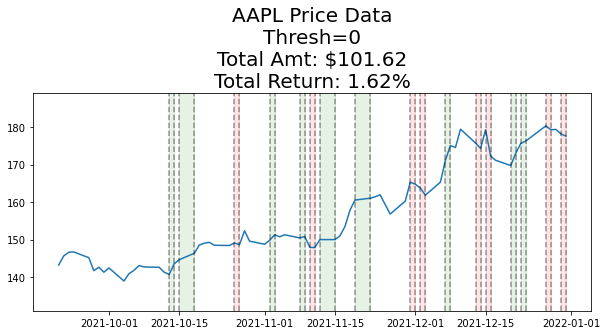

  0%|                                                    | 0/71 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.99450D+00    |proj g|=  1.52203D+02


 This problem is unconstrained.



At iterate    5    f= -3.00416D+00    |proj g|=  4.72378D+01
  ys=-2.079E-06  -gs= 6.725E-06 BFGS update SKIPPED
  ys=-1.183E-05  -gs= 1.759E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()

 Line search cannot locate an adequate point after MAXLS
  function an


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23      9     73      2     2     0   9.040D+01  -3.004D+00
  F =  -3.0041630842342699     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 18%|███████▊                                   | 13/71 [00:26<01:58,  2.03s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.10002D+00    |proj g|=  2.38329D+00

At iterate    5    f= -3.22055D+00    |proj g|=  1.12800D+00

At iterate   10    f= -3.22320D+00    |proj g|=  5.73628D-01

At iterate   15    f= -3.23902D+00    |proj g|=  7.61612D+00

At iterate   20    f= -3.25224D+00    |proj g|=  8.51329D-01

At iterate   25    f= -3.28619D+00    |proj g|=  1.81899D+01

At iterate   30    f= -3.31735D+00    |proj g|=  2.17883D+00

At iterate   35    f= -3.32792D+00    |proj g|=  2.78111D+01

At iterate   40    f= -3.34578D+00    |proj g|=  9.08759D-02

At iterate   45    f= -3.34586D+00    |proj g|=  2.05985D+00

At iterate   50    f= -3.34666D+00    |proj g|=  1.78545D+00

At iterate   55    f= -3.34768D+00    |proj g|=  7.82767D-01

At iterate   60    f= -3.35567D+00    |proj g|=  1.18052D+01

At iterate   65    f= -3.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   80    f= -3.35628D+00    |proj g|=  5.34255D-02

At iterate   85    f= -3.35635D+00    |proj g|=  6.95621D+00

At iterate   90    f= -3.35692D+00    |proj g|=  6.75462D-01

At iterate   95    f= -3.36065D+00    |proj g|=  2.28278D+00

At iterate  100    f= -3.36080D+00    |proj g|=  2.63427D-01

At iterate  105    f= -3.36434D+00    |proj g|=  9.48794D-02

At iterate  110    f= -3.36475D+00    |proj g|=  9.65442D-01

At iterate  115    f= -3.36687D+00    |proj g|=  3.03735D-01

At iterate  120    f= -3.36796D+00    |proj g|=  1.88768D-01

At iterate  125    f= -3.36976D+00    |proj g|=  4.48501D+00

At iterate  130    f= -3.37206D+00    |proj g|=  8.93429D-02

At iterate  135    f= -3.37226D+00    |proj g|=  4.25771D-01

At iterate  140    f= -3.37251D+00    |proj g|=  3.17446D-01

At iterate  145    f= -3.37416D+00    |proj g|=  6.36551D-01

At iterate  150    f= -3.37424D+00    |proj g|=  5.97120D-02

At iterate  155    f= -3.37425D+00    |proj g|=  6.60578D-01

At iter

 20%|████████▍                                  | 14/71 [01:43<08:57,  9.42s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.99155D+00    |proj g|=  6.91850D+00

At iterate    5    f= -2.99443D+00    |proj g|=  1.91091D+01

At iterate   10    f= -3.03990D+00    |proj g|=  7.54913D+00

At iterate   15    f= -3.04156D+00    |proj g|=  8.10853D+00

At iterate   20    f= -3.06928D+00    |proj g|=  9.75192D+00

At iterate   25    f= -3.07351D+00    |proj g|=  7.62351D+00

At iterate   30    f= -3.08166D+00    |proj g|=  2.84224D+00

At iterate   35    f= -3.08472D+00    |proj g|=  1.68601D+01

At iterate   40    f= -3.15194D+00    |proj g|=  4.92506D+01

At iterate   45    f= -3.18756D+00    |proj g|=  2.41345D-01

At iterate   50    f= -3.19439D+00    |proj g|=  5.87554D+00

At iterate   55    f= -3.25142D+00    |proj g|=  4.86505D+00

At iterate   60    f= -3.25170D+00    |proj g|=  6.94160D-01

At iterate   65    f= -3.2

 21%|█████████                                  | 15/71 [02:54<15:59, 17.14s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.07332D+00    |proj g|=  3.60939D+01

At iterate    5    f= -3.07794D+00    |proj g|=  1.48845D+01

At iterate   10    f= -3.15702D+00    |proj g|=  1.23917D+02

At iterate   15    f= -3.22817D+00    |proj g|=  1.78856D-01

At iterate   20    f= -3.22885D+00    |proj g|=  1.34908D+01

At iterate   25    f= -3.24169D+00    |proj g|=  8.74781D+00

At iterate   30    f= -3.24199D+00    |proj g|=  1.44607D+00

At iterate   35    f= -3.25716D+00    |proj g|=  1.12663D+01

At iterate   40    f= -3.27904D+00    |proj g|=  4.19894D-01

At iterate   45    f= -3.28031D+00    |proj g|=  5.41637D+00

At iterate   50    f= -3.31567D+00    |proj g|=  1.34517D+01

At iterate   55    f= -3.31934D+00    |proj g|=  2.11448D-01

At iterate   60    f= -3.35360D+00    |proj g|=  1.45504D-01

At iterate   65    f= -3.3

 23%|█████████▋                                 | 16/71 [04:04<23:00, 25.10s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.72026D+00    |proj g|=  1.95608D+05


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23      3     33      1     0     0   4.660D+05   5.718D+00
  F =   5.7184586153308157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 25%|██████████▉                                | 18/71 [04:21<17:41, 20.02s/it]/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:728: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds


 28%|████████████                               | 20/71 [04:23<12:07, 14.27s/it]


At iterate    0    f=          NaN    |proj g|=          NaN
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80198D+00    |proj g|=  7.86017D-01


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-3.104E+02  -gs= 3.187E+00 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23      3     52      3     1     0   1.226D+02  -1.118D+00
  F =  -1.1182227205378694     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 30%|████████████▋                              | 21/71 [04:44<12:55, 15.52s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds


 31%|█████████████▎                             | 22/71 [04:46<10:24, 12.74s/it]


At iterate    0    f=          NaN    |proj g|=          NaN


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57768D+00    |proj g|=  4.22571D+00

At iterate    5    f=  3.57768D+00    |proj g|=  2.10984D+00

At iterate   10    f=  3.57747D+00    |proj g|=  2.12831D+00

At iterate   15    f=  2.30136D+00    |proj g|=  4.63567D+01
  ys=-2.662E+01  -gs= 1.312E+00 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     17    113      2     1     0   4.053D+01   2.301D+00
  F =   2.3013581392986326     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 32%|█████████████▉                             | 23/71 [05:23<14:35, 18.23s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37916D+00    |proj g|=  1.75354D+00


 This problem is unconstrained.



At iterate    5    f= -2.92582D+00    |proj g|=  6.39208D+00

At iterate   10    f= -3.00363D+00    |proj g|=  7.10664D+01

At iterate   15    f= -3.04995D+00    |proj g|=  2.05818D+00

At iterate   20    f= -3.16169D+00    |proj g|=  2.56876D+01

At iterate   25    f= -3.17095D+00    |proj g|=  9.25622D+00

At iterate   30    f= -3.22576D+00    |proj g|=  7.42267D+00

At iterate   35    f= -3.29636D+00    |proj g|=  4.37819D+00

At iterate   40    f= -3.30349D+00    |proj g|=  8.13111D-01

At iterate   45    f= -3.30912D+00    |proj g|=  3.16577D+00

At iterate   50    f= -3.31152D+00    |proj g|=  9.66170D-01

At iterate   55    f= -3.31212D+00    |proj g|=  6.95141D-02

At iterate   60    f= -3.31223D+00    |proj g|=  7.95551D-02

At iterate   65    f= -3.31259D+00    |proj g|=  3.85199D-01

At iterate   70    f= -3.31368D+00    |proj g|=  2.65910D-01

At iterate   75    f= -3.31789D+00    |proj g|=  3.51130D-02

At iterate   80    f= -3.31793D+00    |proj g|=  2.50800D-02

At iter

 34%|██████████████▌                            | 24/71 [06:33<24:05, 30.76s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27666D+00    |proj g|=  7.29616D-01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23      1     21      1     0     0   7.296D-01   3.277D+00
  F =   3.2766607417073943     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 35%|███████████████▏                           | 25/71 [06:47<20:21, 26.56s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89471D-01    |proj g|=  7.83635D+00


 This problem is unconstrained.



At iterate    5    f= -2.99484D+00    |proj g|=  3.79267D+00

At iterate   10    f= -2.99934D+00    |proj g|=  2.89753D+00

At iterate   15    f= -3.02009D+00    |proj g|=  5.09296D+01

At iterate   20    f= -3.16238D+00    |proj g|=  3.71075D+00

At iterate   25    f= -3.21141D+00    |proj g|=  8.54339D+00

At iterate   30    f= -3.24067D+00    |proj g|=  7.88974D-01

At iterate   35    f= -3.24114D+00    |proj g|=  3.99994D+00

At iterate   40    f= -3.24881D+00    |proj g|=  5.59833D+00

At iterate   45    f= -3.24971D+00    |proj g|=  1.86423D-01

At iterate   50    f= -3.25424D+00    |proj g|=  2.67152D+00

At iterate   55    f= -3.25444D+00    |proj g|=  2.48367D-01

At iterate   60    f= -3.25476D+00    |proj g|=  5.20936D-01

At iterate   65    f= -3.26169D+00    |proj g|=  3.65642D+00

At iterate   70    f= -3.26603D+00    |proj g|=  2.56523D-01

At iterate   75    f= -3.26667D+00    |proj g|=  1.00531D+00

At iterate   80    f= -3.26811D+00    |proj g|=  2.81699D+00

At iter

 38%|████████████████▎                          | 27/71 [07:58<22:16, 30.37s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.02682D+00    |proj g|=  3.92331D+01


 This problem is unconstrained.



At iterate    5    f= -3.07698D+00    |proj g|=  1.98972D+00

At iterate   10    f= -3.09515D+00    |proj g|=  8.71496D+00
  ys=-1.243E-01  -gs= 4.150E-02 BFGS update SKIPPED

At iterate   15    f= -3.18350D+00    |proj g|=  3.22799D+00

At iterate   20    f= -3.18656D+00    |proj g|=  3.21285D+00

At iterate   25    f= -3.21600D+00    |proj g|=  4.99091D-01

At iterate   30    f= -3.22885D+00    |proj g|=  1.12288D+00

At iterate   35    f= -3.23068D+00    |proj g|=  9.22471D-01

At iterate   40    f= -3.24884D+00    |proj g|=  3.44456D-01

At iterate   45    f= -3.25163D+00    |proj g|=  2.28925D-01

At iterate   50    f= -3.26391D+00    |proj g|=  1.21493D+01

At iterate   55    f= -3.26964D+00    |proj g|=  6.84871D-02

At iterate   60    f= -3.27121D+00    |proj g|=  2.91304D-01

At iterate   65    f= -3.27649D+00    |proj g|=  6.09107D-01

At iterate   70    f= -3.27735D+00    |proj g|=  4.47428D-02

At iterate   75    f= -3.27905D+00    |proj g|=  9.55707D-01

At iterate   80  

 39%|████████████████▉                          | 28/71 [09:10<28:33, 39.86s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08552D+00    |proj g|=  4.19859D+01

At iterate    5    f= -3.11796D+00    |proj g|=  7.87834D+00

At iterate   10    f= -3.14198D+00    |proj g|=  7.05195D-01

At iterate   15    f= -3.15119D+00    |proj g|=  1.68111D+01

At iterate   20    f= -3.23767D+00    |proj g|=  1.81929D+01

At iterate   25    f= -3.24627D+00    |proj g|=  1.58295D+00

At iterate   30    f= -3.25851D+00    |proj g|=  1.81148D+00

At iterate   35    f= -3.26002D+00    |proj g|=  1.32918D+00

At iterate   40    f= -3.26644D+00    |proj g|=  1.49989D+00

At iterate   45    f= -3.26864D+00    |proj g|=  3.82023D-01

At iterate   50    f= -3.28556D+00    |proj g|=  3.44119D+00

At iterate   55    f= -3.28765D+00    |proj g|=  1.26332D-01

At iterate   60    f= -3.28818D+00    |proj g|=  1.30727D+00

At iterate   65    f= -3.2

 41%|█████████████████▌                         | 29/71 [10:16<32:34, 46.54s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.29071D+00    |proj g|=  1.48570D+02

At iterate    5    f= -2.55812D+00    |proj g|=  5.69345D+01

At iterate   10    f= -2.85541D+00    |proj g|=  1.66871D+01

At iterate   15    f= -2.87496D+00    |proj g|=  1.40219D+00

At iterate   20    f= -2.94627D+00    |proj g|=  9.27683D-01

At iterate   25    f= -3.00761D+00    |proj g|=  7.23121D+00

At iterate   30    f= -3.06721D+00    |proj g|=  9.13939D-01

At iterate   35    f= -3.07210D+00    |proj g|=  1.18299D+00

At iterate   40    f= -3.11533D+00    |proj g|=  4.06564D+01

At iterate   45    f= -3.17635D+00    |proj g|=  2.10156D-01

At iterate   50    f= -3.19646D+00    |proj g|=  4.78561D+01

At iterate   55    f= -3.21012D+00    |proj g|=  1.76194D+00

At iterate   60    f= -3.21105D+00    |proj g|=  1.43733D+00

At iterate   65    f= -3.2


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  115    f= -3.28029D+00    |proj g|=  1.77774D+00

At iterate  120    f= -3.28205D+00    |proj g|=  5.88164D-01

At iterate  125    f= -3.28381D+00    |proj g|=  1.65658D-01

At iterate  130    f= -3.28522D+00    |proj g|=  5.65604D+00

At iterate  135    f= -3.29090D+00    |proj g|=  1.43802D+00

At iterate  140    f= -3.29095D+00    |proj g|=  8.03036D-01

At iterate  145    f= -3.29154D+00    |proj g|=  7.19002D+00

At iterate  150    f= -3.30193D+00    |proj g|=  1.17867D+01

At iterate  155    f= -3.30312D+00    |proj g|=  3.42774D+00

At iterate  160    f= -3.30334D+00    |proj g|=  1.91253D+00

At iterate  165    f= -3.30533D+00    |proj g|=  1.29816D+00

At iterate  170    f= -3.30612D+00    |proj g|=  4.71444D+00

At iterate  175    f= -3.30686D+00    |proj g|=  1.37835D+00

At iterate  180    f= -3.31615D+00    |proj g|=  1.93467D+01

At iterate  185    f= -3.31862D+00    |proj g|=  9.18281D-02

At iterate  190    f= -3.32396D+00    |proj g|=  4.34463D+00

At iter

 42%|██████████████████▏                        | 30/71 [11:29<36:33, 53.50s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94502D+00    |proj g|=  1.49397D+01


 This problem is unconstrained.



At iterate    5    f= -2.94907D+00    |proj g|=  2.21549D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     10     71      2     0     0   6.066D+00  -2.949D+00
  F =  -2.9491347557694310     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 45%|███████████████████▍                       | 32/71 [11:55<23:26, 36.05s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.97245D+00    |proj g|=  3.92470D+01

At iterate    5    f= -3.01313D+00    |proj g|=  3.20869D+00

At iterate   10    f= -3.02941D+00    |proj g|=  5.88944D+00

At iterate   15    f= -3.03719D+00    |proj g|=  4.73820D+00

At iterate   20    f= -3.15088D+00    |proj g|=  4.00732D-01

At iterate   25    f= -3.17776D+00    |proj g|=  1.25124D+00

At iterate   30    f= -3.20628D+00    |proj g|=  8.21808D-01

At iterate   35    f= -3.23001D+00    |proj g|=  4.74198D-01

At iterate   40    f= -3.23833D+00    |proj g|=  6.07689D-01

At iterate   45    f= -3.24663D+00    |proj g|=  1.41447D-01

At iterate   50    f= -3.24678D+00    |proj g|=  1.09006D+00

At iterate   55    f= -3.24850D+00    |proj g|=  1.31303D+00

At iterate   60    f= -3.25820D+00    |proj g|=  3.82343D-01

At iterate   65    f= -3.2

 46%|███████████████████▉                       | 33/71 [13:14<29:10, 46.06s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.07106D+00    |proj g|=  2.09554D+01


 This problem is unconstrained.



At iterate    5    f= -3.08530D+00    |proj g|=  1.03965D+01

At iterate   10    f= -3.09792D+00    |proj g|=  8.24037D+00

At iterate   15    f= -3.10890D+00    |proj g|=  5.54187D-01

At iterate   20    f= -3.19341D+00    |proj g|=  9.73359D+00

At iterate   25    f= -3.21116D+00    |proj g|=  8.50410D+00

At iterate   30    f= -3.21427D+00    |proj g|=  2.39841D+00

At iterate   35    f= -3.24009D+00    |proj g|=  1.60920D-01

At iterate   40    f= -3.24216D+00    |proj g|=  1.47135D+00

At iterate   45    f= -3.25108D+00    |proj g|=  1.45331D+00

At iterate   50    f= -3.26278D+00    |proj g|=  6.76139D-01

At iterate   55    f= -3.27297D+00    |proj g|=  4.01817D+00

At iterate   60    f= -3.27500D+00    |proj g|=  5.40863D-02

At iterate   65    f= -3.27665D+00    |proj g|=  9.71052D-01

At iterate   70    f= -3.27816D+00    |proj g|=  2.83012D-02

At iterate   75    f= -3.27948D+00    |proj g|=  1.29754D+00

At iterate   80    f= -3.28340D+00    |proj g|=  1.02504D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  120    f= -3.28542D+00    |proj g|=  2.44853D-02

At iterate  125    f= -3.28545D+00    |proj g|=  9.89001D-02

At iterate  130    f= -3.28553D+00    |proj g|=  1.64112D-01

At iterate  135    f= -3.28556D+00    |proj g|=  1.35707D-01

At iterate  140    f= -3.28557D+00    |proj g|=  7.94240D-02

At iterate  145    f= -3.28563D+00    |proj g|=  5.00380D-01

At iterate  150    f= -3.28576D+00    |proj g|=  1.01593D-01

At iterate  155    f= -3.28579D+00    |proj g|=  1.39188D-01

At iterate  160    f= -3.28580D+00    |proj g|=  1.69019D-02

At iterate  165    f= -3.28584D+00    |proj g|=  9.62216D-02

At iterate  170    f= -3.28595D+00    |proj g|=  2.24767D-02

At iterate  175    f= -3.28595D+00    |proj g|=  3.35650D-02

At iterate  180    f= -3.28596D+00    |proj g|=  3.28937D-02

At iterate  185    f= -3.28597D+00    |proj g|=  2.16742D-02

At iterate  190    f= -3.28598D+00    |proj g|=  1.58224D-01

At iterate  195    f= -3.28599D+00    |proj g|=  4.62768D-03

At iter

 48%|████████████████████▌                      | 34/71 [14:36<34:01, 55.18s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.87426D+00    |proj g|=  7.95447D+01

At iterate    5    f= -2.93023D+00    |proj g|=  4.92796D+01

At iterate   10    f= -3.09702D+00    |proj g|=  2.16666D+00

At iterate   15    f= -3.15530D+00    |proj g|=  2.72389D-01

At iterate   20    f= -3.15583D+00    |proj g|=  4.91947D+00

At iterate   25    f= -3.16736D+00    |proj g|=  5.14612D+00

At iterate   30    f= -3.16817D+00    |proj g|=  1.34982D-01

At iterate   35    f= -3.19909D+00    |proj g|=  4.15679D+00

At iterate   40    f= -3.22283D+00    |proj g|=  1.27026D+00

At iterate   45    f= -3.23031D+00    |proj g|=  2.03347D-01

At iterate   50    f= -3.23693D+00    |proj g|=  1.50935D-01

At iterate   55    f= -3.24361D+00    |proj g|=  4.51536D+00

At iterate   60    f= -3.25038D+00    |proj g|=  5.05075D-01

At iterate   65    f= -3.2


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  155    f= -3.26335D+00    |proj g|=  4.96327D-02

At iterate  160    f= -3.26567D+00    |proj g|=  6.70413D-02

At iterate  165    f= -3.26707D+00    |proj g|=  5.99962D+00

At iterate  170    f= -3.27104D+00    |proj g|=  2.68294D-02

At iterate  175    f= -3.27107D+00    |proj g|=  2.11744D-01

At iterate  180    f= -3.27119D+00    |proj g|=  8.45475D-01

At iterate  185    f= -3.27147D+00    |proj g|=  6.71050D-02

At iterate  190    f= -3.27635D+00    |proj g|=  1.08711D+00

At iterate  195    f= -3.27723D+00    |proj g|=  2.02865D+00

At iterate  200    f= -3.27829D+00    |proj g|=  1.01568D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 51%|█████████████████████▊                     | 36/71 [15:51<27:50, 47.74s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.35440D+00    |proj g|=  2.56674D+00


 This problem is unconstrained.



At iterate    5    f= -2.84888D+00    |proj g|=  1.82163D+01

At iterate   10    f= -3.06888D+00    |proj g|=  1.68381D+00

At iterate   15    f= -3.13323D+00    |proj g|=  8.43992D-01

At iterate   20    f= -3.18343D+00    |proj g|=  1.56634D-01

At iterate   25    f= -3.18874D+00    |proj g|=  6.35342D-02

At iterate   30    f= -3.19421D+00    |proj g|=  7.38740D-02

At iterate   35    f= -3.19502D+00    |proj g|=  1.86802D-01

At iterate   40    f= -3.19564D+00    |proj g|=  2.02247D-01

At iterate   45    f= -3.19791D+00    |proj g|=  3.61353D-01

At iterate   50    f= -3.19948D+00    |proj g|=  4.48758D-02

At iterate   55    f= -3.19962D+00    |proj g|=  3.96802D-02

At iterate   60    f= -3.19980D+00    |proj g|=  2.03525D-01

At iterate   65    f= -3.19986D+00    |proj g|=  4.32730D-02

At iterate   70    f= -3.19992D+00    |proj g|=  4.69259D-02

At iterate   75    f= -3.20059D+00    |proj g|=  5.48962D-02

At iterate   80    f= -3.20091D+00    |proj g|=  3.80440D-01

At iter

 54%|███████████████████████                    | 38/71 [16:59<23:29, 42.71s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.86361D+00    |proj g|=  1.17130D+01

At iterate    5    f= -3.03873D+00    |proj g|=  3.50925D-01

At iterate   10    f= -3.08757D+00    |proj g|=  5.82716D-01

At iterate   15    f= -3.14118D+00    |proj g|=  2.82144D+00

At iterate   20    f= -3.15711D+00    |proj g|=  2.29536D-01

At iterate   25    f= -3.16265D+00    |proj g|=  2.21348D-02

At iterate   30    f= -3.16345D+00    |proj g|=  4.12068D-01

At iterate   35    f= -3.16706D+00    |proj g|=  1.73107D-01

At iterate   40    f= -3.16804D+00    |proj g|=  5.15481D-02

At iterate   45    f= -3.16821D+00    |proj g|=  4.37881D-01

At iterate   50    f= -3.16841D+00    |proj g|=  3.92323D-01

At iterate   55    f= -3.16912D+00    |proj g|=  1.26203D-01

At iterate   60    f= -3.16947D+00    |proj g|=  3.87538D-01

At iterate   65    f= -3.1

 56%|████████████████████████▏                  | 40/71 [18:18<21:26, 41.49s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.05683D+00    |proj g|=  5.54964D-01


 This problem is unconstrained.



At iterate    5    f= -3.09948D+00    |proj g|=  3.94967D-01

At iterate   10    f= -3.14441D+00    |proj g|=  8.71813D-01

At iterate   15    f= -3.16129D+00    |proj g|=  1.45802D-01

At iterate   20    f= -3.17243D+00    |proj g|=  3.66542D-02

At iterate   25    f= -3.17595D+00    |proj g|=  1.20237D+00

At iterate   30    f= -3.17679D+00    |proj g|=  4.88414D-02

At iterate   35    f= -3.17714D+00    |proj g|=  2.82144D-01

At iterate   40    f= -3.17999D+00    |proj g|=  1.28174D+00

At iterate   45    f= -3.18491D+00    |proj g|=  1.03558D-01

At iterate   50    f= -3.18790D+00    |proj g|=  1.69288D-01

At iterate   55    f= -3.18830D+00    |proj g|=  1.87958D-02

At iterate   60    f= -3.18884D+00    |proj g|=  4.86313D-02

At iterate   65    f= -3.18946D+00    |proj g|=  2.71001D-01

At iterate   70    f= -3.19022D+00    |proj g|=  2.53191D-02

At iterate   75    f= -3.19027D+00    |proj g|=  1.79036D-01

At iterate   80    f= -3.19037D+00    |proj g|=  9.47826D-02

At iter

 58%|████████████████████████▊                  | 41/71 [19:25<23:20, 46.69s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.75690D+00    |proj g|=  4.73585D+00

At iterate    5    f= -2.84846D+00    |proj g|=  8.20490D-01

At iterate   10    f= -2.92912D+00    |proj g|=  3.13588D+00

At iterate   15    f= -3.05614D+00    |proj g|=  2.24354D-01

At iterate   20    f= -3.06748D+00    |proj g|=  1.46983D-01

At iterate   25    f= -3.08609D+00    |proj g|=  1.24295D-01

At iterate   30    f= -3.09438D+00    |proj g|=  2.54243D+00

At iterate   35    f= -3.09936D+00    |proj g|=  7.10227D-01

At iterate   40    f= -3.10078D+00    |proj g|=  6.40284D-02

At iterate   45    f= -3.10607D+00    |proj g|=  1.00202D-01

At iterate   50    f= -3.11626D+00    |proj g|=  1.30715D-01

At iterate   55    f= -3.11741D+00    |proj g|=  1.54711D-02

At iterate   60    f= -3.11859D+00    |proj g|=  7.13478D-01

At iterate   65    f= -3.1

 59%|█████████████████████████▍                 | 42/71 [20:32<24:42, 51.12s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.53413D+00    |proj g|=  5.76467D+01

At iterate    5    f= -2.58188D+00    |proj g|=  1.42711D+01

At iterate   10    f= -2.65472D+00    |proj g|=  1.42619D+00

At iterate   15    f= -2.66892D+00    |proj g|=  5.14525D+00

At iterate   20    f= -2.83090D+00    |proj g|=  6.07179D-01

At iterate   25    f= -2.83228D+00    |proj g|=  6.07899D+00

At iterate   30    f= -2.89525D+00    |proj g|=  4.80762D+01

At iterate   35    f= -2.92251D+00    |proj g|=  2.31381D-01

At iterate   40    f= -2.98753D+00    |proj g|=  8.01061D+00

At iterate   45    f= -3.00152D+00    |proj g|=  1.29198D+00

At iterate   50    f= -3.01508D+00    |proj g|=  1.19922D+01

At iterate   55    f= -3.02337D+00    |proj g|=  4.66179D-01

At iterate   60    f= -3.02387D+00    |proj g|=  1.28542D+00

At iterate   65    f= -3.0

 61%|██████████████████████████                 | 43/71 [21:40<25:47, 55.27s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.66788D+00    |proj g|=  5.54122D+01

At iterate    5    f= -2.70554D+00    |proj g|=  1.97047D+01

At iterate   10    f= -2.74818D+00    |proj g|=  7.90033D-01

At iterate   15    f= -2.76072D+00    |proj g|=  5.41604D+00

At iterate   20    f= -2.86560D+00    |proj g|=  1.54861D+00

At iterate   25    f= -2.87204D+00    |proj g|=  1.42324D+01

At iterate   30    f= -2.91367D+00    |proj g|=  1.99234D+01

At iterate   35    f= -2.95559D+00    |proj g|=  4.90885D-01

At iterate   40    f= -3.02406D+00    |proj g|=  6.18033D-01

At iterate   45    f= -3.09532D+00    |proj g|=  2.43104D-01

At iterate   50    f= -3.09868D+00    |proj g|=  8.99636D-01

At iterate   55    f= -3.09952D+00    |proj g|=  1.21990D+00

At iterate   60    f= -3.10410D+00    |proj g|=  2.12751D-01

At iterate   65    f= -3.1

 62%|██████████████████████████▋                | 44/71 [22:52<26:45, 59.45s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.56278D+00    |proj g|=  9.19321D+01

At iterate    5    f= -2.64980D+00    |proj g|=  5.81879D+00

At iterate   10    f= -2.70098D+00    |proj g|=  4.07087D+01

At iterate   15    f= -2.71454D+00    |proj g|=  9.94583D+00

At iterate   20    f= -2.83534D+00    |proj g|=  1.90366D+01

At iterate   25    f= -2.84289D+00    |proj g|=  2.27104D-01

At iterate   30    f= -2.93111D+00    |proj g|=  1.49951D+01

At iterate   35    f= -2.96998D+00    |proj g|=  2.18409D+01

At iterate   40    f= -3.00159D+00    |proj g|=  2.07897D-01

At iterate   45    f= -3.00258D+00    |proj g|=  2.63370D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f= -3.03265D+00    |proj g|=  8.46226D-01

At iterate   55    f= -3.03320D+00    |proj g|=  4.86558D+00

At iterate   60    f= -3.04152D+00    |proj g|=  8.19375D-01

At iterate   65    f= -3.04624D+00    |proj g|=  1.14647D+01

At iterate   70    f= -3.05219D+00    |proj g|=  5.73563D-01

At iterate   75    f= -3.05689D+00    |proj g|=  1.99050D+00

At iterate   80    f= -3.05764D+00    |proj g|=  5.76448D-01

At iterate   85    f= -3.06754D+00    |proj g|=  1.27293D+00

At iterate   90    f= -3.08345D+00    |proj g|=  1.02038D-01

At iterate   95    f= -3.08373D+00    |proj g|=  1.26385D-01

At iterate  100    f= -3.08405D+00    |proj g|=  2.03015D+00

At iterate  105    f= -3.08561D+00    |proj g|=  4.56478D-02

At iterate  110    f= -3.08564D+00    |proj g|=  1.49317D-01

At iterate  115    f= -3.08571D+00    |proj g|=  3.19107D-01

At iterate  120    f= -3.08610D+00    |proj g|=  2.19813D-01

At iterate  125    f= -3.08627D+00    |proj g|=  5.49876D-02

At iter

 63%|███████████████████████████▎               | 45/71 [23:44<24:51, 57.37s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.70724D+00    |proj g|=  3.40461D+00

At iterate    5    f= -2.86053D+00    |proj g|=  2.95989D+00

At iterate   10    f= -3.08976D+00    |proj g|=  3.93508D+00

At iterate   15    f= -3.09996D+00    |proj g|=  6.65922D-02

At iterate   20    f= -3.11621D+00    |proj g|=  3.12493D+00

At iterate   25    f= -3.12355D+00    |proj g|=  4.72055D-01

At iterate   30    f= -3.13751D+00    |proj g|=  1.35364D-01

At iterate   35    f= -3.13840D+00    |proj g|=  3.21361D-01

At iterate   40    f= -3.13888D+00    |proj g|=  5.24794D-01

At iterate   45    f= -3.14611D+00    |proj g|=  2.46552D-01

At iterate   50    f= -3.14634D+00    |proj g|=  2.24264D-01

At iterate   55    f= -3.14653D+00    |proj g|=  6.96575D-02

At iterate   60    f= -3.14725D+00    |proj g|=  2.47065D-01

At iterate   65    f= -3.1

 65%|███████████████████████████▊               | 46/71 [24:51<25:00, 60.01s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.59159D+00    |proj g|=  2.45137D+02

At iterate    5    f= -2.90919D+00    |proj g|=  3.59085D+00

At iterate   10    f= -2.91559D+00    |proj g|=  4.88746D+01

At iterate   15    f= -2.94619D+00    |proj g|=  1.26983D+00

At iterate   20    f= -2.94810D+00    |proj g|=  4.03238D+00

At iterate   25    f= -2.97559D+00    |proj g|=  4.72239D+00

At iterate   30    f= -2.99206D+00    |proj g|=  2.10850D+01

At iterate   35    f= -3.05853D+00    |proj g|=  8.30362D+00

At iterate   40    f= -3.05920D+00    |proj g|=  3.26363D-01

At iterate   45    f= -3.06173D+00    |proj g|=  1.77715D+00

At iterate   50    f= -3.06178D+00    |proj g|=  1.91143D-01

At iterate   55    f= -3.06217D+00    |proj g|=  1.79641D+00

At iterate   60    f= -3.06942D+00    |proj g|=  5.30525D+00

At iterate   65    f= -3.0

 66%|████████████████████████████▍              | 47/71 [25:58<24:49, 62.06s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.14994D+00    |proj g|=  2.28661D+02

At iterate    5    f= -2.76699D+00    |proj g|=  3.74553D-01

At iterate   10    f= -2.76762D+00    |proj g|=  1.66798D+01

At iterate   15    f= -2.80280D+00    |proj g|=  8.04033D+01

At iterate   20    f= -2.82046D+00    |proj g|=  2.05892D-01

At iterate   25    f= -2.82186D+00    |proj g|=  1.17071D+01

At iterate   30    f= -2.88735D+00    |proj g|=  4.73477D+01

At iterate   35    f= -2.91301D+00    |proj g|=  7.91721D+00

At iterate   40    f= -3.02464D+00    |proj g|=  1.87437D+01

At iterate   45    f= -3.02981D+00    |proj g|=  1.44864D+00

At iterate   50    f= -3.03454D+00    |proj g|=  6.59409D+00

At iterate   55    f= -3.03645D+00    |proj g|=  2.30758D-01

At iterate   60    f= -3.03701D+00    |proj g|=  9.97834D-01

At iterate   65    f= -3.0


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   85    f= -3.04808D+00    |proj g|=  2.65692D+00

At iterate   90    f= -3.04978D+00    |proj g|=  1.71470D+00

At iterate   95    f= -3.04990D+00    |proj g|=  9.96356D-02

At iterate  100    f= -3.05016D+00    |proj g|=  1.68141D+00

At iterate  105    f= -3.05216D+00    |proj g|=  2.53754D+00

At iterate  110    f= -3.05335D+00    |proj g|=  3.47920D+00

At iterate  115    f= -3.05506D+00    |proj g|=  1.19440D-01

At iterate  120    f= -3.05594D+00    |proj g|=  3.47493D+00

At iterate  125    f= -3.05896D+00    |proj g|=  2.22603D-01

At iterate  130    f= -3.05918D+00    |proj g|=  1.24291D-01

At iterate  135    f= -3.05971D+00    |proj g|=  3.81896D-01

At iterate  140    f= -3.06151D+00    |proj g|=  3.01365D-01

At iterate  145    f= -3.06182D+00    |proj g|=  6.15784D-01

At iterate  150    f= -3.06490D+00    |proj g|=  9.37554D-02

At iterate  155    f= -3.06639D+00    |proj g|=  1.89606D+00

At iterate  160    f= -3.06928D+00    |proj g|=  3.78703D+00

At iter

 68%|█████████████████████████████              | 48/71 [27:15<25:27, 66.43s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.00300D+00    |proj g|=  1.34096D+00

At iterate    5    f= -3.00754D+00    |proj g|=  2.42710D+00

At iterate   10    f= -3.03065D+00    |proj g|=  2.55029D-01

At iterate   15    f= -3.03500D+00    |proj g|=  1.68962D+00

At iterate   20    f= -3.03922D+00    |proj g|=  1.88136D+00

At iterate   25    f= -3.05554D+00    |proj g|=  6.71440D-01

At iterate   30    f= -3.05685D+00    |proj g|=  3.94306D-01

At iterate   35    f= -3.06483D+00    |proj g|=  1.13394D+00

At iterate   40    f= -3.06613D+00    |proj g|=  5.06291D-01

At iterate   45    f= -3.07083D+00    |proj g|=  5.61452D-02

At iterate   50    f= -3.07206D+00    |proj g|=  7.08173D-01

At iterate   55    f= -3.07432D+00    |proj g|=  1.64930D-01

At iterate   60    f= -3.07461D+00    |proj g|=  3.93744D-01

At iterate   65    f= -3.0

 69%|█████████████████████████████▋             | 49/71 [28:24<24:39, 67.25s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94526D+00    |proj g|=  1.53371D+00

At iterate    5    f= -2.94926D+00    |proj g|=  2.39052D+00

At iterate   10    f= -2.97334D+00    |proj g|=  4.29952D-01

At iterate   15    f= -2.98609D+00    |proj g|=  7.72577D-01

At iterate   20    f= -2.99383D+00    |proj g|=  3.17256D+00

At iterate   25    f= -2.99978D+00    |proj g|=  6.06374D-01

At iterate   30    f= -3.00869D+00    |proj g|=  3.06367D+00

At iterate   35    f= -3.01477D+00    |proj g|=  4.24159D-01

At iterate   40    f= -3.01585D+00    |proj g|=  2.23645D-01

At iterate   45    f= -3.01862D+00    |proj g|=  9.29933D-01

At iterate   50    f= -3.02187D+00    |proj g|=  5.91097D-01

At iterate   55    f= -3.02737D+00    |proj g|=  2.57049D-01

At iterate   60    f= -3.02881D+00    |proj g|=  7.47876D-02

At iterate   65    f= -3.0

 72%|██████████████████████████████▉            | 51/71 [29:31<17:17, 51.85s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.13283D+00    |proj g|=  2.41391D+02

At iterate    5    f= -2.72568D+00    |proj g|=  5.29429D+00

At iterate   10    f= -2.73853D+00    |proj g|=  7.53711D+01

At iterate   15    f= -2.82342D+00    |proj g|=  7.05215D+00

At iterate   20    f= -2.82372D+00    |proj g|=  2.29195D+00

At iterate   25    f= -2.82877D+00    |proj g|=  3.19605D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -2.92879D+00    |proj g|=  5.86820D+01

At iterate   35    f= -2.93986D+00    |proj g|=  2.32608D+00

At iterate   40    f= -2.94373D+00    |proj g|=  3.18650D+01

At iterate   45    f= -2.96712D+00    |proj g|=  2.92391D-01

At iterate   50    f= -2.97475D+00    |proj g|=  2.69811D+00

At iterate   55    f= -2.99126D+00    |proj g|=  1.72821D-01

At iterate   60    f= -3.00242D+00    |proj g|=  1.72566D-01

At iterate   65    f= -3.00700D+00    |proj g|=  5.07848D+00

At iterate   70    f= -3.04656D+00    |proj g|=  7.53441D+00

At iterate   75    f= -3.04791D+00    |proj g|=  1.85021D-01

At iterate   80    f= -3.04796D+00    |proj g|=  3.65807D-01

At iterate   85    f= -3.05316D+00    |proj g|=  2.93967D+00

At iterate   90    f= -3.05972D+00    |proj g|=  1.30426D+00

At iterate   95    f= -3.06374D+00    |proj g|=  1.36427D+00

At iterate  100    f= -3.06554D+00    |proj g|=  9.98403D-01

At iterate  105    f= -3.06683D+00    |proj g|=  1.86434D-02

At iter

 75%|████████████████████████████████           | 53/71 [30:48<13:59, 46.63s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.66610D+00    |proj g|=  1.35745D+02

At iterate    5    f= -2.75063D+00    |proj g|=  3.73879D+01

At iterate   10    f= -2.83524D+00    |proj g|=  1.00707D+01

At iterate   15    f= -2.87760D+00    |proj g|=  1.80526D+01

At iterate   20    f= -2.89312D+00    |proj g|=  2.54217D+00

At iterate   25    f= -2.90594D+00    |proj g|=  1.95890D+01

At iterate   30    f= -2.93317D+00    |proj g|=  1.34854D+00

At iterate   35    f= -2.93487D+00    |proj g|=  2.23863D+00

At iterate   40    f= -2.94771D+00    |proj g|=  6.39696D+00

At iterate   45    f= -2.97494D+00    |proj g|=  6.70660D-02

At iterate   50    f= -2.97922D+00    |proj g|=  8.10464D+00

At iterate   55    f= -2.98836D+00    |proj g|=  8.17767D-02

At iterate   60    f= -2.98962D+00    |proj g|=  3.23904D+00

At iterate   65    f= -2.9

 76%|████████████████████████████████▋          | 54/71 [32:04<14:59, 52.93s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.49536D+00    |proj g|=  4.38658D+01

At iterate    5    f= -2.84778D+00    |proj g|=  8.61534D-01

At iterate   10    f= -2.86159D+00    |proj g|=  8.71210D+00

At iterate   15    f= -2.88360D+00    |proj g|=  7.51866D+00

At iterate   20    f= -2.89348D+00    |proj g|=  1.84019D+00

At iterate   25    f= -2.92342D+00    |proj g|=  2.34842D+00

At iterate   30    f= -2.93847D+00    |proj g|=  7.42737D-02

At iterate   35    f= -2.94595D+00    |proj g|=  1.02826D+00

At iterate   40    f= -2.95957D+00    |proj g|=  8.55005D-01

At iterate   45    f= -2.96174D+00    |proj g|=  4.74263D-01

At iterate   50    f= -2.96236D+00    |proj g|=  3.60162D-01

At iterate   55    f= -2.96966D+00    |proj g|=  4.22273D+00

At iterate   60    f= -2.98466D+00    |proj g|=  1.27357D+00

At iterate   65    f= -2.9

 79%|█████████████████████████████████▉         | 56/71 [33:12<11:24, 45.64s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.41838D+00    |proj g|=  1.15541D+02


 This problem is unconstrained.



At iterate    5    f= -2.62430D+00    |proj g|=  9.84429D+00

At iterate   10    f= -2.68103D+00    |proj g|=  9.68429D+01

At iterate   15    f= -2.73563D+00    |proj g|=  3.40972D-01

At iterate   20    f= -2.74181D+00    |proj g|=  1.81613D+01

At iterate   25    f= -2.80593D+00    |proj g|=  3.89689D+00

At iterate   30    f= -2.81246D+00    |proj g|=  6.97112D-01

At iterate   35    f= -2.86768D+00    |proj g|=  4.26766D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -2.92589D+00    |proj g|=  2.97956D-01

At iterate   45    f= -2.92599D+00    |proj g|=  2.70815D+00

At iterate   50    f= -2.93192D+00    |proj g|=  1.41221D+01

At iterate   55    f= -2.93501D+00    |proj g|=  2.38818D+00

At iterate   60    f= -2.93927D+00    |proj g|=  4.14553D+00

At iterate   65    f= -2.93957D+00    |proj g|=  4.90980D-01

At iterate   70    f= -2.94065D+00    |proj g|=  4.84653D+00

At iterate   75    f= -2.94332D+00    |proj g|=  6.76784D-02

At iterate   80    f= -2.94872D+00    |proj g|=  7.07745D-02

At iterate   85    f= -2.95390D+00    |proj g|=  2.23084D-01

At iterate   90    f= -2.95452D+00    |proj g|=  7.46757D-02

At iterate   95    f= -2.95484D+00    |proj g|=  1.89917D-01

At iterate  100    f= -2.95545D+00    |proj g|=  2.53388D-01

At iterate  105    f= -2.95570D+00    |proj g|=  9.73233D-01

At iterate  110    f= -2.95637D+00    |proj g|=  1.01190D+00

At iterate  115    f= -2.95833D+00    |proj g|=  1.28715D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  145    f= -2.95968D+00    |proj g|=  9.03099D-01

At iterate  150    f= -2.95987D+00    |proj g|=  5.50460D-02

At iterate  155    f= -2.95994D+00    |proj g|=  6.01819D-01

At iterate  160    f= -2.96010D+00    |proj g|=  1.29106D-01

At iterate  165    f= -2.96045D+00    |proj g|=  1.22567D+00

At iterate  170    f= -2.96128D+00    |proj g|=  1.57898D-01

At iterate  175    f= -2.96165D+00    |proj g|=  8.19145D-01

At iterate  180    f= -2.96181D+00    |proj g|=  1.03279D-01

At iterate  185    f= -2.96190D+00    |proj g|=  1.38007D-01

At iterate  190    f= -2.96227D+00    |proj g|=  3.00266D-01

At iterate  195    f= -2.96234D+00    |proj g|=  1.30948D-01

At iterate  200    f= -2.96257D+00    |proj g|=  1.62180D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 80%|██████████████████████████████████▌        | 57/71 [34:26<12:05, 51.85s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.21357D+00    |proj g|=  1.05947D+02


 This problem is unconstrained.



At iterate    5    f= -2.60265D+00    |proj g|=  4.52393D+01

At iterate   10    f= -2.71378D+00    |proj g|=  3.14910D+01

At iterate   15    f= -2.72033D+00    |proj g|=  2.02913D+00

At iterate   20    f= -2.73252D+00    |proj g|=  2.89358D+01

At iterate   25    f= -2.79904D+00    |proj g|=  2.50072D+01

At iterate   30    f= -2.80743D+00    |proj g|=  4.67521D-01

At iterate   35    f= -2.81006D+00    |proj g|=  1.47520D+01

At iterate   40    f= -2.86022D+00    |proj g|=  7.27853D+00

At iterate   45    f= -2.86191D+00    |proj g|=  1.44134D-01

At iterate   50    f= -2.87844D+00    |proj g|=  3.11555D-01

At iterate   55    f= -2.91573D+00    |proj g|=  2.40750D+00

At iterate   60    f= -2.91929D+00    |proj g|=  2.03226D+00

At iterate   65    f= -2.93471D+00    |proj g|=  1.40114D+00

At iterate   70    f= -2.93547D+00    |proj g|=  4.31346D-01

At iterate   75    f= -2.94391D+00    |proj g|=  3.76337D-01

At iterate   80    f= -2.94437D+00    |proj g|=  6.82199D-01

At iter

 82%|███████████████████████████████████▏       | 58/71 [35:36<12:10, 56.22s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14533D+00    |proj g|=  1.12381D+02

At iterate    5    f= -2.51667D+00    |proj g|=  4.63400D+00

At iterate   10    f= -2.53112D+00    |proj g|=  7.15150D+01

At iterate   15    f= -2.67135D+00    |proj g|=  2.69558D+01

At iterate   20    f= -2.67681D+00    |proj g|=  2.37331D+00

At iterate   25    f= -2.68181D+00    |proj g|=  3.32188D+01

At iterate   30    f= -2.73423D+00    |proj g|=  3.38189D+01

At iterate   35    f= -2.75482D+00    |proj g|=  5.96046D+00

At iterate   40    f= -2.76253D+00    |proj g|=  2.85952D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f= -2.83569D+00    |proj g|=  4.22224D-01

At iterate   50    f= -2.83602D+00    |proj g|=  6.36199D+00

At iterate   55    f= -2.86035D+00    |proj g|=  4.15585D+01

At iterate   60    f= -2.87381D+00    |proj g|=  6.59276D-01

At iterate   65    f= -2.88247D+00    |proj g|=  8.13460D+00

At iterate   70    f= -2.89250D+00    |proj g|=  2.35554D+00

At iterate   75    f= -2.91225D+00    |proj g|=  1.69092D-01

At iterate   80    f= -2.92190D+00    |proj g|=  5.60343D-01

At iterate   85    f= -2.92908D+00    |proj g|=  6.30475D-01

At iterate   90    f= -2.93068D+00    |proj g|=  3.78263D+00

At iterate   95    f= -2.93750D+00    |proj g|=  5.64709D-01

At iterate  100    f= -2.94135D+00    |proj g|=  1.46016D+00

At iterate  105    f= -2.94555D+00    |proj g|=  1.56758D-01

At iterate  110    f= -2.94559D+00    |proj g|=  1.65331D-01

At iterate  115    f= -2.94680D+00    |proj g|=  5.73286D-01

At iterate  120    f= -2.94717D+00    |proj g|=  6.61475D-02

At iter

 85%|████████████████████████████████████▎      | 60/71 [36:51<08:53, 48.54s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88600D+00    |proj g|=  3.05624D+00

At iterate    5    f= -2.90343D+00    |proj g|=  1.41840D-01

At iterate   10    f= -2.90441D+00    |proj g|=  1.23522D+00

At iterate   15    f= -2.90711D+00    |proj g|=  1.40047D-01

At iterate   20    f= -2.90887D+00    |proj g|=  1.14409D+00

At iterate   25    f= -2.91363D+00    |proj g|=  6.93633D-02

At iterate   30    f= -2.92116D+00    |proj g|=  4.05347D-02

At iterate   35    f= -2.92446D+00    |proj g|=  1.49810D-01

At iterate   40    f= -2.93132D+00    |proj g|=  2.62023D-01

At iterate   45    f= -2.93558D+00    |proj g|=  3.58945D-01

At iterate   50    f= -2.93939D+00    |proj g|=  1.45173D-01

At iterate   55    f= -2.94147D+00    |proj g|=  1.52463D-02

At iterate   60    f= -2.94164D+00    |proj g|=  2.47590D-01

At iterate   65    f= -2.9

 87%|█████████████████████████████████████▌     | 62/71 [38:06<06:41, 44.59s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88740D+00    |proj g|=  3.22705D+00

At iterate    5    f= -2.90922D+00    |proj g|=  1.02856D+00

At iterate   10    f= -2.91029D+00    |proj g|=  2.00213D-01

At iterate   15    f= -2.91306D+00    |proj g|=  1.89899D+00

At iterate   20    f= -2.91558D+00    |proj g|=  5.31821D-01

At iterate   25    f= -2.92252D+00    |proj g|=  2.84626D+00

At iterate   30    f= -2.92686D+00    |proj g|=  4.60467D-01

At iterate   35    f= -2.93258D+00    |proj g|=  3.59831D-02

At iterate   40    f= -2.93449D+00    |proj g|=  2.69915D-01

At iterate   45    f= -2.93769D+00    |proj g|=  3.66081D-01

At iterate   50    f= -2.94240D+00    |proj g|=  3.80934D-02

At iterate   55    f= -2.94393D+00    |proj g|=  2.99897D-02

At iterate   60    f= -2.94510D+00    |proj g|=  3.91198D-01

At iterate   65    f= -2.9

 89%|██████████████████████████████████████▏    | 63/71 [39:17<06:40, 50.09s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.92075D+00    |proj g|=  3.38094D+00


 This problem is unconstrained.



At iterate    5    f= -2.93746D+00    |proj g|=  4.58648D+00

At iterate   10    f= -2.94428D+00    |proj g|=  1.13756D-01

At iterate   15    f= -2.94536D+00    |proj g|=  1.42986D+00

At iterate   20    f= -2.94862D+00    |proj g|=  2.79726D-01

At iterate   25    f= -2.95102D+00    |proj g|=  7.31574D-01

At iterate   30    f= -2.95351D+00    |proj g|=  8.95123D-01

At iterate   35    f= -2.95453D+00    |proj g|=  1.32257D-01

At iterate   40    f= -2.95563D+00    |proj g|=  4.46539D-02

At iterate   45    f= -2.95589D+00    |proj g|=  3.48057D-01

At iterate   50    f= -2.95721D+00    |proj g|=  6.81148D-02

At iterate   55    f= -2.95811D+00    |proj g|=  3.55640D-01

At iterate   60    f= -2.95861D+00    |proj g|=  6.99691D-02

At iterate   65    f= -2.95884D+00    |proj g|=  4.90930D-02

At iterate   70    f= -2.95961D+00    |proj g|=  1.72235D-01

At iterate   75    f= -2.96048D+00    |proj g|=  1.25497D-01

At iterate   80    f= -2.96183D+00    |proj g|=  3.18876D-02

At iter

 92%|███████████████████████████████████████▎   | 65/71 [40:32<04:32, 45.41s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.90182D+00    |proj g|=  4.47257D+00

At iterate    5    f= -2.90705D+00    |proj g|=  3.37323D+00

At iterate   10    f= -2.92293D+00    |proj g|=  1.49196D+00

At iterate   15    f= -2.92739D+00    |proj g|=  1.75604D+00

At iterate   20    f= -2.92942D+00    |proj g|=  1.25241D+00

At iterate   25    f= -2.93150D+00    |proj g|=  5.82601D-02

At iterate   30    f= -2.93324D+00    |proj g|=  1.07186D+00

At iterate   35    f= -2.93706D+00    |proj g|=  1.76034D-01

At iterate   40    f= -2.93826D+00    |proj g|=  1.90430D-02

At iterate   45    f= -2.93950D+00    |proj g|=  1.15080D-01

At iterate   50    f= -2.94013D+00    |proj g|=  4.56950D-01

At iterate   55    f= -2.94186D+00    |proj g|=  2.05735D-01

At iterate   60    f= -2.94282D+00    |proj g|=  1.77837D-01

At iterate   65    f= -2.9

 94%|████████████████████████████████████████▌  | 67/71 [41:40<02:45, 41.36s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.91362D+00    |proj g|=  3.39795D+00


 This problem is unconstrained.



At iterate    5    f= -2.92705D+00    |proj g|=  3.68632D+00

At iterate   10    f= -2.93044D+00    |proj g|=  1.87994D+00

At iterate   15    f= -2.93712D+00    |proj g|=  1.02445D-01

At iterate   20    f= -2.93865D+00    |proj g|=  8.84797D-01

At iterate   25    f= -2.94034D+00    |proj g|=  6.99636D-02

At iterate   30    f= -2.94952D+00    |proj g|=  6.86757D-02

At iterate   35    f= -2.95173D+00    |proj g|=  1.75955D-01

At iterate   40    f= -2.95310D+00    |proj g|=  1.29539D-02

At iterate   45    f= -2.95536D+00    |proj g|=  2.03606D-02

At iterate   50    f= -2.95555D+00    |proj g|=  3.83514D-02

At iterate   55    f= -2.95581D+00    |proj g|=  1.22420D-02

At iterate   60    f= -2.95639D+00    |proj g|=  1.23177D-01

At iterate   65    f= -2.95675D+00    |proj g|=  1.11750D-01

At iterate   70    f= -2.95683D+00    |proj g|=  1.42374D-02

At iterate   75    f= -2.95702D+00    |proj g|=  3.29405D-02

At iterate   80    f= -2.95713D+00    |proj g|=  6.07402D-02

At iter

 97%|█████████████████████████████████████████▊ | 69/71 [42:48<01:17, 38.97s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.91910D+00    |proj g|=  3.72962D+00


 This problem is unconstrained.



At iterate    5    f= -2.92797D+00    |proj g|=  4.93872D+00

At iterate   10    f= -2.93914D+00    |proj g|=  2.19633D+00

At iterate   15    f= -2.94246D+00    |proj g|=  2.72362D-01

At iterate   20    f= -2.94440D+00    |proj g|=  3.88340D+00

At iterate   25    f= -2.94613D+00    |proj g|=  7.28075D-01

At iterate   30    f= -2.95302D+00    |proj g|=  2.12855D-01

At iterate   35    f= -2.95708D+00    |proj g|=  3.98215D-02

At iterate   40    f= -2.95841D+00    |proj g|=  9.47965D-02

At iterate   45    f= -2.95858D+00    |proj g|=  4.51962D-02

At iterate   50    f= -2.95898D+00    |proj g|=  2.50370D-01

At iterate   55    f= -2.95943D+00    |proj g|=  1.56684D-01

At iterate   60    f= -2.95960D+00    |proj g|=  1.92069D-01

At iterate   65    f= -2.96023D+00    |proj g|=  3.75678D-01

At iterate   70    f= -2.96062D+00    |proj g|=  8.04771D-02

At iterate   75    f= -2.96109D+00    |proj g|=  4.07030D-01

At iterate   80    f= -2.96120D+00    |proj g|=  2.09675D-01

At iter

100%|███████████████████████████████████████████| 71/71 [43:58<00:00, 37.16s/it]


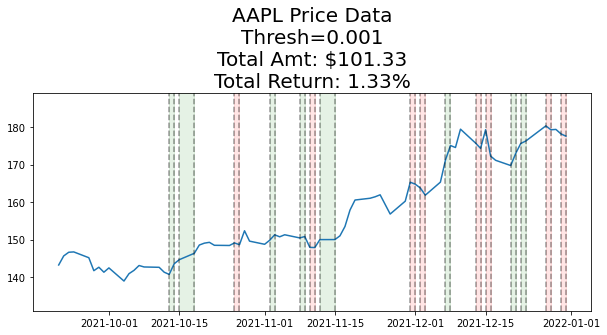

  0%|                                                    | 0/71 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.99450D+00    |proj g|=  1.52203D+02


 This problem is unconstrained.



At iterate    5    f= -3.00416D+00    |proj g|=  4.72378D+01
  ys=-2.079E-06  -gs= 6.725E-06 BFGS update SKIPPED
  ys=-1.183E-05  -gs= 1.759E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23      9     73      2     2     0   9.040D+01  -3.004D+00
  F =  -3.0041630842342699     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 18%|███████▊                                   | 13/71 [00:25<01:55,  2.00s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.10002D+00    |proj g|=  2.38329D+00

At iterate    5    f= -3.22055D+00    |proj g|=  1.12800D+00

At iterate   10    f= -3.22320D+00    |proj g|=  5.73628D-01

At iterate   15    f= -3.23902D+00    |proj g|=  7.61612D+00

At iterate   20    f= -3.25224D+00    |proj g|=  8.51329D-01

At iterate   25    f= -3.28619D+00    |proj g|=  1.81899D+01

At iterate   30    f= -3.31735D+00    |proj g|=  2.17883D+00

At iterate   35    f= -3.32792D+00    |proj g|=  2.78111D+01

At iterate   40    f= -3.34578D+00    |proj g|=  9.08759D-02

At iterate   45    f= -3.34586D+00    |proj g|=  2.05985D+00

At iterate   50    f= -3.34666D+00    |proj g|=  1.78545D+00

At iterate   55    f= -3.34768D+00    |proj g|=  7.82767D-01

At iterate   60    f= -3.35567D+00    |proj g|=  1.18052D+01

At iterate   65    f= -3.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   80    f= -3.35628D+00    |proj g|=  5.34255D-02

At iterate   85    f= -3.35635D+00    |proj g|=  6.95621D+00

At iterate   90    f= -3.35692D+00    |proj g|=  6.75462D-01

At iterate   95    f= -3.36065D+00    |proj g|=  2.28278D+00

At iterate  100    f= -3.36080D+00    |proj g|=  2.63427D-01

At iterate  105    f= -3.36434D+00    |proj g|=  9.48794D-02

At iterate  110    f= -3.36475D+00    |proj g|=  9.65442D-01

At iterate  115    f= -3.36687D+00    |proj g|=  3.03735D-01

At iterate  120    f= -3.36796D+00    |proj g|=  1.88768D-01

At iterate  125    f= -3.36976D+00    |proj g|=  4.48501D+00

At iterate  130    f= -3.37206D+00    |proj g|=  8.93429D-02

At iterate  135    f= -3.37226D+00    |proj g|=  4.25771D-01

At iterate  140    f= -3.37251D+00    |proj g|=  3.17446D-01

At iterate  145    f= -3.37416D+00    |proj g|=  6.36551D-01

At iterate  150    f= -3.37424D+00    |proj g|=  5.97120D-02

At iterate  155    f= -3.37425D+00    |proj g|=  6.60578D-01

At iter

 20%|████████▍                                  | 14/71 [01:29<07:39,  8.06s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.99155D+00    |proj g|=  6.91850D+00

At iterate    5    f= -2.99443D+00    |proj g|=  1.91091D+01

At iterate   10    f= -3.03990D+00    |proj g|=  7.54913D+00

At iterate   15    f= -3.04156D+00    |proj g|=  8.10853D+00

At iterate   20    f= -3.06928D+00    |proj g|=  9.75192D+00

At iterate   25    f= -3.07351D+00    |proj g|=  7.62351D+00

At iterate   30    f= -3.08166D+00    |proj g|=  2.84224D+00

At iterate   35    f= -3.08472D+00    |proj g|=  1.68601D+01

At iterate   40    f= -3.15194D+00    |proj g|=  4.92506D+01

At iterate   45    f= -3.18756D+00    |proj g|=  2.41345D-01

At iterate   50    f= -3.19439D+00    |proj g|=  5.87554D+00

At iterate   55    f= -3.25142D+00    |proj g|=  4.86505D+00

At iterate   60    f= -3.25170D+00    |proj g|=  6.94160D-01

At iterate   65    f= -3.2

 21%|█████████                                  | 15/71 [02:04<10:41, 11.46s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.07332D+00    |proj g|=  3.60939D+01

At iterate    5    f= -3.07794D+00    |proj g|=  1.48845D+01

At iterate   10    f= -3.15702D+00    |proj g|=  1.23917D+02

At iterate   15    f= -3.22817D+00    |proj g|=  1.78856D-01

At iterate   20    f= -3.22885D+00    |proj g|=  1.34908D+01

At iterate   25    f= -3.24169D+00    |proj g|=  8.74781D+00

At iterate   30    f= -3.24199D+00    |proj g|=  1.44607D+00

At iterate   35    f= -3.25716D+00    |proj g|=  1.12663D+01

At iterate   40    f= -3.27904D+00    |proj g|=  4.19894D-01

At iterate   45    f= -3.28031D+00    |proj g|=  5.41637D+00

At iterate   50    f= -3.31567D+00    |proj g|=  1.34517D+01

At iterate   55    f= -3.31934D+00    |proj g|=  2.11448D-01

At iterate   60    f= -3.35360D+00    |proj g|=  1.45504D-01

At iterate   65    f= -3.3

 23%|█████████▋                                 | 16/71 [02:45<14:34, 15.90s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.72026D+00    |proj g|=  1.95608D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23      3     33      1     0     0   4.660D+05   5.718D+00
  F =   5.7184586153308157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 25%|██████████▉                                | 18/71 [02:54<11:01, 12.48s/it]/Users/zhangjing/miniforge3/envs/env1/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:728: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
 This problem is unconstrained.
 28%|████████████                               | 20/71 [02:56<07:35,  8.94s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=          NaN    |proj g|=          NaN


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80198D+00    |proj g|=  7.86017D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-3.104E+02  -gs= 3.187E+00 BFGS update SKIPPED



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23      3     52      3     1     0   1.226D+02  -1.118D+00
  F =  -1.1182227205378694     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 31%|█████████████▎                             | 22/71 [03:08<06:18,  7.72s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=          NaN    |proj g|=          NaN


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57768D+00    |proj g|=  4.22571D+00

At iterate    5    f=  3.57768D+00    |proj g|=  2.10984D+00

At iterate   10    f=  3.57747D+00    |proj g|=  2.12831D+00

At iterate   15    f=  2.30136D+00    |proj g|=  4.63567D+01
  ys=-2.662E+01  -gs= 1.312E+00 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     17    113      2     1     0   4.053D+01   2.301D+00
  F =   2.3013581392986326     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 32%|█████████████▉                             | 23/71 [03:27<08:06, 10.13s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37916D+00    |proj g|=  1.75354D+00


 This problem is unconstrained.



At iterate    5    f= -2.92582D+00    |proj g|=  6.39208D+00

At iterate   10    f= -3.00363D+00    |proj g|=  7.10664D+01

At iterate   15    f= -3.04995D+00    |proj g|=  2.05818D+00

At iterate   20    f= -3.16169D+00    |proj g|=  2.56876D+01

At iterate   25    f= -3.17095D+00    |proj g|=  9.25622D+00

At iterate   30    f= -3.22576D+00    |proj g|=  7.42267D+00

At iterate   35    f= -3.29636D+00    |proj g|=  4.37819D+00

At iterate   40    f= -3.30349D+00    |proj g|=  8.13111D-01

At iterate   45    f= -3.30912D+00    |proj g|=  3.16577D+00

At iterate   50    f= -3.31152D+00    |proj g|=  9.66170D-01

At iterate   55    f= -3.31212D+00    |proj g|=  6.95141D-02

At iterate   60    f= -3.31223D+00    |proj g|=  7.95551D-02

At iterate   65    f= -3.31259D+00    |proj g|=  3.85199D-01

At iterate   70    f= -3.31368D+00    |proj g|=  2.65910D-01

At iterate   75    f= -3.31789D+00    |proj g|=  3.51130D-02

At iterate   80    f= -3.31793D+00    |proj g|=  2.50800D-02

At iter

 34%|██████████████▌                            | 24/71 [04:03<12:57, 16.53s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27666D+00    |proj g|=  7.29616D-01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23      1     21      1     0     0   7.296D-01   3.277D+00
  F =   3.2766607417073943     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 35%|███████████████▏                           | 25/71 [04:11<10:59, 14.33s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89471D-01    |proj g|=  7.83635D+00


 This problem is unconstrained.



At iterate    5    f= -2.99484D+00    |proj g|=  3.79267D+00

At iterate   10    f= -2.99934D+00    |proj g|=  2.89753D+00

At iterate   15    f= -3.02009D+00    |proj g|=  5.09296D+01

At iterate   20    f= -3.16238D+00    |proj g|=  3.71075D+00

At iterate   25    f= -3.21141D+00    |proj g|=  8.54339D+00

At iterate   30    f= -3.24067D+00    |proj g|=  7.88974D-01

At iterate   35    f= -3.24114D+00    |proj g|=  3.99994D+00

At iterate   40    f= -3.24881D+00    |proj g|=  5.59833D+00

At iterate   45    f= -3.24971D+00    |proj g|=  1.86423D-01

At iterate   50    f= -3.25424D+00    |proj g|=  2.67152D+00

At iterate   55    f= -3.25444D+00    |proj g|=  2.48367D-01

At iterate   60    f= -3.25476D+00    |proj g|=  5.20936D-01

At iterate   65    f= -3.26169D+00    |proj g|=  3.65642D+00

At iterate   70    f= -3.26603D+00    |proj g|=  2.56523D-01

At iterate   75    f= -3.26667D+00    |proj g|=  1.00531D+00

At iterate   80    f= -3.26811D+00    |proj g|=  2.81699D+00

At iter

 38%|████████████████▎                          | 27/71 [04:46<11:27, 15.62s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.02682D+00    |proj g|=  3.92331D+01

At iterate    5    f= -3.07698D+00    |proj g|=  1.98972D+00

At iterate   10    f= -3.09515D+00    |proj g|=  8.71496D+00
  ys=-1.243E-01  -gs= 4.150E-02 BFGS update SKIPPED

At iterate   15    f= -3.18350D+00    |proj g|=  3.22799D+00

At iterate   20    f= -3.18656D+00    |proj g|=  3.21285D+00

At iterate   25    f= -3.21600D+00    |proj g|=  4.99091D-01

At iterate   30    f= -3.22885D+00    |proj g|=  1.12288D+00

At iterate   35    f= -3.23068D+00    |proj g|=  9.22471D-01

At iterate   40    f= -3.24884D+00    |proj g|=  3.44456D-01

At iterate   45    f= -3.25163D+00    |proj g|=  2.28925D-01

At iterate   50    f= -3.26391D+00    |proj g|=  1.21493D+01

At iterate   55    f= -3.26964D+00    |proj g|=  6.84871D-02

At iterate   60    f= -3.27121D+00  

 39%|████████████████▉                          | 28/71 [05:23<14:42, 20.52s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08552D+00    |proj g|=  4.19859D+01

At iterate    5    f= -3.11796D+00    |proj g|=  7.87834D+00

At iterate   10    f= -3.14198D+00    |proj g|=  7.05195D-01

At iterate   15    f= -3.15119D+00    |proj g|=  1.68111D+01

At iterate   20    f= -3.23767D+00    |proj g|=  1.81929D+01

At iterate   25    f= -3.24627D+00    |proj g|=  1.58295D+00

At iterate   30    f= -3.25851D+00    |proj g|=  1.81148D+00

At iterate   35    f= -3.26002D+00    |proj g|=  1.32918D+00

At iterate   40    f= -3.26644D+00    |proj g|=  1.49989D+00

At iterate   45    f= -3.26864D+00    |proj g|=  3.82023D-01

At iterate   50    f= -3.28556D+00    |proj g|=  3.44119D+00

At iterate   55    f= -3.28765D+00    |proj g|=  1.26332D-01

At iterate   60    f= -3.28818D+00    |proj g|=  1.30727D+00

At iterate   65    f= -3.2

 41%|█████████████████▌                         | 29/71 [05:57<16:47, 23.98s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.29071D+00    |proj g|=  1.48570D+02

At iterate    5    f= -2.55812D+00    |proj g|=  5.69345D+01

At iterate   10    f= -2.85541D+00    |proj g|=  1.66871D+01

At iterate   15    f= -2.87496D+00    |proj g|=  1.40219D+00

At iterate   20    f= -2.94627D+00    |proj g|=  9.27683D-01

At iterate   25    f= -3.00761D+00    |proj g|=  7.23121D+00

At iterate   30    f= -3.06721D+00    |proj g|=  9.13939D-01

At iterate   35    f= -3.07210D+00    |proj g|=  1.18299D+00

At iterate   40    f= -3.11533D+00    |proj g|=  4.06564D+01

At iterate   45    f= -3.17635D+00    |proj g|=  2.10156D-01

At iterate   50    f= -3.19646D+00    |proj g|=  4.78561D+01

At iterate   55    f= -3.21012D+00    |proj g|=  1.76194D+00

At iterate   60    f= -3.21105D+00    |proj g|=  1.43733D+00

At iterate   65    f= -3.2


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  115    f= -3.28029D+00    |proj g|=  1.77774D+00

At iterate  120    f= -3.28205D+00    |proj g|=  5.88164D-01

At iterate  125    f= -3.28381D+00    |proj g|=  1.65658D-01

At iterate  130    f= -3.28522D+00    |proj g|=  5.65604D+00

At iterate  135    f= -3.29090D+00    |proj g|=  1.43802D+00

At iterate  140    f= -3.29095D+00    |proj g|=  8.03036D-01

At iterate  145    f= -3.29154D+00    |proj g|=  7.19002D+00

At iterate  150    f= -3.30193D+00    |proj g|=  1.17867D+01

At iterate  155    f= -3.30312D+00    |proj g|=  3.42774D+00

At iterate  160    f= -3.30334D+00    |proj g|=  1.91253D+00

At iterate  165    f= -3.30533D+00    |proj g|=  1.29816D+00

At iterate  170    f= -3.30612D+00    |proj g|=  4.71444D+00

At iterate  175    f= -3.30686D+00    |proj g|=  1.37835D+00

At iterate  180    f= -3.31615D+00    |proj g|=  1.93467D+01

At iterate  185    f= -3.31862D+00    |proj g|=  9.18281D-02

At iterate  190    f= -3.32396D+00    |proj g|=  4.34463D+00

At iter

 42%|██████████████████▏                        | 30/71 [06:34<18:41, 27.35s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.82206D+00    |proj g|=  1.39506D+02

At iterate    5    f= -2.02265D+00    |proj g|=  8.53946D-01

At iterate   10    f= -2.03814D+00    |proj g|=  1.14199D+02

At iterate   15    f= -2.48965D+00    |proj g|=  7.71801D+01

At iterate   20    f= -2.60407D+00    |proj g|=  4.94285D-01

At iterate   25    f= -2.80571D+00    |proj g|=  3.61253D+01
  ys=-4.117E-03  -gs= 2.666E-02 BFGS update SKIPPED

At iterate   30    f= -2.90083D+00    |proj g|=  4.25061D+00

At iterate   35    f= -2.91500D+00    |proj g|=  3.56447D-01

At iterate   40    f= -2.92646D+00    |proj g|=  7.16827D+01

At iterate   45    f= -3.03735D+00    |proj g|=  5.89383D+00

At iterate   50    f= -3.03876D+00    |proj g|=  3.61924D+00

At iterate   55    f= -3.04158D+00    |proj g|=  1.11990D+01

At iterate   60    f= -3.10692D+00  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  185    f= -3.25061D+00    |proj g|=  2.15461D-01

At iterate  190    f= -3.25105D+00    |proj g|=  3.39605D-01

At iterate  195    f= -3.25122D+00    |proj g|=  1.69250D+00

At iterate  200    f= -3.25423D+00    |proj g|=  2.85408D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23    200    310      2     2     0   2.854D+00  -3.254D+00
  F =  -3.2542319072469792     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 44%|██████████████████▊                        | 31/71 [07:17<21:07, 31.68s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.97245D+00    |proj g|=  3.92470D+01


 This problem is unconstrained.



At iterate    5    f= -3.01313D+00    |proj g|=  3.20869D+00

At iterate   10    f= -3.02941D+00    |proj g|=  5.88944D+00

At iterate   15    f= -3.03719D+00    |proj g|=  4.73820D+00

At iterate   20    f= -3.15088D+00    |proj g|=  4.00732D-01

At iterate   25    f= -3.17776D+00    |proj g|=  1.25124D+00

At iterate   30    f= -3.20628D+00    |proj g|=  8.21808D-01

At iterate   35    f= -3.23001D+00    |proj g|=  4.74198D-01

At iterate   40    f= -3.23833D+00    |proj g|=  6.07689D-01

At iterate   45    f= -3.24663D+00    |proj g|=  1.41447D-01

At iterate   50    f= -3.24678D+00    |proj g|=  1.09006D+00

At iterate   55    f= -3.24850D+00    |proj g|=  1.31303D+00

At iterate   60    f= -3.25820D+00    |proj g|=  3.82343D-01

At iterate   65    f= -3.25844D+00    |proj g|=  2.56527D-01

At iterate   70    f= -3.26191D+00    |proj g|=  1.17312D+00

At iterate   75    f= -3.26372D+00    |proj g|=  7.10852D-01

At iterate   80    f= -3.26472D+00    |proj g|=  8.17374D-01

At iter

 46%|███████████████████▉                       | 33/71 [07:57<16:48, 26.54s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.07106D+00    |proj g|=  2.09554D+01


 This problem is unconstrained.



At iterate    5    f= -3.08530D+00    |proj g|=  1.03965D+01

At iterate   10    f= -3.09792D+00    |proj g|=  8.24037D+00

At iterate   15    f= -3.10890D+00    |proj g|=  5.54187D-01

At iterate   20    f= -3.19341D+00    |proj g|=  9.73359D+00

At iterate   25    f= -3.21116D+00    |proj g|=  8.50410D+00

At iterate   30    f= -3.21427D+00    |proj g|=  2.39841D+00

At iterate   35    f= -3.24009D+00    |proj g|=  1.60920D-01

At iterate   40    f= -3.24216D+00    |proj g|=  1.47135D+00

At iterate   45    f= -3.25108D+00    |proj g|=  1.45331D+00

At iterate   50    f= -3.26278D+00    |proj g|=  6.76139D-01

At iterate   55    f= -3.27297D+00    |proj g|=  4.01817D+00

At iterate   60    f= -3.27500D+00    |proj g|=  5.40863D-02

At iterate   65    f= -3.27665D+00    |proj g|=  9.71052D-01

At iterate   70    f= -3.27816D+00    |proj g|=  2.83012D-02

At iterate   75    f= -3.27948D+00    |proj g|=  1.29754D+00

At iterate   80    f= -3.28340D+00    |proj g|=  1.02504D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  120    f= -3.28542D+00    |proj g|=  2.44853D-02

At iterate  125    f= -3.28545D+00    |proj g|=  9.89001D-02

At iterate  130    f= -3.28553D+00    |proj g|=  1.64112D-01

At iterate  135    f= -3.28556D+00    |proj g|=  1.35707D-01

At iterate  140    f= -3.28557D+00    |proj g|=  7.94240D-02

At iterate  145    f= -3.28563D+00    |proj g|=  5.00380D-01

At iterate  150    f= -3.28576D+00    |proj g|=  1.01593D-01

At iterate  155    f= -3.28579D+00    |proj g|=  1.39188D-01

At iterate  160    f= -3.28580D+00    |proj g|=  1.69019D-02

At iterate  165    f= -3.28584D+00    |proj g|=  9.62216D-02

At iterate  170    f= -3.28595D+00    |proj g|=  2.24767D-02

At iterate  175    f= -3.28595D+00    |proj g|=  3.35650D-02

At iterate  180    f= -3.28596D+00    |proj g|=  3.28937D-02

At iterate  185    f= -3.28597D+00    |proj g|=  2.16742D-02

At iterate  190    f= -3.28598D+00    |proj g|=  1.58224D-01

At iterate  195    f= -3.28599D+00    |proj g|=  4.62768D-03

At iter

 48%|████████████████████▌                      | 34/71 [08:39<18:36, 30.17s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08282D+00    |proj g|=  3.84583D+01

At iterate    5    f= -3.11279D+00    |proj g|=  6.73187D+00

At iterate   10    f= -3.12462D+00    |proj g|=  1.03236D+00

At iterate   15    f= -3.13131D+00    |proj g|=  1.18979D+01

At iterate   20    f= -3.14776D+00    |proj g|=  2.06820D-01

At iterate   25    f= -3.23043D+00    |proj g|=  6.13144D+00

At iterate   30    f= -3.24116D+00    |proj g|=  5.23454D+00

At iterate   35    f= -3.24903D+00    |proj g|=  5.28918D-01

At iterate   40    f= -3.25751D+00    |proj g|=  1.49822D+00

At iterate   45    f= -3.26583D+00    |proj g|=  2.21079D+00

At iterate   50    f= -3.26953D+00    |proj g|=  1.04390D-01

At iterate   55    f= -3.28692D+00    |proj g|=  1.70780D+00

At iterate   60    f= -3.28782D+00    |proj g|=  3.95689D-01

At iterate   65    f= -3.2


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  140    f= -3.29772D+00    |proj g|=  7.54254D-03

At iterate  145    f= -3.29775D+00    |proj g|=  2.50099D-01

At iterate  150    f= -3.29776D+00    |proj g|=  2.01629D-02

At iterate  155    f= -3.29786D+00    |proj g|=  1.25727D-01

At iterate  160    f= -3.29789D+00    |proj g|=  3.13127D-01

At iterate  165    f= -3.29797D+00    |proj g|=  2.39816D-01

At iterate  170    f= -3.29809D+00    |proj g|=  2.18520D-01

At iterate  175    f= -3.29812D+00    |proj g|=  2.23287D-01

At iterate  180    f= -3.29835D+00    |proj g|=  2.57871D-01

At iterate  185    f= -3.29838D+00    |proj g|=  2.49456D-02

At iterate  190    f= -3.29839D+00    |proj g|=  1.45870D-02

At iterate  195    f= -3.29840D+00    |proj g|=  2.34219D-02

At iterate  200    f= -3.29840D+00    |proj g|=  9.96430D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 49%|█████████████████████▏                     | 35/71 [09:23<20:10, 33.63s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.87426D+00    |proj g|=  7.95447D+01

At iterate    5    f= -2.93023D+00    |proj g|=  4.92796D+01

At iterate   10    f= -3.09702D+00    |proj g|=  2.16666D+00

At iterate   15    f= -3.15530D+00    |proj g|=  2.72389D-01

At iterate   20    f= -3.15583D+00    |proj g|=  4.91947D+00

At iterate   25    f= -3.16736D+00    |proj g|=  5.14612D+00

At iterate   30    f= -3.16817D+00    |proj g|=  1.34982D-01

At iterate   35    f= -3.19909D+00    |proj g|=  4.15679D+00

At iterate   40    f= -3.22283D+00    |proj g|=  1.27026D+00

At iterate   45    f= -3.23031D+00    |proj g|=  2.03347D-01

At iterate   50    f= -3.23693D+00    |proj g|=  1.50935D-01

At iterate   55    f= -3.24361D+00    |proj g|=  4.51536D+00

At iterate   60    f= -3.25038D+00    |proj g|=  5.05075D-01

At iterate   65    f= -3.2


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  155    f= -3.26335D+00    |proj g|=  4.96327D-02

At iterate  160    f= -3.26567D+00    |proj g|=  6.70413D-02

At iterate  165    f= -3.26707D+00    |proj g|=  5.99962D+00

At iterate  170    f= -3.27104D+00    |proj g|=  2.68294D-02

At iterate  175    f= -3.27107D+00    |proj g|=  2.11744D-01

At iterate  180    f= -3.27119D+00    |proj g|=  8.45475D-01

At iterate  185    f= -3.27147D+00    |proj g|=  6.71050D-02

At iterate  190    f= -3.27635D+00    |proj g|=  1.08711D+00

At iterate  195    f= -3.27723D+00    |proj g|=  2.02865D+00

At iterate  200    f= -3.27829D+00    |proj g|=  1.01568D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 51%|█████████████████████▊                     | 36/71 [10:01<20:25, 35.02s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.35440D+00    |proj g|=  2.56674D+00

At iterate    5    f= -2.84888D+00    |proj g|=  1.82163D+01

At iterate   10    f= -3.06888D+00    |proj g|=  1.68381D+00

At iterate   15    f= -3.13323D+00    |proj g|=  8.43992D-01

At iterate   20    f= -3.18343D+00    |proj g|=  1.56634D-01

At iterate   25    f= -3.18874D+00    |proj g|=  6.35342D-02

At iterate   30    f= -3.19421D+00    |proj g|=  7.38740D-02

At iterate   35    f= -3.19502D+00    |proj g|=  1.86802D-01

At iterate   40    f= -3.19564D+00    |proj g|=  2.02247D-01

At iterate   45    f= -3.19791D+00    |proj g|=  3.61353D-01

At iterate   50    f= -3.19948D+00    |proj g|=  4.48758D-02

At iterate   55    f= -3.19962D+00    |proj g|=  3.96802D-02

At iterate   60    f= -3.19980D+00    |proj g|=  2.03525D-01

At iterate   65    f= -3.1

 54%|███████████████████████                    | 38/71 [10:35<14:58, 27.22s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42590D+00    |proj g|=  4.31747D+00

At iterate    5    f= -3.03495D+00    |proj g|=  4.40647D+00

At iterate   10    f= -3.07859D+00    |proj g|=  1.78513D-01

At iterate   15    f= -3.12277D+00    |proj g|=  6.66581D-01

At iterate   20    f= -3.13789D+00    |proj g|=  7.93115D-01

At iterate   25    f= -3.16648D+00    |proj g|=  1.17764D-01

At iterate   30    f= -3.17301D+00    |proj g|=  6.26680D-02

At iterate   35    f= -3.17940D+00    |proj g|=  7.44351D-01

At iterate   40    f= -3.18970D+00    |proj g|=  4.37695D+00

At iterate   45    f= -3.20072D+00    |proj g|=  7.82630D-01

At iterate   50    f= -3.20394D+00    |proj g|=  3.57741D-01

At iterate   55    f= -3.20603D+00    |proj g|=  1.87516D-01

At iterate   60    f= -3.20613D+00    |proj g|=  2.34945D-01

At iterate   65    f= -3.2

 55%|███████████████████████▌                   | 39/71 [11:10<15:30, 29.07s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.05683D+00    |proj g|=  5.54964D-01

At iterate    5    f= -3.09948D+00    |proj g|=  3.94967D-01

At iterate   10    f= -3.14441D+00    |proj g|=  8.71813D-01

At iterate   15    f= -3.16129D+00    |proj g|=  1.45802D-01

At iterate   20    f= -3.17243D+00    |proj g|=  3.66542D-02

At iterate   25    f= -3.17595D+00    |proj g|=  1.20237D+00

At iterate   30    f= -3.17679D+00    |proj g|=  4.88414D-02

At iterate   35    f= -3.17714D+00    |proj g|=  2.82144D-01

At iterate   40    f= -3.17999D+00    |proj g|=  1.28174D+00

At iterate   45    f= -3.18491D+00    |proj g|=  1.03558D-01

At iterate   50    f= -3.18790D+00    |proj g|=  1.69288D-01

At iterate   55    f= -3.18830D+00    |proj g|=  1.87958D-02

At iterate   60    f= -3.18884D+00    |proj g|=  4.86313D-02

At iterate   65    f= -3.1

 58%|████████████████████████▊                  | 41/71 [11:46<12:13, 24.45s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.75690D+00    |proj g|=  4.73585D+00

At iterate    5    f= -2.84846D+00    |proj g|=  8.20490D-01

At iterate   10    f= -2.92912D+00    |proj g|=  3.13588D+00

At iterate   15    f= -3.05614D+00    |proj g|=  2.24354D-01

At iterate   20    f= -3.06748D+00    |proj g|=  1.46983D-01

At iterate   25    f= -3.08609D+00    |proj g|=  1.24295D-01

At iterate   30    f= -3.09438D+00    |proj g|=  2.54243D+00

At iterate   35    f= -3.09936D+00    |proj g|=  7.10227D-01

At iterate   40    f= -3.10078D+00    |proj g|=  6.40284D-02

At iterate   45    f= -3.10607D+00    |proj g|=  1.00202D-01

At iterate   50    f= -3.11626D+00    |proj g|=  1.30715D-01

At iterate   55    f= -3.11741D+00    |proj g|=  1.54711D-02

At iterate   60    f= -3.11859D+00    |proj g|=  7.13478D-01

At iterate   65    f= -3.1

 59%|█████████████████████████▍                 | 42/71 [12:20<12:53, 26.68s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.53413D+00    |proj g|=  5.76467D+01

At iterate    5    f= -2.58188D+00    |proj g|=  1.42711D+01

At iterate   10    f= -2.65472D+00    |proj g|=  1.42619D+00

At iterate   15    f= -2.66892D+00    |proj g|=  5.14525D+00

At iterate   20    f= -2.83090D+00    |proj g|=  6.07179D-01

At iterate   25    f= -2.83228D+00    |proj g|=  6.07899D+00

At iterate   30    f= -2.89525D+00    |proj g|=  4.80762D+01

At iterate   35    f= -2.92251D+00    |proj g|=  2.31381D-01

At iterate   40    f= -2.98753D+00    |proj g|=  8.01061D+00

At iterate   45    f= -3.00152D+00    |proj g|=  1.29198D+00

At iterate   50    f= -3.01508D+00    |proj g|=  1.19922D+01

At iterate   55    f= -3.02337D+00    |proj g|=  4.66179D-01

At iterate   60    f= -3.02387D+00    |proj g|=  1.28542D+00

At iterate   65    f= -3.0

 61%|██████████████████████████                 | 43/71 [12:56<13:28, 28.87s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.66788D+00    |proj g|=  5.54122D+01

At iterate    5    f= -2.70554D+00    |proj g|=  1.97047D+01

At iterate   10    f= -2.74818D+00    |proj g|=  7.90033D-01

At iterate   15    f= -2.76072D+00    |proj g|=  5.41604D+00

At iterate   20    f= -2.86560D+00    |proj g|=  1.54861D+00

At iterate   25    f= -2.87204D+00    |proj g|=  1.42324D+01

At iterate   30    f= -2.91367D+00    |proj g|=  1.99234D+01

At iterate   35    f= -2.95559D+00    |proj g|=  4.90885D-01

At iterate   40    f= -3.02406D+00    |proj g|=  6.18033D-01

At iterate   45    f= -3.09532D+00    |proj g|=  2.43104D-01

At iterate   50    f= -3.09868D+00    |proj g|=  8.99636D-01

At iterate   55    f= -3.09952D+00    |proj g|=  1.21990D+00

At iterate   60    f= -3.10410D+00    |proj g|=  2.12751D-01

At iterate   65    f= -3.1

 62%|██████████████████████████▋                | 44/71 [13:37<14:26, 32.08s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.56278D+00    |proj g|=  9.19321D+01


 This problem is unconstrained.



At iterate    5    f= -2.64980D+00    |proj g|=  5.81879D+00

At iterate   10    f= -2.70098D+00    |proj g|=  4.07087D+01

At iterate   15    f= -2.71454D+00    |proj g|=  9.94583D+00

At iterate   20    f= -2.83534D+00    |proj g|=  1.90366D+01

At iterate   25    f= -2.84289D+00    |proj g|=  2.27104D-01

At iterate   30    f= -2.93111D+00    |proj g|=  1.49951D+01

At iterate   35    f= -2.96998D+00    |proj g|=  2.18409D+01

At iterate   40    f= -3.00159D+00    |proj g|=  2.07897D-01

At iterate   45    f= -3.00258D+00    |proj g|=  2.63370D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f= -3.03265D+00    |proj g|=  8.46226D-01

At iterate   55    f= -3.03320D+00    |proj g|=  4.86558D+00

At iterate   60    f= -3.04152D+00    |proj g|=  8.19375D-01

At iterate   65    f= -3.04624D+00    |proj g|=  1.14647D+01

At iterate   70    f= -3.05219D+00    |proj g|=  5.73563D-01

At iterate   75    f= -3.05689D+00    |proj g|=  1.99050D+00

At iterate   80    f= -3.05764D+00    |proj g|=  5.76448D-01

At iterate   85    f= -3.06754D+00    |proj g|=  1.27293D+00

At iterate   90    f= -3.08345D+00    |proj g|=  1.02038D-01

At iterate   95    f= -3.08373D+00    |proj g|=  1.26385D-01

At iterate  100    f= -3.08405D+00    |proj g|=  2.03015D+00

At iterate  105    f= -3.08561D+00    |proj g|=  4.56478D-02

At iterate  110    f= -3.08564D+00    |proj g|=  1.49317D-01

At iterate  115    f= -3.08571D+00    |proj g|=  3.19107D-01

At iterate  120    f= -3.08610D+00    |proj g|=  2.19813D-01

At iterate  125    f= -3.08627D+00    |proj g|=  5.49876D-02

At iter

 63%|███████████████████████████▎               | 45/71 [14:04<13:18, 30.73s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.70724D+00    |proj g|=  3.40461D+00


 This problem is unconstrained.



At iterate    5    f= -2.86053D+00    |proj g|=  2.95989D+00

At iterate   10    f= -3.08976D+00    |proj g|=  3.93508D+00

At iterate   15    f= -3.09996D+00    |proj g|=  6.65922D-02

At iterate   20    f= -3.11621D+00    |proj g|=  3.12493D+00

At iterate   25    f= -3.12355D+00    |proj g|=  4.72055D-01

At iterate   30    f= -3.13751D+00    |proj g|=  1.35364D-01

At iterate   35    f= -3.13840D+00    |proj g|=  3.21361D-01

At iterate   40    f= -3.13888D+00    |proj g|=  5.24794D-01

At iterate   45    f= -3.14611D+00    |proj g|=  2.46552D-01

At iterate   50    f= -3.14634D+00    |proj g|=  2.24264D-01

At iterate   55    f= -3.14653D+00    |proj g|=  6.96575D-02

At iterate   60    f= -3.14725D+00    |proj g|=  2.47065D-01

At iterate   65    f= -3.14737D+00    |proj g|=  3.33698D-02

At iterate   70    f= -3.14889D+00    |proj g|=  8.62197D-02

At iterate   75    f= -3.14943D+00    |proj g|=  6.52521D-02

At iterate   80    f= -3.14947D+00    |proj g|=  3.84022D-02

At iter

 65%|███████████████████████████▊               | 46/71 [14:59<15:37, 37.49s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.59159D+00    |proj g|=  2.45137D+02


 This problem is unconstrained.



At iterate    5    f= -2.90919D+00    |proj g|=  3.59085D+00

At iterate   10    f= -2.91559D+00    |proj g|=  4.88746D+01

At iterate   15    f= -2.94619D+00    |proj g|=  1.26983D+00

At iterate   20    f= -2.94810D+00    |proj g|=  4.03238D+00

At iterate   25    f= -2.97559D+00    |proj g|=  4.72239D+00

At iterate   30    f= -2.99206D+00    |proj g|=  2.10850D+01

At iterate   35    f= -3.05853D+00    |proj g|=  8.30362D+00

At iterate   40    f= -3.05920D+00    |proj g|=  3.26363D-01

At iterate   45    f= -3.06173D+00    |proj g|=  1.77715D+00

At iterate   50    f= -3.06178D+00    |proj g|=  1.91143D-01

At iterate   55    f= -3.06217D+00    |proj g|=  1.79641D+00

At iterate   60    f= -3.06942D+00    |proj g|=  5.30525D+00

At iterate   65    f= -3.07143D+00    |proj g|=  3.45831D-01

At iterate   70    f= -3.07178D+00    |proj g|=  2.53462D+00

At iterate   75    f= -3.07801D+00    |proj g|=  2.41711D+00

At iterate   80    f= -3.07862D+00    |proj g|=  6.36123D-02

At iter

 66%|████████████████████████████▍              | 47/71 [15:34<14:40, 36.67s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.14994D+00    |proj g|=  2.28661D+02


 This problem is unconstrained.



At iterate    5    f= -2.76699D+00    |proj g|=  3.74553D-01

At iterate   10    f= -2.76762D+00    |proj g|=  1.66798D+01

At iterate   15    f= -2.80280D+00    |proj g|=  8.04033D+01

At iterate   20    f= -2.82046D+00    |proj g|=  2.05892D-01

At iterate   25    f= -2.82186D+00    |proj g|=  1.17071D+01

At iterate   30    f= -2.88735D+00    |proj g|=  4.73477D+01

At iterate   35    f= -2.91301D+00    |proj g|=  7.91721D+00

At iterate   40    f= -3.02464D+00    |proj g|=  1.87437D+01

At iterate   45    f= -3.02981D+00    |proj g|=  1.44864D+00

At iterate   50    f= -3.03454D+00    |proj g|=  6.59409D+00

At iterate   55    f= -3.03645D+00    |proj g|=  2.30758D-01

At iterate   60    f= -3.03701D+00    |proj g|=  9.97834D-01

At iterate   65    f= -3.03960D+00    |proj g|=  1.39996D+00

At iterate   70    f= -3.04017D+00    |proj g|=  2.51690D-01

At iterate   75    f= -3.04041D+00    |proj g|=  2.17754D+00

At iterate   80    f= -3.04793D+00    |proj g|=  2.59174D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   85    f= -3.04808D+00    |proj g|=  2.65692D+00

At iterate   90    f= -3.04978D+00    |proj g|=  1.71470D+00

At iterate   95    f= -3.04990D+00    |proj g|=  9.96356D-02

At iterate  100    f= -3.05016D+00    |proj g|=  1.68141D+00

At iterate  105    f= -3.05216D+00    |proj g|=  2.53754D+00

At iterate  110    f= -3.05335D+00    |proj g|=  3.47920D+00

At iterate  115    f= -3.05506D+00    |proj g|=  1.19440D-01

At iterate  120    f= -3.05594D+00    |proj g|=  3.47493D+00

At iterate  125    f= -3.05896D+00    |proj g|=  2.22603D-01

At iterate  130    f= -3.05918D+00    |proj g|=  1.24291D-01

At iterate  135    f= -3.05971D+00    |proj g|=  3.81896D-01

At iterate  140    f= -3.06151D+00    |proj g|=  3.01365D-01

At iterate  145    f= -3.06182D+00    |proj g|=  6.15784D-01

At iterate  150    f= -3.06490D+00    |proj g|=  9.37554D-02

At iterate  155    f= -3.06639D+00    |proj g|=  1.89606D+00

At iterate  160    f= -3.06928D+00    |proj g|=  3.78703D+00

At iter

 68%|█████████████████████████████              | 48/71 [16:10<13:59, 36.51s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.00300D+00    |proj g|=  1.34096D+00

At iterate    5    f= -3.00754D+00    |proj g|=  2.42710D+00

At iterate   10    f= -3.03065D+00    |proj g|=  2.55029D-01

At iterate   15    f= -3.03500D+00    |proj g|=  1.68962D+00

At iterate   20    f= -3.03922D+00    |proj g|=  1.88136D+00

At iterate   25    f= -3.05554D+00    |proj g|=  6.71440D-01

At iterate   30    f= -3.05685D+00    |proj g|=  3.94306D-01

At iterate   35    f= -3.06483D+00    |proj g|=  1.13394D+00

At iterate   40    f= -3.06613D+00    |proj g|=  5.06291D-01

At iterate   45    f= -3.07083D+00    |proj g|=  5.61452D-02

At iterate   50    f= -3.07206D+00    |proj g|=  7.08173D-01

At iterate   55    f= -3.07432D+00    |proj g|=  1.64930D-01

At iterate   60    f= -3.07461D+00    |proj g|=  3.93744D-01

At iterate   65    f= -3.0

 69%|█████████████████████████████▋             | 49/71 [16:49<13:41, 37.33s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94526D+00    |proj g|=  1.53371D+00

At iterate    5    f= -2.94926D+00    |proj g|=  2.39052D+00

At iterate   10    f= -2.97334D+00    |proj g|=  4.29952D-01

At iterate   15    f= -2.98609D+00    |proj g|=  7.72577D-01

At iterate   20    f= -2.99383D+00    |proj g|=  3.17256D+00

At iterate   25    f= -2.99978D+00    |proj g|=  6.06374D-01

At iterate   30    f= -3.00869D+00    |proj g|=  3.06367D+00

At iterate   35    f= -3.01477D+00    |proj g|=  4.24159D-01

At iterate   40    f= -3.01585D+00    |proj g|=  2.23645D-01

At iterate   45    f= -3.01862D+00    |proj g|=  9.29933D-01

At iterate   50    f= -3.02187D+00    |proj g|=  5.91097D-01

At iterate   55    f= -3.02737D+00    |proj g|=  2.57049D-01

At iterate   60    f= -3.02881D+00    |proj g|=  7.47876D-02

At iterate   65    f= -3.0

 72%|██████████████████████████████▉            | 51/71 [17:24<09:25, 28.27s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.05564D+00    |proj g|=  2.52445D+02


 This problem is unconstrained.



At iterate    5    f= -2.72683D+00    |proj g|=  1.56435D+01

At iterate   10    f= -2.78466D+00    |proj g|=  1.22395D+02

At iterate   15    f= -2.85536D+00    |proj g|=  1.48370D-01

At iterate   20    f= -2.94900D+00    |proj g|=  2.48882D+01

At iterate   25    f= -3.00876D+00    |proj g|=  2.72032D+00

At iterate   30    f= -3.01175D+00    |proj g|=  3.29556D+00

At iterate   35    f= -3.01537D+00    |proj g|=  2.68917D+00

At iterate   40    f= -3.02704D+00    |proj g|=  7.87937D+00

At iterate   45    f= -3.02997D+00    |proj g|=  1.29028D+00

At iterate   50    f= -3.03072D+00    |proj g|=  2.95586D+00

At iterate   55    f= -3.03086D+00    |proj g|=  8.30749D-01

At iterate   60    f= -3.03688D+00    |proj g|=  1.35044D+00

At iterate   65    f= -3.04302D+00    |proj g|=  7.42342D-01

At iterate   70    f= -3.04342D+00    |proj g|=  2.22686D+00

At iterate   75    f= -3.05082D+00    |proj g|=  3.10604D+00

At iterate   80    f= -3.05203D+00    |proj g|=  2.42694D-01

At iter

 73%|███████████████████████████████▍           | 52/71 [18:02<09:40, 30.56s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.66610D+00    |proj g|=  1.35745D+02

At iterate    5    f= -2.75063D+00    |proj g|=  3.73879D+01

At iterate   10    f= -2.83524D+00    |proj g|=  1.00707D+01

At iterate   15    f= -2.87760D+00    |proj g|=  1.80526D+01

At iterate   20    f= -2.89312D+00    |proj g|=  2.54217D+00

At iterate   25    f= -2.90594D+00    |proj g|=  1.95890D+01

At iterate   30    f= -2.93317D+00    |proj g|=  1.34854D+00

At iterate   35    f= -2.93487D+00    |proj g|=  2.23863D+00

At iterate   40    f= -2.94771D+00    |proj g|=  6.39696D+00

At iterate   45    f= -2.97494D+00    |proj g|=  6.70660D-02

At iterate   50    f= -2.97922D+00    |proj g|=  8.10464D+00

At iterate   55    f= -2.98836D+00    |proj g|=  8.17767D-02

At iterate   60    f= -2.98962D+00    |proj g|=  3.23904D+00

At iterate   65    f= -2.9

 76%|████████████████████████████████▋          | 54/71 [18:38<07:12, 25.43s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.49536D+00    |proj g|=  4.38658D+01


 This problem is unconstrained.



At iterate    5    f= -2.84778D+00    |proj g|=  8.61534D-01

At iterate   10    f= -2.86159D+00    |proj g|=  8.71210D+00

At iterate   15    f= -2.88360D+00    |proj g|=  7.51866D+00

At iterate   20    f= -2.89348D+00    |proj g|=  1.84019D+00

At iterate   25    f= -2.92342D+00    |proj g|=  2.34842D+00

At iterate   30    f= -2.93847D+00    |proj g|=  7.42737D-02

At iterate   35    f= -2.94595D+00    |proj g|=  1.02826D+00

At iterate   40    f= -2.95957D+00    |proj g|=  8.55005D-01

At iterate   45    f= -2.96174D+00    |proj g|=  4.74263D-01

At iterate   50    f= -2.96236D+00    |proj g|=  3.60162D-01

At iterate   55    f= -2.96966D+00    |proj g|=  4.22273D+00

At iterate   60    f= -2.98466D+00    |proj g|=  1.27357D+00

At iterate   65    f= -2.98558D+00    |proj g|=  1.04578D+00

At iterate   70    f= -2.98633D+00    |proj g|=  2.30766D-01

At iterate   75    f= -2.98790D+00    |proj g|=  1.44598D-01

At iterate   80    f= -2.98825D+00    |proj g|=  2.93321D-01

At iter

 79%|█████████████████████████████████▉         | 56/71 [19:12<05:36, 22.42s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.41838D+00    |proj g|=  1.15541D+02

At iterate    5    f= -2.62430D+00    |proj g|=  9.84429D+00

At iterate   10    f= -2.68103D+00    |proj g|=  9.68429D+01

At iterate   15    f= -2.73563D+00    |proj g|=  3.40972D-01

At iterate   20    f= -2.74181D+00    |proj g|=  1.81613D+01

At iterate   25    f= -2.80593D+00    |proj g|=  3.89689D+00

At iterate   30    f= -2.81246D+00    |proj g|=  6.97112D-01

At iterate   35    f= -2.86768D+00    |proj g|=  4.26766D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -2.92589D+00    |proj g|=  2.97956D-01

At iterate   45    f= -2.92599D+00    |proj g|=  2.70815D+00

At iterate   50    f= -2.93192D+00    |proj g|=  1.41221D+01

At iterate   55    f= -2.93501D+00    |proj g|=  2.38818D+00

At iterate   60    f= -2.93927D+00    |proj g|=  4.14553D+00

At iterate   65    f= -2.93957D+00    |proj g|=  4.90980D-01

At iterate   70    f= -2.94065D+00    |proj g|=  4.84653D+00

At iterate   75    f= -2.94332D+00    |proj g|=  6.76784D-02

At iterate   80    f= -2.94872D+00    |proj g|=  7.07745D-02

At iterate   85    f= -2.95390D+00    |proj g|=  2.23084D-01

At iterate   90    f= -2.95452D+00    |proj g|=  7.46757D-02

At iterate   95    f= -2.95484D+00    |proj g|=  1.89917D-01

At iterate  100    f= -2.95545D+00    |proj g|=  2.53388D-01

At iterate  105    f= -2.95570D+00    |proj g|=  9.73233D-01

At iterate  110    f= -2.95637D+00    |proj g|=  1.01190D+00

At iterate  115    f= -2.95833D+00    |proj g|=  1.28715D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  145    f= -2.95968D+00    |proj g|=  9.03099D-01

At iterate  150    f= -2.95987D+00    |proj g|=  5.50460D-02

At iterate  155    f= -2.95994D+00    |proj g|=  6.01819D-01

At iterate  160    f= -2.96010D+00    |proj g|=  1.29106D-01

At iterate  165    f= -2.96045D+00    |proj g|=  1.22567D+00

At iterate  170    f= -2.96128D+00    |proj g|=  1.57898D-01

At iterate  175    f= -2.96165D+00    |proj g|=  8.19145D-01

At iterate  180    f= -2.96181D+00    |proj g|=  1.03279D-01

At iterate  185    f= -2.96190D+00    |proj g|=  1.38007D-01

At iterate  190    f= -2.96227D+00    |proj g|=  3.00266D-01

At iterate  195    f= -2.96234D+00    |proj g|=  1.30948D-01

At iterate  200    f= -2.96257D+00    |proj g|=  1.62180D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 80%|██████████████████████████████████▌        | 57/71 [19:51<06:01, 25.80s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.21357D+00    |proj g|=  1.05947D+02

At iterate    5    f= -2.60265D+00    |proj g|=  4.52393D+01

At iterate   10    f= -2.71378D+00    |proj g|=  3.14910D+01

At iterate   15    f= -2.72033D+00    |proj g|=  2.02913D+00

At iterate   20    f= -2.73252D+00    |proj g|=  2.89358D+01

At iterate   25    f= -2.79904D+00    |proj g|=  2.50072D+01

At iterate   30    f= -2.80743D+00    |proj g|=  4.67521D-01

At iterate   35    f= -2.81006D+00    |proj g|=  1.47520D+01

At iterate   40    f= -2.86022D+00    |proj g|=  7.27853D+00

At iterate   45    f= -2.86191D+00    |proj g|=  1.44134D-01

At iterate   50    f= -2.87844D+00    |proj g|=  3.11555D-01

At iterate   55    f= -2.91573D+00    |proj g|=  2.40750D+00

At iterate   60    f= -2.91929D+00    |proj g|=  2.03226D+00

At iterate   65    f= -2.9

 82%|███████████████████████████████████▏       | 58/71 [20:28<06:07, 28.25s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14533D+00    |proj g|=  1.12381D+02


 This problem is unconstrained.



At iterate    5    f= -2.51667D+00    |proj g|=  4.63400D+00

At iterate   10    f= -2.53112D+00    |proj g|=  7.15150D+01

At iterate   15    f= -2.67135D+00    |proj g|=  2.69558D+01

At iterate   20    f= -2.67681D+00    |proj g|=  2.37331D+00

At iterate   25    f= -2.68181D+00    |proj g|=  3.32188D+01

At iterate   30    f= -2.73423D+00    |proj g|=  3.38189D+01

At iterate   35    f= -2.75482D+00    |proj g|=  5.96046D+00

At iterate   40    f= -2.76253D+00    |proj g|=  2.85952D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f= -2.83569D+00    |proj g|=  4.22224D-01

At iterate   50    f= -2.83602D+00    |proj g|=  6.36199D+00

At iterate   55    f= -2.86035D+00    |proj g|=  4.15585D+01

At iterate   60    f= -2.87381D+00    |proj g|=  6.59276D-01

At iterate   65    f= -2.88247D+00    |proj g|=  8.13460D+00

At iterate   70    f= -2.89250D+00    |proj g|=  2.35554D+00

At iterate   75    f= -2.91225D+00    |proj g|=  1.69092D-01

At iterate   80    f= -2.92190D+00    |proj g|=  5.60343D-01

At iterate   85    f= -2.92908D+00    |proj g|=  6.30475D-01

At iterate   90    f= -2.93068D+00    |proj g|=  3.78263D+00

At iterate   95    f= -2.93750D+00    |proj g|=  5.64709D-01

At iterate  100    f= -2.94135D+00    |proj g|=  1.46016D+00

At iterate  105    f= -2.94555D+00    |proj g|=  1.56758D-01

At iterate  110    f= -2.94559D+00    |proj g|=  1.65331D-01

At iterate  115    f= -2.94680D+00    |proj g|=  5.73286D-01

At iterate  120    f= -2.94717D+00    |proj g|=  6.61475D-02

At iter

 85%|████████████████████████████████████▎      | 60/71 [21:08<04:35, 25.01s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88395D+00    |proj g|=  2.77124D+00

At iterate    5    f= -2.90057D+00    |proj g|=  5.29091D-01

At iterate   10    f= -2.90368D+00    |proj g|=  6.05778D-01

At iterate   15    f= -2.90393D+00    |proj g|=  6.06020D-01

At iterate   20    f= -2.91124D+00    |proj g|=  1.42895D+00

At iterate   25    f= -2.91367D+00    |proj g|=  4.41544D-01

At iterate   30    f= -2.92075D+00    |proj g|=  1.65683D-01

At iterate   35    f= -2.92887D+00    |proj g|=  2.87212D-01

At iterate   40    f= -2.93586D+00    |proj g|=  8.65777D-02

At iterate   45    f= -2.94154D+00    |proj g|=  1.57866D-02

At iterate   50    f= -2.94234D+00    |proj g|=  2.76743D-02

At iterate   55    f= -2.94304D+00    |proj g|=  7.93006D-03

At iterate   60    f= -2.94460D+00    |proj g|=  4.84440D-02

At iterate   65    f= -2.9

 86%|████████████████████████████████████▉      | 61/71 [21:43<04:32, 27.21s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88600D+00    |proj g|=  3.05624D+00

At iterate    5    f= -2.90343D+00    |proj g|=  1.41840D-01

At iterate   10    f= -2.90441D+00    |proj g|=  1.23522D+00

At iterate   15    f= -2.90711D+00    |proj g|=  1.40047D-01

At iterate   20    f= -2.90887D+00    |proj g|=  1.14409D+00

At iterate   25    f= -2.91363D+00    |proj g|=  6.93633D-02

At iterate   30    f= -2.92116D+00    |proj g|=  4.05347D-02

At iterate   35    f= -2.92446D+00    |proj g|=  1.49810D-01

At iterate   40    f= -2.93132D+00    |proj g|=  2.62023D-01

At iterate   45    f= -2.93558D+00    |proj g|=  3.58945D-01

At iterate   50    f= -2.93939D+00    |proj g|=  1.45173D-01

At iterate   55    f= -2.94147D+00    |proj g|=  1.52463D-02

At iterate   60    f= -2.94164D+00    |proj g|=  2.47590D-01

At iterate   65    f= -2.9

 87%|█████████████████████████████████████▌     | 62/71 [22:19<04:25, 29.47s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88740D+00    |proj g|=  3.22705D+00

At iterate    5    f= -2.90922D+00    |proj g|=  1.02856D+00

At iterate   10    f= -2.91029D+00    |proj g|=  2.00213D-01

At iterate   15    f= -2.91306D+00    |proj g|=  1.89899D+00

At iterate   20    f= -2.91558D+00    |proj g|=  5.31821D-01

At iterate   25    f= -2.92252D+00    |proj g|=  2.84626D+00

At iterate   30    f= -2.92686D+00    |proj g|=  4.60467D-01

At iterate   35    f= -2.93258D+00    |proj g|=  3.59831D-02

At iterate   40    f= -2.93449D+00    |proj g|=  2.69915D-01

At iterate   45    f= -2.93769D+00    |proj g|=  3.66081D-01

At iterate   50    f= -2.94240D+00    |proj g|=  3.80934D-02

At iterate   55    f= -2.94393D+00    |proj g|=  2.99897D-02

At iterate   60    f= -2.94510D+00    |proj g|=  3.91198D-01

At iterate   65    f= -2.9

 89%|██████████████████████████████████████▏    | 63/71 [22:56<04:09, 31.24s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.92075D+00    |proj g|=  3.38094D+00


 This problem is unconstrained.



At iterate    5    f= -2.93746D+00    |proj g|=  4.58648D+00

At iterate   10    f= -2.94428D+00    |proj g|=  1.13756D-01

At iterate   15    f= -2.94536D+00    |proj g|=  1.42986D+00

At iterate   20    f= -2.94862D+00    |proj g|=  2.79726D-01

At iterate   25    f= -2.95102D+00    |proj g|=  7.31574D-01

At iterate   30    f= -2.95351D+00    |proj g|=  8.95123D-01

At iterate   35    f= -2.95453D+00    |proj g|=  1.32257D-01

At iterate   40    f= -2.95563D+00    |proj g|=  4.46539D-02

At iterate   45    f= -2.95589D+00    |proj g|=  3.48057D-01

At iterate   50    f= -2.95721D+00    |proj g|=  6.81148D-02

At iterate   55    f= -2.95811D+00    |proj g|=  3.55640D-01

At iterate   60    f= -2.95861D+00    |proj g|=  6.99691D-02

At iterate   65    f= -2.95884D+00    |proj g|=  4.90930D-02

At iterate   70    f= -2.95961D+00    |proj g|=  1.72235D-01

At iterate   75    f= -2.96048D+00    |proj g|=  1.25497D-01

At iterate   80    f= -2.96183D+00    |proj g|=  3.18876D-02

At iter

 92%|███████████████████████████████████████▎   | 65/71 [23:35<02:38, 26.34s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.90182D+00    |proj g|=  4.47257D+00


 This problem is unconstrained.



At iterate    5    f= -2.90705D+00    |proj g|=  3.37323D+00

At iterate   10    f= -2.92293D+00    |proj g|=  1.49196D+00

At iterate   15    f= -2.92739D+00    |proj g|=  1.75604D+00

At iterate   20    f= -2.92942D+00    |proj g|=  1.25241D+00

At iterate   25    f= -2.93150D+00    |proj g|=  5.82601D-02

At iterate   30    f= -2.93324D+00    |proj g|=  1.07186D+00

At iterate   35    f= -2.93706D+00    |proj g|=  1.76034D-01

At iterate   40    f= -2.93826D+00    |proj g|=  1.90430D-02

At iterate   45    f= -2.93950D+00    |proj g|=  1.15080D-01

At iterate   50    f= -2.94013D+00    |proj g|=  4.56950D-01

At iterate   55    f= -2.94186D+00    |proj g|=  2.05735D-01

At iterate   60    f= -2.94282D+00    |proj g|=  1.77837D-01

At iterate   65    f= -2.94411D+00    |proj g|=  2.43712D-01

At iterate   70    f= -2.94431D+00    |proj g|=  1.22703D-01

At iterate   75    f= -2.94460D+00    |proj g|=  3.04259D-01

At iterate   80    f= -2.94471D+00    |proj g|=  5.60514D-02

At iter

 94%|████████████████████████████████████████▌  | 67/71 [24:12<01:33, 23.38s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.90741D+00    |proj g|=  4.00527D+00

At iterate    5    f= -2.91549D+00    |proj g|=  4.86077D+00

At iterate   10    f= -2.92637D+00    |proj g|=  8.12135D-01

At iterate   15    f= -2.93226D+00    |proj g|=  1.59409D+00

At iterate   20    f= -2.93414D+00    |proj g|=  6.03474D-02

At iterate   25    f= -2.94036D+00    |proj g|=  1.50549D-01

At iterate   30    f= -2.94301D+00    |proj g|=  1.07999D+00

At iterate   35    f= -2.94440D+00    |proj g|=  3.72882D-02

At iterate   40    f= -2.94495D+00    |proj g|=  4.50275D-01

At iterate   45    f= -2.94532D+00    |proj g|=  6.45075D-02

At iterate   50    f= -2.94562D+00    |proj g|=  4.52919D-02

At iterate   55    f= -2.94696D+00    |proj g|=  4.35158D-02

At iterate   60    f= -2.94722D+00    |proj g|=  5.24986D-01

At iterate   65    f= -2.9

 96%|█████████████████████████████████████████▏ | 68/71 [25:01<01:26, 28.91s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.91362D+00    |proj g|=  3.39795D+00

At iterate    5    f= -2.92705D+00    |proj g|=  3.68632D+00

At iterate   10    f= -2.93044D+00    |proj g|=  1.87994D+00

At iterate   15    f= -2.93712D+00    |proj g|=  1.02445D-01

At iterate   20    f= -2.93865D+00    |proj g|=  8.84797D-01

At iterate   25    f= -2.94034D+00    |proj g|=  6.99636D-02

At iterate   30    f= -2.94952D+00    |proj g|=  6.86757D-02

At iterate   35    f= -2.95173D+00    |proj g|=  1.75955D-01

At iterate   40    f= -2.95310D+00    |proj g|=  1.29539D-02

At iterate   45    f= -2.95536D+00    |proj g|=  2.03606D-02

At iterate   50    f= -2.95555D+00    |proj g|=  3.83514D-02

At iterate   55    f= -2.95581D+00    |proj g|=  1.22420D-02

At iterate   60    f= -2.95639D+00    |proj g|=  1.23177D-01

At iterate   65    f= -2.9

 97%|█████████████████████████████████████████▊ | 69/71 [25:42<01:03, 31.73s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.91910D+00    |proj g|=  3.72962D+00


 This problem is unconstrained.



At iterate    5    f= -2.92797D+00    |proj g|=  4.93872D+00

At iterate   10    f= -2.93914D+00    |proj g|=  2.19633D+00

At iterate   15    f= -2.94246D+00    |proj g|=  2.72362D-01

At iterate   20    f= -2.94440D+00    |proj g|=  3.88340D+00

At iterate   25    f= -2.94613D+00    |proj g|=  7.28075D-01

At iterate   30    f= -2.95302D+00    |proj g|=  2.12855D-01

At iterate   35    f= -2.95708D+00    |proj g|=  3.98215D-02

At iterate   40    f= -2.95841D+00    |proj g|=  9.47965D-02

At iterate   45    f= -2.95858D+00    |proj g|=  4.51962D-02

At iterate   50    f= -2.95898D+00    |proj g|=  2.50370D-01

At iterate   55    f= -2.95943D+00    |proj g|=  1.56684D-01

At iterate   60    f= -2.95960D+00    |proj g|=  1.92069D-01

At iterate   65    f= -2.96023D+00    |proj g|=  3.75678D-01

At iterate   70    f= -2.96062D+00    |proj g|=  8.04771D-02

At iterate   75    f= -2.96109D+00    |proj g|=  4.07030D-01

At iterate   80    f= -2.96120D+00    |proj g|=  2.09675D-01

At iter

100%|███████████████████████████████████████████| 71/71 [26:20<00:00, 22.27s/it]


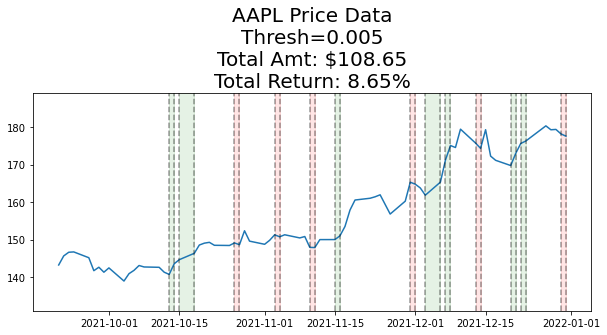

In [15]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (11,0,11), thresh, verbose=False)